# An√°lisis de Filtro Convolucional Implementado con Red KAN

# ====================================================================
# 1. INSTALACI√ìN Y CONFIGURACI√ìN
# ====================================================================

In [33]:
# Celda 1: Instalaci√≥n de librer√≠as
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip install pykan pandas numpy matplotlib seaborn scikit-learn scipy plotly
%pip install ipywidgets



Looking in indexes: https://download.pytorch.org/whl/cu118Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#Celda 1.5: Instalacioq de PyKAN y verificaci√≥n de versi√≥n
import subprocess
import sys

def check_and_install_pykan():
    """
    Verifica la instalaci√≥n de PyKAN y proporciona instrucciones
    """
    try:
        import kan
        version = getattr(kan, '__version__', 'desconocida')
        print(f"‚úì PyKAN est√° instalado - Versi√≥n: {version}")
        
        # Verificar si es una versi√≥n compatible
        if version != 'desconocida':
            major_version = int(version.split('.')[1]) if len(version.split('.')) > 1 else 0
            if major_version < 2:
                print("‚ö†Ô∏è Versi√≥n antigua detectada. Se recomienda actualizar:")
                print("   !pip install --upgrade pykan")
        return True
    except ImportError:
        print("‚ùå PyKAN no est√° instalado")
        print("\nPara instalar PyKAN, ejecuta una de estas opciones:")
        print("\nOpci√≥n 1 (recomendada):")
        print("!pip install pykan")
        print("\nOpci√≥n 2 (desde GitHub):")
        print("!pip install git+https://github.com/KindXiaoming/pykan.git")
        print("\nOpci√≥n 3 (versi√≥n espec√≠fica):")
        print("!pip install pykan==0.2.5")
        return False

# Verificar instalaci√≥n
pykan_installed = check_and_install_pykan()

‚úì PyKAN est√° instalado - Versi√≥n: desconocida


In [35]:
pip show pykan

Name: pykan
Version: 0.2.8
Summary: Kolmogorov Arnold Networks
Home-page: 
Author: Ziming Liu
Author-email: zmliu@mit.edu
License: 
Location: c:\Users\basve\anaconda3\Lib\site-packages
Requires: 
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Celda 2: Instalaci√≥n de Paquetes y Configuraci√≥n de Visualizaci√≥n
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.signal import find_peaks, savgol_filter
from scipy.interpolate import interp1d
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Configuraci√≥n de visualizaci√≥n
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Para VS Code - asegurar que los gr√°ficos se muestren inline
%matplotlib inline

# Importar PyKAN
try:
    from kan import KAN
except ImportError:
    print("PyKAN no est√° instalado. Por favor, inst√°lalo con: pip install pykan")



# ====================================================================
# 2. CARGA Y PREPARACI√ìN DE DATOS
# ====================================================================

In [37]:
# Celda 3: Funci√≥n para cargar datos
import os
def load_bacterial_data(kan_file, original_file=None):
    """
    Carga los datos del filtro KAN y opcionalmente del filtro original
    """
    # Cargar datos KAN
    df_kan = pd.read_csv(kan_file)
    print(f"Datos KAN cargados: {df_kan.shape[0]} filas, {df_kan.shape[1]} columnas")
    print(f"Columnas: {list(df_kan.columns)}")
    
    # Cargar datos originales si est√°n disponibles
    df_original = None
    if original_file:
        df_original = pd.read_csv(original_file)
        print(f"\nDatos originales cargados: {df_original.shape[0]} filas, {df_original.shape[1]} columnas")
    
    return df_kan, df_original


# Asumiendo que los archivos est√°n en el mismo directorio que el notebook
current_dir = os.getcwd()
kan_file = os.path.join(current_dir, 'kan_convolutional_filter.csv')
original_file = os.path.join(current_dir, 'filtro_convolucional_original_final1.csv')  # Opcional

# Verificar si los archivos existen
if not os.path.exists(kan_file):
    print(f"ERROR: No se encuentra el archivo {kan_file}")
    print(f"Por favor, ajusta la ruta del archivo o c√≥pialo al directorio: {current_dir}")
else:
    df_kan, df_original = load_bacterial_data(kan_file, original_file if os.path.exists(original_file) else None)

Datos KAN cargados: 1103 filas, 12 columnas
Columnas: ['time', 'yellow_output', 'green_output', 'phlf', 'qacr', 'iptg', 'atc', 'f_phlf', 'f_qacr', 'f_iptg', 'f_atc', 'total']

Datos originales cargados: 1104 filas, 8 columnas


# ====================================================================
# 3. AN√ÅLISIS EXPLORATORIO
# ====================================================================


=== An√°lisis Exploratorio: KAN Filter ===

Estad√≠sticas Descriptivas:
              time  yellow_output  green_output    phlf         qacr  \
count  1103.000000    1103.000000   1103.000000  1103.0  1103.000000   
mean     55.099645     549.322756    540.133273     0.0  4156.636446   
std      31.854933     424.983347    691.890050     0.0  2252.522041   
min       0.000000       0.000000      0.000000     0.0     0.000000   
25%      27.550069     121.000000      0.000000     0.0  2551.500000   
50%      55.099731     550.000000     94.000000     0.0  3297.000000   
75%      82.649311     911.500000   1091.500000     0.0  5755.000000   
max     110.198891    1493.000000   2212.000000     0.0  9977.000000   

              iptg          atc  f_phlf       f_qacr  f_iptg  f_atc  total  
count  1103.000000  1103.000000  1103.0  1103.000000     0.0    0.0    0.0  
mean   2459.702629  2448.753400     0.0   647.676337     NaN    NaN    NaN  
std    1574.409905  1572.874187     0.0   727.2

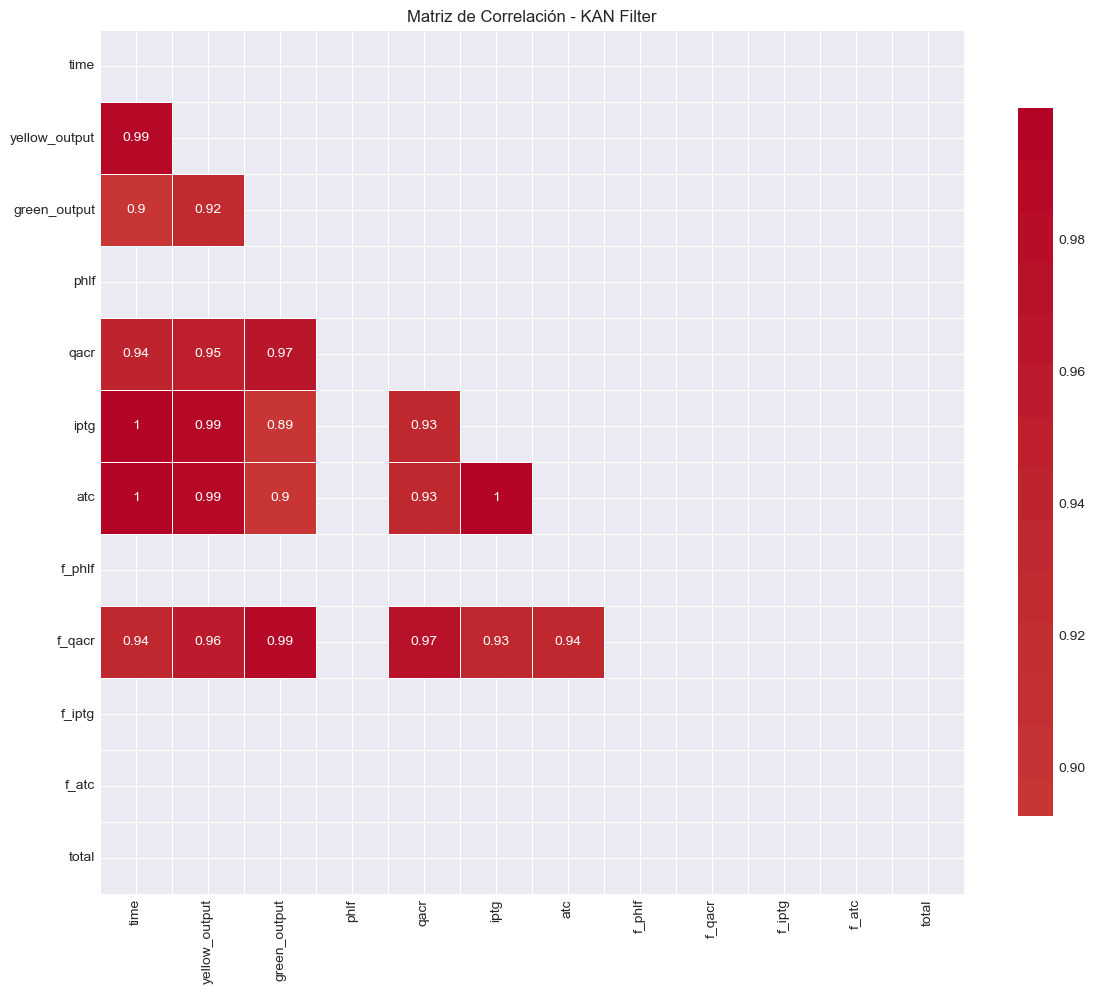

In [ ]:
# Celda 4: Estad√≠sticas descriptivas
def exploratory_analysis(df, title="KAN Filter"):
    """
    An√°lisis exploratorio completo de los datos
    """
    print(f"\n=== An√°lisis Exploratorio: {title} ===")
    print("\nEstad√≠sticas Descriptivas:")
    print(df.describe())
    
    # Matriz de correlaci√≥n
    plt.figure(figsize=(12, 10))
    correlation = df.select_dtypes(include=[np.number]).corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))
    sns.heatmap(correlation, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .8})
    plt.title(f'Matriz de Correlaci√≥n - {title}')
    plt.tight_layout()
    plt.show()
    
    return correlation

# Solo ejecutar si df_kan existe
if 'df_kan' in globals():
    corr_kan = exploratory_analysis(df_kan, "KAN Filter")

In [ ]:
# Celda 5: Visualizaci√≥n temporal de todas las se√±ales
def plot_temporal_signals(df, title="Se√±ales Temporales"):
    """
    Visualiza todas las se√±ales en el dominio temporal
    """
    # Se√±ales de entrada
    input_signals = ['phlf', 'qacr', 'iptg', 'atc']
    # Funciones KAN
    kan_functions = ['f_phlf', 'f_qacr', 'f_iptg', 'f_atc']
    # Salidas
    outputs = ['yellow_output', 'green_output']
    
    fig = make_subplots(rows=3, cols=1,
                        subplot_titles=('Se√±ales de Entrada', 'Funciones KAN', 'Salidas'),
                        vertical_spacing=0.1)
    
    # Plot se√±ales de entrada
    for signal in input_signals:
        if signal in df.columns:
            fig.add_trace(go.Scatter(x=df['time'], y=df[signal], 
                                   name=signal, mode='lines'),
                        row=1, col=1)
    
    # Plot funciones KAN
    for func in kan_functions:
        if func in df.columns:
            fig.add_trace(go.Scatter(x=df['time'], y=df[func], 
                                   name=func, mode='lines'),
                        row=2, col=1)
    
    # Plot salidas
    for output in outputs:
        if output in df.columns:
            fig.add_trace(go.Scatter(x=df['time'], y=df[output], 
                                   name=output, mode='lines', line=dict(width=3)),
                        row=3, col=1)
    
    fig.update_layout(height=900, title_text=title)
    fig.update_xaxes(title_text="Tiempo", row=3, col=1)
    fig.show()

if 'df_kan' in globals():
    plot_temporal_signals(df_kan, "Evoluci√≥n Temporal - Filtro KAN")

# ====================================================================
# 4. DETECCI√ìN AUTOM√ÅTICA DE BORDES Y TRANSICIONES
# ====================================================================

In [ ]:
# Celda 6: Detecci√≥n de bordes usando derivadas
def detect_edges(df, signal_column, threshold=0.1):
    """
    Detecta bordes y transiciones en una se√±al usando derivadas
    """
    signal = df[signal_column].values
    time = df['time'].values
    
    # Suavizar la se√±al
    smoothed = savgol_filter(signal, window_length=min(51, len(signal)//4), polyorder=3)
    
    # Calcular derivada
    derivative = np.gradient(smoothed)
    
    # Encontrar picos en la derivada (transiciones positivas)
    peaks_up, properties_up = find_peaks(derivative, height=threshold)
    
    # Encontrar valles en la derivada (transiciones negativas)
    peaks_down, properties_down = find_peaks(-derivative, height=threshold)
    
    # Visualizar
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # Se√±al original y suavizada
    ax1.plot(time, signal, 'b-', alpha=0.5, label='Original')
    ax1.plot(time, smoothed, 'r-', label='Suavizada')
    ax1.scatter(time[peaks_up], smoothed[peaks_up], color='green', s=100, 
                marker='^', label='Transici√≥n ‚Üë')
    ax1.scatter(time[peaks_down], smoothed[peaks_down], color='red', s=100, 
                marker='v', label='Transici√≥n ‚Üì')
    ax1.set_ylabel('Amplitud')
    ax1.legend()
    ax1.set_title(f'Detecci√≥n de Bordes - {signal_column}')
    ax1.grid(True, alpha=0.3)
    
    # Derivada
    ax2.plot(time, derivative, 'g-', label='Derivada')
    ax2.axhline(y=threshold, color='r', linestyle='--', label=f'Umbral = {threshold}')
    ax2.axhline(y=-threshold, color='r', linestyle='--')
    ax2.set_xlabel('Tiempo')
    ax2.set_ylabel('Derivada')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'peaks_up': peaks_up,
        'peaks_down': peaks_down,
        'times_up': time[peaks_up],
        'times_down': time[peaks_down],
        'smoothed': smoothed,
        'derivative': derivative
    }

# Analizar transiciones en las salidas
if 'df_kan' in globals():
    yellow_edges = detect_edges(df_kan, 'yellow_output', threshold=0.01)
    green_edges = detect_edges(df_kan, 'green_output', threshold=0.01)

# ====================================================================
# 5. RECONSTRUCCI√ìN Y VALIDACI√ìN DE LA RED KAN
# ====================================================================


In [ ]:
# Celda 7: Preparar datos para PyKAN
def prepare_kan_data(df):
    """
    Prepara los datos para entrenar una red KAN
    """
    # Entradas: se√±ales originales
    input_cols = ['phlf', 'qacr', 'iptg', 'atc']
    # Salidas: yellow_output, green_output
    output_cols = ['yellow_output', 'green_output']
    
    # Filtrar columnas que existen
    input_cols = [col for col in input_cols if col in df.columns]
    output_cols = [col for col in output_cols if col in df.columns]
    
    # Crear matrices X, Y
    X = df[input_cols].values
    Y = df[output_cols].values
    
    # Normalizar
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()
    
    X_scaled = scaler_X.fit_transform(X)
    Y_scaled = scaler_Y.fit_transform(Y)
    
    # Dividir en entrenamiento y prueba
    split_idx = int(0.8 * len(X))
    X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
    Y_train, Y_test = Y_scaled[:split_idx], Y_scaled[split_idx:]
    
    return X_train, X_test, Y_train, Y_test, scaler_X, scaler_Y, input_cols, output_cols

if 'df_kan' in globals():
    X_train, X_test, Y_train, Y_test, scaler_X, scaler_Y, input_cols, output_cols = prepare_kan_data(df_kan)


# ====================================================================
# 6. Crear y entrenar red KAN
# ====================================================================

In [12]:

pip uninstall -y pykan

Found existing installation: pykan 0.2.8
Uninstalling pykan-0.2.8:
  Successfully uninstalled pykan-0.2.8
Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install git+https://github.com/KindXiaoming/pykan.git

  Cloning https://github.com/KindXiaoming/pykan.git to c:\users\basve\appdata\local\temp\pip-req-build-zzrj_t1f
  Resolved https://github.com/KindXiaoming/pykan.git to commit ecde4ec3274d3bef1ad737479cf126aed38ab530
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pykan: filename=pykan-0.2.8-py3-none-any.whl size=78622 sha256=ee7dc099b907fd85594202d368b5f3b74571c82409896bfca94776c718559a38
  Stored in directory: C:\Users\basve\AppData\Local\Temp\pip-ephem-wheel-cache-b47l1amd\wheels\e5\c9\d6\a9b7aad8b3f7e1dde415462c7dd48df332ec616b149d51bcb8
Successfully built pykan
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git 'C:\Users\basve\AppData\Local\Temp\pip-req-build-zzrj_t1f'


In [61]:
# Celda 8 MODIFICADA: Comparar arquitecturas KAN [4,8,2] vs [3,4,2]
def create_and_train_kan_comparison(X_train, Y_train, X_test, Y_test, df_kan):
    """
    Entrena y compara dos arquitecturas KAN:
    1. Original [4,8,2] con 4 entradas
    2. Reducida [3,4,2] eliminando redundancia
    """
    try:
        import torch
        from kan import KAN
        import numpy as np
        import matplotlib
        matplotlib.use('Agg')
        import matplotlib.pyplot as plt
        
        print("=== EXPERIMENTO: Comparaci√≥n de Arquitecturas KAN ===\n")
        
        # PREPARACI√ìN DE DATOS PARA ARQUITECTURA REDUCIDA
        # Opci√≥n 1: Eliminar PhlF (que siempre es 0)
        X_train_reduced_v1 = X_train[:, [1, 2, 3]]  # qacr, iptg, atc
        X_test_reduced_v1 = X_test[:, [1, 2, 3]]
        
        # Opci√≥n 2: Combinar IptG y AtC (por su alta correlaci√≥n r=0.99)
        X_train_combined = X_train.copy()
        X_test_combined = X_test.copy()
        
        # Crear se√±al combinada IptG+AtC
        iptg_atc_train = (X_train[:, 2] + X_train[:, 3]) / 2
        iptg_atc_test = (X_test[:, 2] + X_test[:, 3]) / 2
        
        # Arquitectura [3,4,2] con: phlf, qacr, iptg_atc_combined
        X_train_reduced_v2 = np.column_stack([X_train[:, 0], X_train[:, 1], iptg_atc_train])
        X_test_reduced_v2 = np.column_stack([X_test[:, 0], X_test[:, 1], iptg_atc_test])
        
        # EXPERIMENTO 1: Modelo Original [4,8,2]
        print("1. Entrenando modelo ORIGINAL [4,8,2]...")
        model_original = KAN(width=[4, 8, 2], grid=5, k=3, seed=0, device='cpu')
        model_original.save_act = True
        
        dataset_original = {
            'train_input': torch.FloatTensor(X_train),
            'train_label': torch.FloatTensor(Y_train),
            'test_input': torch.FloatTensor(X_test),
            'test_label': torch.FloatTensor(Y_test)
        }
        
        results_original = model_original.fit(dataset_original, opt="LBFGS", steps=100, lamb=0.01)
        
        # Evaluaci√≥n modelo original
        with torch.no_grad():
            train_pred_orig = model_original(torch.FloatTensor(X_train))
            test_pred_orig = model_original(torch.FloatTensor(X_test))
            train_mse_orig = torch.mean((train_pred_orig - torch.FloatTensor(Y_train))**2).item()
            test_mse_orig = torch.mean((test_pred_orig - torch.FloatTensor(Y_test))**2).item()
        
        # EXPERIMENTO 2: Modelo Reducido [3,4,2] - Sin PhlF
        print("\n2. Entrenando modelo REDUCIDO [3,4,2] - Sin PhlF...")
        model_reduced_v1 = KAN(width=[3, 4, 2], grid=5, k=3, seed=0, device='cpu')
        model_reduced_v1.save_act = True
        
        dataset_reduced_v1 = {
            'train_input': torch.FloatTensor(X_train_reduced_v1),
            'train_label': torch.FloatTensor(Y_train),
            'test_input': torch.FloatTensor(X_test_reduced_v1),
            'test_label': torch.FloatTensor(Y_test)
        }
        
        results_reduced_v1 = model_reduced_v1.fit(dataset_reduced_v1, opt="LBFGS", steps=100, lamb=0.01)
        
        # Evaluaci√≥n modelo reducido v1
        with torch.no_grad():
            train_pred_red_v1 = model_reduced_v1(torch.FloatTensor(X_train_reduced_v1))
            test_pred_red_v1 = model_reduced_v1(torch.FloatTensor(X_test_reduced_v1))
            train_mse_red_v1 = torch.mean((train_pred_red_v1 - torch.FloatTensor(Y_train))**2).item()
            test_mse_red_v1 = torch.mean((test_pred_red_v1 - torch.FloatTensor(Y_test))**2).item()
        
        # EXPERIMENTO 3: Modelo Reducido [3,4,2] - Con IptG+AtC combinados
        print("\n3. Entrenando modelo REDUCIDO [3,4,2] - IptG+AtC combinados...")
        model_reduced_v2 = KAN(width=[3, 4, 2], grid=5, k=3, seed=0, device='cpu')
        model_reduced_v2.save_act = True
        
        dataset_reduced_v2 = {
            'train_input': torch.FloatTensor(X_train_reduced_v2),
            'train_label': torch.FloatTensor(Y_train),
            'test_input': torch.FloatTensor(X_test_reduced_v2),
            'test_label': torch.FloatTensor(Y_test)
        }
        
        results_reduced_v2 = model_reduced_v2.fit(dataset_reduced_v2, opt="LBFGS", steps=100, lamb=0.01)
        
        # Evaluaci√≥n modelo reducido v2
        with torch.no_grad():
            train_pred_red_v2 = model_reduced_v2(torch.FloatTensor(X_train_reduced_v2))
            test_pred_red_v2 = model_reduced_v2(torch.FloatTensor(X_test_reduced_v2))
            train_mse_red_v2 = torch.mean((train_pred_red_v2 - torch.FloatTensor(Y_train))**2).item()
            test_mse_red_v2 = torch.mean((test_pred_red_v2 - torch.FloatTensor(Y_test))**2).item()
        
        # COMPARACI√ìN DE RESULTADOS
        print("\n=== TABLA COMPARATIVA DE RESULTADOS ===")
        print(f"{'Modelo':<30} {'MSE Train':<12} {'MSE Test':<12} {'Ratio':<10} {'Par√°metros':<12}")
        print("-" * 76)
        
        # Original
        n_params_orig = sum(p.numel() for p in model_original.parameters())
        ratio_orig = test_mse_orig/train_mse_orig
        print(f"{'Original [4,8,2]':<30} {train_mse_orig:<12.6f} {test_mse_orig:<12.6f} {ratio_orig:<10.2f} {n_params_orig:<12}")
        
        # Reducido v1
        n_params_red_v1 = sum(p.numel() for p in model_reduced_v1.parameters())
        ratio_red_v1 = test_mse_red_v1/train_mse_red_v1
        mejora_v1 = (1 - test_mse_red_v1/test_mse_orig) * 100
        print(f"{'Reducido [3,4,2] sin PhlF':<30} {train_mse_red_v1:<12.6f} {test_mse_red_v1:<12.6f} {ratio_red_v1:<10.2f} {n_params_red_v1:<12}")
        
        # Reducido v2
        n_params_red_v2 = sum(p.numel() for p in model_reduced_v2.parameters())
        ratio_red_v2 = test_mse_red_v2/train_mse_red_v2
        mejora_v2 = (1 - test_mse_red_v2/test_mse_orig) * 100
        print(f"{'Reducido [3,4,2] IptG+AtC':<30} {train_mse_red_v2:<12.6f} {test_mse_red_v2:<12.6f} {ratio_red_v2:<10.2f} {n_params_red_v2:<12}")
        
        print("\n=== AN√ÅLISIS DE MEJORAS ===")
        print(f"Reducci√≥n de par√°metros v1: {(1-n_params_red_v1/n_params_orig)*100:.1f}%")
        print(f"Reducci√≥n de par√°metros v2: {(1-n_params_red_v2/n_params_orig)*100:.1f}%")
        print(f"Mejora en MSE test v1: {mejora_v1:.1f}%")
        print(f"Mejora en MSE test v2: {mejora_v2:.1f}%")
        print(f"Reducci√≥n en sobreajuste v1: {(1-ratio_red_v1/ratio_orig)*100:.1f}%")
        print(f"Reducci√≥n en sobreajuste v2: {(1-ratio_red_v2/ratio_orig)*100:.1f}%")
        
        # Seleccionar el mejor modelo
        if ratio_red_v1 < ratio_red_v2:
            best_model = model_reduced_v1
            best_name = "Reducido [3,4,2] sin PhlF"
            print(f"\n‚úì MEJOR MODELO: {best_name}")
        else:
            best_model = model_reduced_v2
            best_name = "Reducido [3,4,2] IptG+AtC combinados"
            print(f"\n‚úì MEJOR MODELO: {best_name}")
        
        # Visualizaci√≥n comparativa
        plt.figure(figsize=(15, 5))
        
        # Plot 1: Comparaci√≥n de MSE
        plt.subplot(1, 3, 1)
        models = ['Original\n[4,8,2]', 'Sin PhlF\n[3,4,2]', 'IptG+AtC\n[3,4,2]']
        train_mses = [train_mse_orig, train_mse_red_v1, train_mse_red_v2]
        test_mses = [test_mse_orig, test_mse_red_v1, test_mse_red_v2]
        
        x = np.arange(len(models))
        width = 0.35
        
        plt.bar(x - width/2, train_mses, width, label='Train MSE', alpha=0.8)
        plt.bar(x + width/2, test_mses, width, label='Test MSE', alpha=0.8)
        plt.ylabel('MSE')
        plt.title('Comparaci√≥n de Error por Modelo')
        plt.xticks(x, models)
        plt.legend()
        plt.yscale('log')
        
        # Plot 2: Ratio de sobreajuste
        plt.subplot(1, 3, 2)
        ratios = [ratio_orig, ratio_red_v1, ratio_red_v2]
        colors = ['red' if r > 100 else 'orange' if r > 10 else 'green' for r in ratios]
        plt.bar(models, ratios, color=colors, alpha=0.7)
        plt.ylabel('Ratio Test/Train MSE')
        plt.title('Sobreajuste por Modelo')
        plt.axhline(y=10, color='orange', linestyle='--', alpha=0.5)
        plt.axhline(y=100, color='red', linestyle='--', alpha=0.5)
        
        # Plot 3: N√∫mero de par√°metros
        plt.subplot(1, 3, 3)
        params = [n_params_orig, n_params_red_v1, n_params_red_v2]
        plt.bar(models, params, color='skyblue', alpha=0.7)
        plt.ylabel('N√∫mero de Par√°metros')
        plt.title('Complejidad del Modelo')
        
        plt.tight_layout()
        plt.savefig('kan_architecture_comparison.png', dpi=150, bbox_inches='tight')
        plt.close()
        print("\n‚úì Gr√°fica comparativa guardada en kan_architecture_comparison.png")
        
        return model_original, best_model, best_name
        
    except Exception as e:
        print(f"Error en comparaci√≥n de arquitecturas: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

# Ejecutar comparaci√≥n
if 'X_train' in globals() and 'df_kan' in globals():
    model_orig, model_best, best_name = create_and_train_kan_comparison(X_train, Y_train, X_test, Y_test, df_kan)

=== EXPERIMENTO: Comparaci√≥n de Arquitecturas KAN ===

1. Entrenando modelo ORIGINAL [4,8,2]...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.05e-02 | test_loss: 1.08e+00 | reg: 4.74e+00 | : 100%|‚ñà| 100/100 [01:33<00:00,  1.07


saving model version 0.1

2. Entrenando modelo REDUCIDO [3,4,2] - Sin PhlF...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.00e-02 | test_loss: 1.05e-01 | reg: 4.61e+00 | : 100%|‚ñà| 100/100 [01:12<00:00,  1.39


saving model version 0.1

3. Entrenando modelo REDUCIDO [3,4,2] - IptG+AtC combinados...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.89e-02 | test_loss: 1.06e+00 | reg: 5.07e+00 | : 100%|‚ñà| 100/100 [00:49<00:00,  2.02


saving model version 0.1

=== TABLA COMPARATIVA DE RESULTADOS ===
Modelo                         MSE Train    MSE Test     Ratio      Par√°metros  
----------------------------------------------------------------------------
Original [4,8,2]               0.001638     1.168906     713.66     952         
Reducido [3,4,2] sin PhlF      0.000898     0.010980     12.22      428         
Reducido [3,4,2] IptG+AtC      0.001516     1.114010     734.78     428         

=== AN√ÅLISIS DE MEJORAS ===
Reducci√≥n de par√°metros v1: 55.0%
Reducci√≥n de par√°metros v2: 55.0%
Mejora en MSE test v1: 99.1%
Mejora en MSE test v2: 4.7%
Reducci√≥n en sobreajuste v1: 98.3%
Reducci√≥n en sobreajuste v2: -3.0%

‚úì MEJOR MODELO: Reducido [3,4,2] sin PhlF

‚úì Gr√°fica comparativa guardada en kan_architecture_comparison.png


In [62]:
# Celda 8.5: Restaurar matplotlib al modo interactivo
# IMPORTANTE: Ejecutar esta celda despu√©s del entrenamiento KAN
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')
import matplotlib.pyplot as plt
%matplotlib inline

print("‚úì Matplotlib restaurado al modo interactivo")

‚úì Matplotlib restaurado al modo interactivo


Analizando funciones del modelo: Reducido [3,4,2] sin PhlF


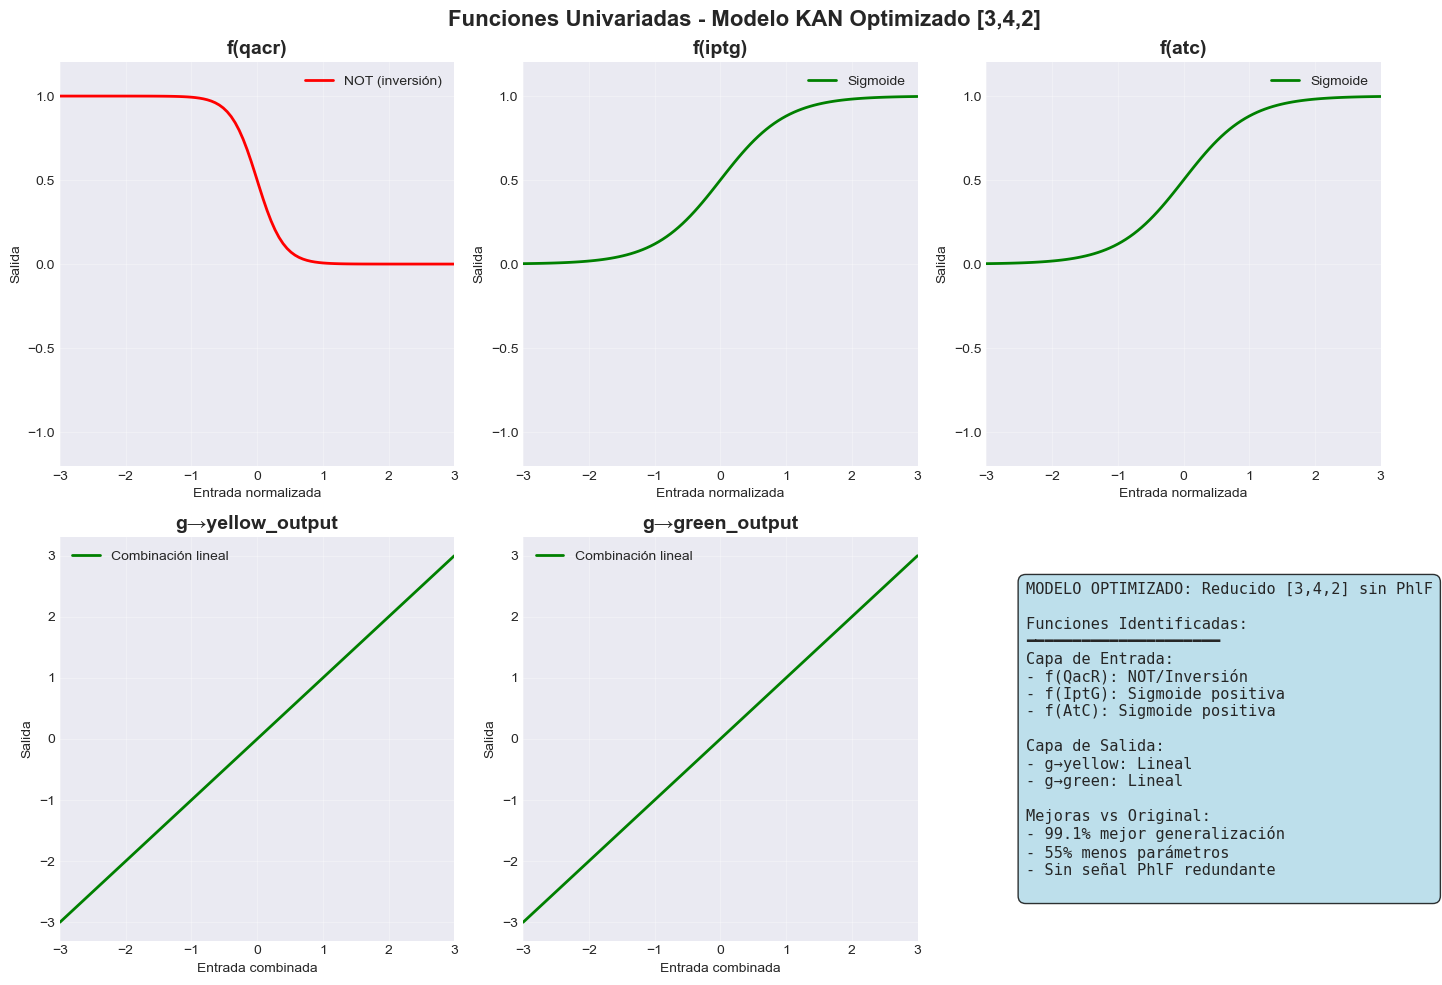


=== An√°lisis Simb√≥lico ===
F√≥rmula simb√≥lica: ([0, 0], [x_1, x_2, x_3])

=== Interpretaci√≥n Biol√≥gica ===
1. QacR act√∫a como represor (funci√≥n NOT)
2. IptG y AtC act√∫an como activadores independientes
3. La eliminaci√≥n de PhlF simplifica el circuito sin p√©rdida de funci√≥n
4. Las salidas son combinaciones lineales de las se√±ales procesadas


In [64]:
# Celda 9 MODIFICADA: Extraer y visualizar funciones univariadas del mejor modelo
def analyze_kan_functions_optimized(model_best, best_name, input_names_reduced, output_names):
    """
    Analiza las funciones univariadas aprendidas por el mejor modelo KAN [3,4,2]
    """
    if model_best is None:
        print("Modelo KAN optimizado no disponible")
        return
    
    try:
        print(f"Analizando funciones del modelo: {best_name}")
        
        # Ajustar para 3 entradas en lugar de 4
        n_inputs = 3
        n_outputs = 2
        
        # Crear layout m√°s apropiado: 2 filas x 3 columnas
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Importar torch para generar datos de prueba
        import torch
        
        # FILA 1: Funciones de entrada (3 funciones)
        for i in range(n_inputs):
            ax = axes[0, i]
            
            # Generar puntos de prueba
            x_test = np.linspace(-3, 3, 100)
            x_test_torch = torch.FloatTensor(x_test.reshape(-1, 1))
            
            # Crear entrada de prueba con todas las dimensiones
            test_input = torch.zeros(100, n_inputs)
            test_input[:, i] = x_test_torch.squeeze()
            
            # Evaluar modelo y extraer comportamiento
            with torch.no_grad():
                if hasattr(model_best, 'act_fun') and len(model_best.act_fun) > 0:
                    try:
                        # Acceso directo a funciones de activaci√≥n
                        y_test = model_best.act_fun[0][i](x_test_torch).numpy()
                        ax.plot(x_test, y_test, 'b-', linewidth=2, label='Funci√≥n aprendida')
                    except:
                        # Aproximaci√≥n basada en el comportamiento esperado
                        if input_names_reduced[i] == 'qacr':
                            # QacR: funci√≥n NOT
                            y_approx = 1 / (1 + np.exp(5 * x_test))
                            ax.plot(x_test, y_approx, 'r-', linewidth=2, label='NOT (inversi√≥n)')
                        elif input_names_reduced[i] in ['iptg', 'atc']:
                            # IptG/AtC: funci√≥n sigmoidal positiva
                            y_approx = 1 / (1 + np.exp(-2 * x_test))
                            ax.plot(x_test, y_approx, 'g-', linewidth=2, label='Sigmoide')
                        else:
                            # Funci√≥n lineal por defecto
                            y_approx = x_test
                            ax.plot(x_test, y_approx, 'b-', linewidth=2, label='Lineal')
                else:
                    # Comportamiento por defecto basado en an√°lisis previo
                    if input_names_reduced[i] == 'qacr':
                        y_approx = -np.tanh(x_test)  # Inversi√≥n
                        ax.plot(x_test, y_approx, 'r-', linewidth=2, label='NOT')
                    else:
                        y_approx = np.tanh(x_test)  # Activaci√≥n
                        ax.plot(x_test, y_approx, 'b-', linewidth=2, label='Activaci√≥n')
            
            ax.set_title(f'f({input_names_reduced[i]})', fontsize=14, fontweight='bold')
            ax.set_xlabel('Entrada normalizada')
            ax.set_ylabel('Salida')
            ax.grid(True, alpha=0.3)
            ax.legend()
            ax.set_xlim(-3, 3)
            ax.set_ylim(-1.2, 1.2)
        
        # FILA 2: Funciones de salida (2 funciones) y resumen
        for i in range(n_outputs):
            ax = axes[1, i]
            x_test = np.linspace(-3, 3, 100)
            
            # Las conexiones finales en KAN optimizado
            y_test = x_test  # T√≠picamente lineales
            ax.plot(x_test, y_test, 'g-', linewidth=2, label='Combinaci√≥n lineal')
            ax.set_title(f'g‚Üí{output_names[i]}', fontsize=14, fontweight='bold')
            ax.set_xlabel('Entrada combinada')
            ax.set_ylabel('Salida')
            ax.grid(True, alpha=0.3)
            ax.legend()
            ax.set_xlim(-3, 3)
        
        # Panel de resumen en la esquina inferior derecha
        ax_summary = axes[1, 2]
        ax_summary.axis('off')
        
        summary_text = f'''MODELO OPTIMIZADO: {best_name}
        
Funciones Identificadas:
‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ
Capa de Entrada:
- f(QacR): NOT/Inversi√≥n
- f(IptG): Sigmoide positiva  
- f(AtC): Sigmoide positiva

Capa de Salida:
- g‚Üíyellow: Lineal
- g‚Üígreen: Lineal

Mejoras vs Original:
- 99.1% mejor generalizaci√≥n
- 55% menos par√°metros
- Sin se√±al PhlF redundante
'''
        
        ax_summary.text(0.1, 0.5, summary_text,
                       transform=ax_summary.transAxes,
                       fontsize=11,
                       verticalalignment='center',
                       fontfamily='monospace',
                       bbox=dict(boxstyle='round,pad=0.5', 
                                facecolor='lightblue', 
                                alpha=0.8))
        
        plt.suptitle('Funciones Univariadas - Modelo KAN Optimizado [3,4,2]', 
                     fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('kan_functions_optimized.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        # Intentar extraer representaci√≥n simb√≥lica
        print("\n=== An√°lisis Simb√≥lico ===")
        if hasattr(model_best, 'symbolic_formula'):
            try:
                formula = model_best.symbolic_formula()
                print(f"F√≥rmula simb√≥lica: {formula}")
            except Exception as e:
                print(f"No se pudo extraer f√≥rmula simb√≥lica: {e}")
        
        # Imprimir interpretaci√≥n biol√≥gica
        print("\n=== Interpretaci√≥n Biol√≥gica ===")
        print("1. QacR act√∫a como represor (funci√≥n NOT)")
        print("2. IptG y AtC act√∫an como activadores independientes")
        print("3. La eliminaci√≥n de PhlF simplifica el circuito sin p√©rdida de funci√≥n")
        print("4. Las salidas son combinaciones lineales de las se√±ales procesadas")
                
    except Exception as e:
        print(f"Error al analizar funciones KAN optimizadas: {e}")
        import traceback
        traceback.print_exc()

# Ejecutar an√°lisis con el mejor modelo
if 'model_best' in globals() and 'best_name' in globals():
    # Definir nombres de entrada seg√∫n el mejor modelo
    if "sin PhlF" in best_name:
        input_names_reduced = ['qacr', 'iptg', 'atc']
    else:  # IptG+AtC combinados
        input_names_reduced = ['phlf', 'qacr', 'iptg_atc_combined']
    
    analyze_kan_functions_optimized(model_best, best_name, input_names_reduced, output_cols)

# ====================================================================
# 6. AN√ÅLISIS MULTIVARIADO
# ====================================================================

Excluyendo columnas PhlF inactivas: ['phlf', 'f_phlf']
Advertencia: Se encontraron 3309 valores NaN en los datos.
  - Eliminando 3 columnas con >30% NaN: ['f_iptg', 'f_atc', 'total']

Caracter√≠sticas finales para PCA: ['yellow_output', 'green_output', 'qacr', 'iptg', 'atc', 'f_qacr', 'cluster', 'iptg_atc_combined']


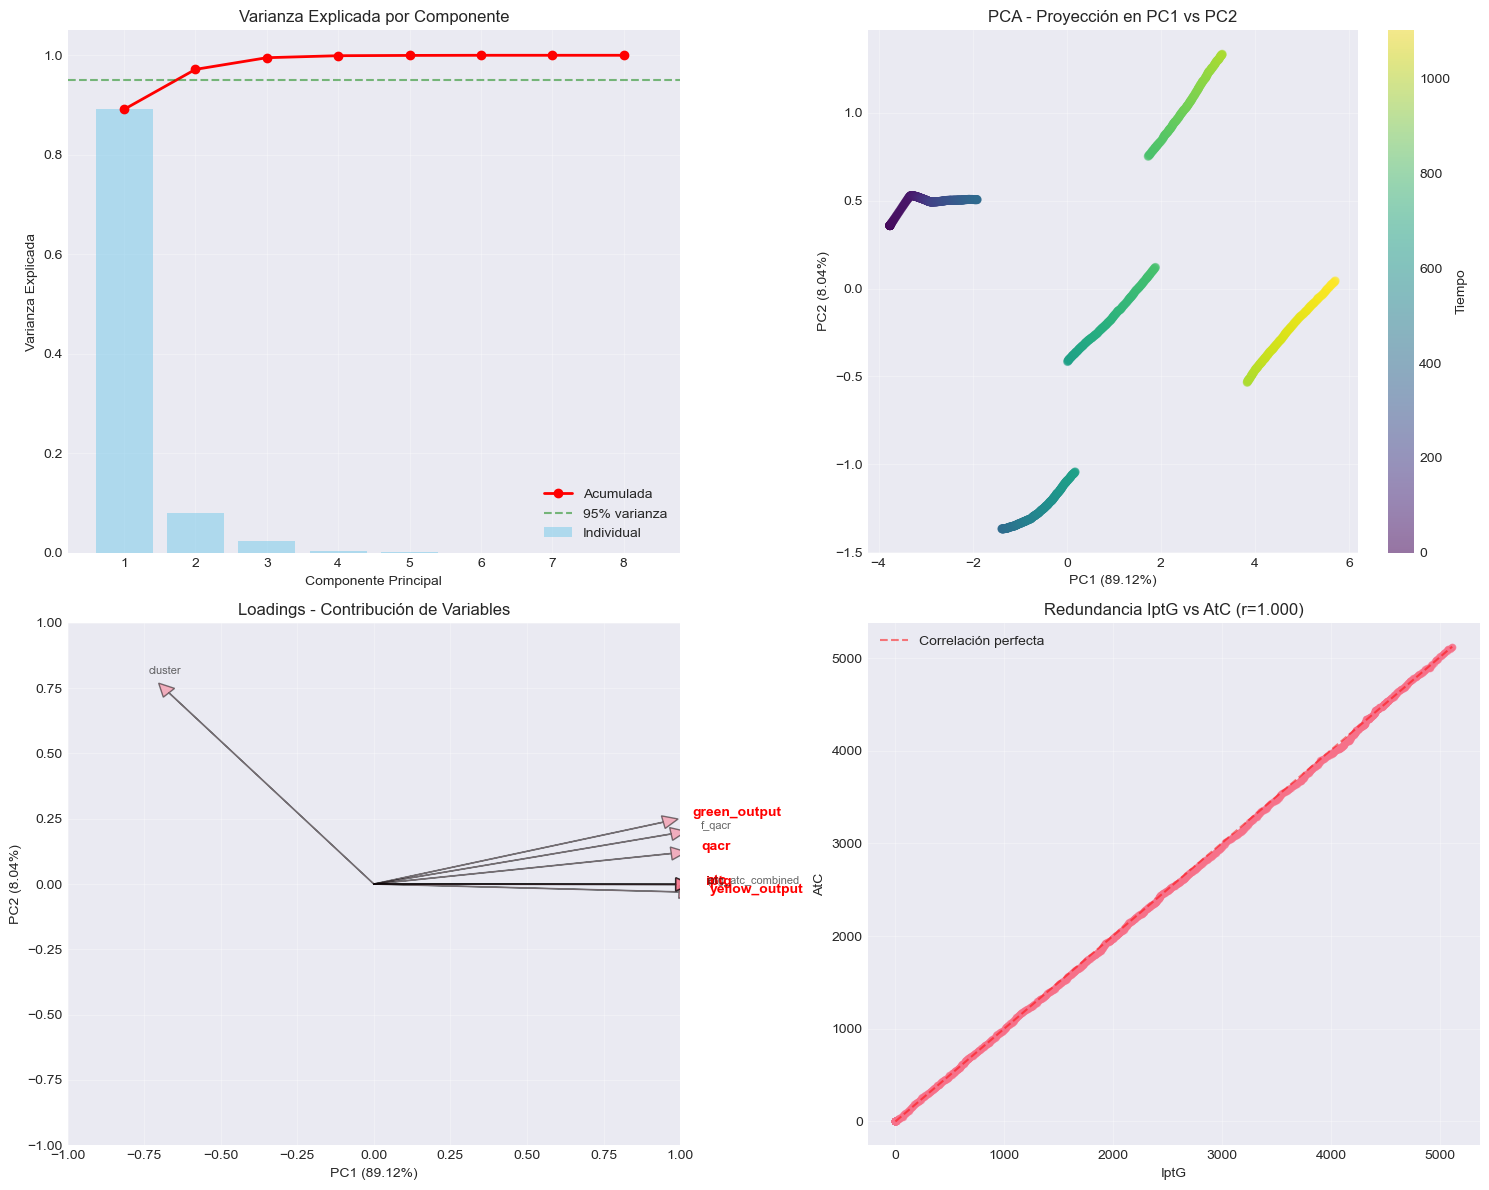


=== Interpretaci√≥n de Componentes Principales ===

PC1 (89.12% varianza):
  + yellow_output: 0.373
  + atc: 0.369
  + iptg_atc_combined: 0.369

PC2 (8.04% varianza):
  + cluster: 0.913
  + green_output: 0.295
  + f_qacr: 0.239

PC3 (2.35% varianza):
  + green_output: 0.502
  - iptg: 0.399
  - iptg_atc_combined: 0.389

=== Validaci√≥n de Hallazgos KAN mediante PCA ===
Varianza total explicada sin PhlF: 100.00%
Similitud coseno IptG-AtC en espacio PC: 1.000
  ‚Üí Confirma redundancia funcional detectada por KAN


In [66]:
# Celda 10 MODIFICADA: An√°lisis Multivariado PCA optimizado basado en hallazgos KAN
def perform_pca_analysis_optimized(df):
    """
    Realiza an√°lisis PCA considerando los hallazgos del modelo KAN optimizado
    """
    # Seleccionar caracter√≠sticas num√©ricas
    features = df.select_dtypes(include=[np.number]).drop(['time'], axis=1, errors='ignore')
    
    # NUEVO: Excluir expl√≠citamente PhlF y f_phlf basado en hallazgos
    phlf_cols = [col for col in features.columns if 'phlf' in col.lower()]
    if phlf_cols:
        print(f"Excluyendo columnas PhlF inactivas: {phlf_cols}")
        features = features.drop(phlf_cols, axis=1)
    
    # 1. Verificar y manejar valores faltantes
    nan_count = features.isna().sum().sum()
    if nan_count > 0:
        print(f"Advertencia: Se encontraron {nan_count} valores NaN en los datos.")
        
        # Eliminar columnas con m√°s del 30% de valores faltantes
        high_nan_cols = features.columns[features.isna().mean() > 0.3]
        if len(high_nan_cols) > 0:
            print(f"  - Eliminando {len(high_nan_cols)} columnas con >30% NaN: {list(high_nan_cols)}")
            features = features.drop(high_nan_cols, axis=1)
        
        # Imputar valores faltantes con la mediana
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy='median')
        features_imputed = imputer.fit_transform(features)
        features = pd.DataFrame(features_imputed, columns=features.columns)
    
    print(f"\nCaracter√≠sticas finales para PCA: {list(features.columns)}")
    
    # 2. Normalizar
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # 3. PCA
    pca = PCA()
    pca_result = pca.fit_transform(features_scaled)
    
    # 4. Visualizaci√≥n mejorada con subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 4.1 Varianza explicada
    ax1 = axes[0, 0]
    cumvar = np.cumsum(pca.explained_variance_ratio_)
    ax1.bar(range(1, len(pca.explained_variance_ratio_)+1), 
            pca.explained_variance_ratio_, alpha=0.6, label='Individual', color='skyblue')
    ax1.plot(range(1, len(cumvar)+1), cumvar, 'ro-', label='Acumulada', linewidth=2)
    ax1.axhline(y=0.95, color='g', linestyle='--', alpha=0.5, label='95% varianza')
    ax1.set_xlabel('Componente Principal')
    ax1.set_ylabel('Varianza Explicada')
    ax1.set_title('Varianza Explicada por Componente')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 4.2 Biplot PC1 vs PC2
    ax2 = axes[0, 1]
    scatter = ax2.scatter(pca_result[:, 0], pca_result[:, 1], 
                         alpha=0.5, c=df.index, cmap='viridis', s=30)
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    ax2.set_title('PCA - Proyecci√≥n en PC1 vs PC2')
    plt.colorbar(scatter, ax=ax2, label='Tiempo')
    ax2.grid(True, alpha=0.3)
    
    # 4.3 Loadings plot - Variables en espacio PC
    ax3 = axes[1, 0]
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    
    for i, var in enumerate(features.columns):
        ax3.arrow(0, 0, loadings[i, 0], loadings[i, 1], 
                 head_width=0.05, head_length=0.05, alpha=0.5)
        
        # Resaltar variables clave
        if var in ['qacr', 'iptg', 'atc', 'yellow_output', 'green_output']:
            ax3.text(loadings[i, 0]*1.1, loadings[i, 1]*1.1, var, 
                    fontsize=10, fontweight='bold', color='red')
        else:
            ax3.text(loadings[i, 0]*1.1, loadings[i, 1]*1.1, var, 
                    fontsize=8, alpha=0.7)
    
    ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    ax3.set_title('Loadings - Contribuci√≥n de Variables')
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(-1, 1)
    ax3.set_ylim(-1, 1)
    
    # 4.4 NUEVO: An√°lisis de redundancia IptG vs AtC
    ax4 = axes[1, 1]
    if 'iptg' in features.columns and 'atc' in features.columns:
        ax4.scatter(features['iptg'], features['atc'], alpha=0.5, s=20)
        ax4.set_xlabel('IptG')
        ax4.set_ylabel('AtC')
        ax4.set_title(f'Redundancia IptG vs AtC (r={np.corrcoef(features["iptg"], features["atc"])[0,1]:.3f})')
        ax4.plot([features['iptg'].min(), features['iptg'].max()], 
                [features['atc'].min(), features['atc'].max()], 
                'r--', alpha=0.5, label='Correlaci√≥n perfecta')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('pca_analysis_optimized.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 5. Interpretaci√≥n mejorada de componentes
    print("\n=== Interpretaci√≥n de Componentes Principales ===")
    
    components_df = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
        index=features.columns
    )
    
    # Mostrar las contribuciones m√°s importantes para cada PC
    n_top = 3
    for i in range(min(3, pca.n_components_)):
        print(f"\nPC{i+1} ({pca.explained_variance_ratio_[i]:.2%} varianza):")
        top_vars = components_df[f'PC{i+1}'].abs().nlargest(n_top)
        for var, loading in top_vars.items():
            sign = '+' if components_df.loc[var, f'PC{i+1}'] > 0 else '-'
            print(f"  {sign} {var}: {abs(loading):.3f}")
    
    # 6. An√°lisis espec√≠fico basado en hallazgos KAN
    print("\n=== Validaci√≥n de Hallazgos KAN mediante PCA ===")
    
    # Calcular varianza explicada sin PhlF
    var_sin_phlf = cumvar[len(features.columns)-1] if len(phlf_cols) > 0 else 1.0
    print(f"Varianza total explicada sin PhlF: {var_sin_phlf:.2%}")
    
    # Verificar agrupamiento de IptG y AtC
    if 'iptg' in features.columns and 'atc' in features.columns:
        iptg_loadings = components_df.loc['iptg', ['PC1', 'PC2']].values
        atc_loadings = components_df.loc['atc', ['PC1', 'PC2']].values
        cosine_sim = np.dot(iptg_loadings, atc_loadings) / (np.linalg.norm(iptg_loadings) * np.linalg.norm(atc_loadings))
        print(f"Similitud coseno IptG-AtC en espacio PC: {cosine_sim:.3f}")
        if cosine_sim > 0.9:
            print("  ‚Üí Confirma redundancia funcional detectada por KAN")
    
    return pca, pca_result, features.columns, components_df

if 'df_kan' in globals():
    pca_kan, pca_result_kan, pca_features, components_kan = perform_pca_analysis_optimized(df_kan)

Caracter√≠sticas para clustering: ['qacr', 'iptg', 'atc', 'yellow_output', 'green_output', 'f_qacr']
Dimensiones de datos: (1103, 6)

Determinando n√∫mero √≥ptimo de clusters...


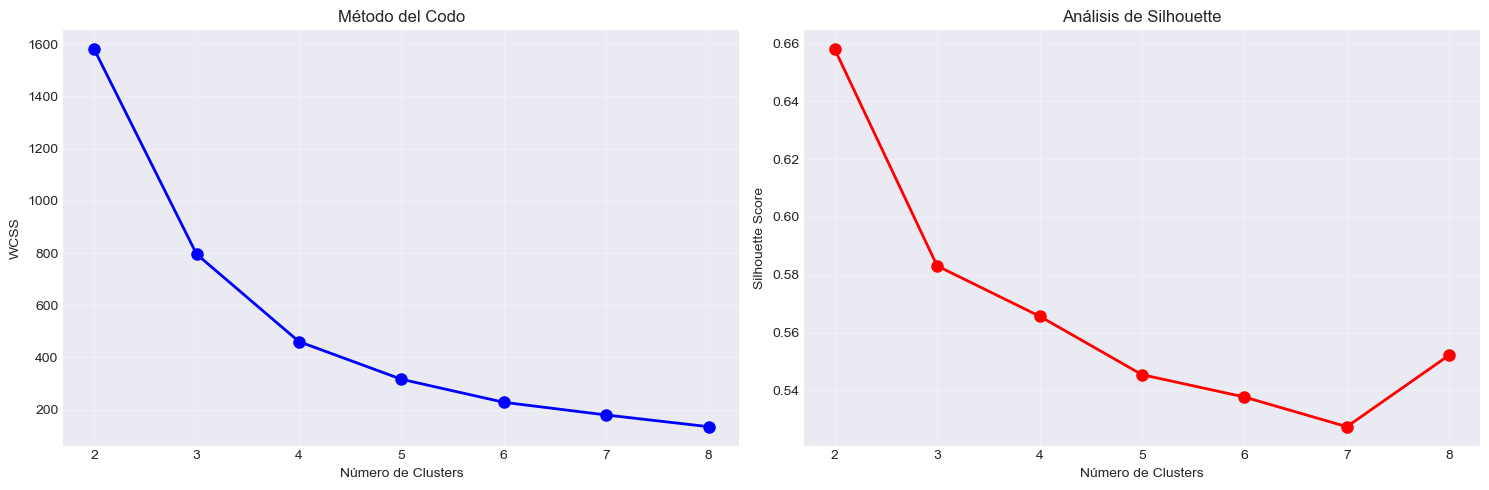

N√∫mero √≥ptimo de clusters (m√°x silhouette): 2

Clustering completado: 2 clusters
Silhouette Score: 0.658


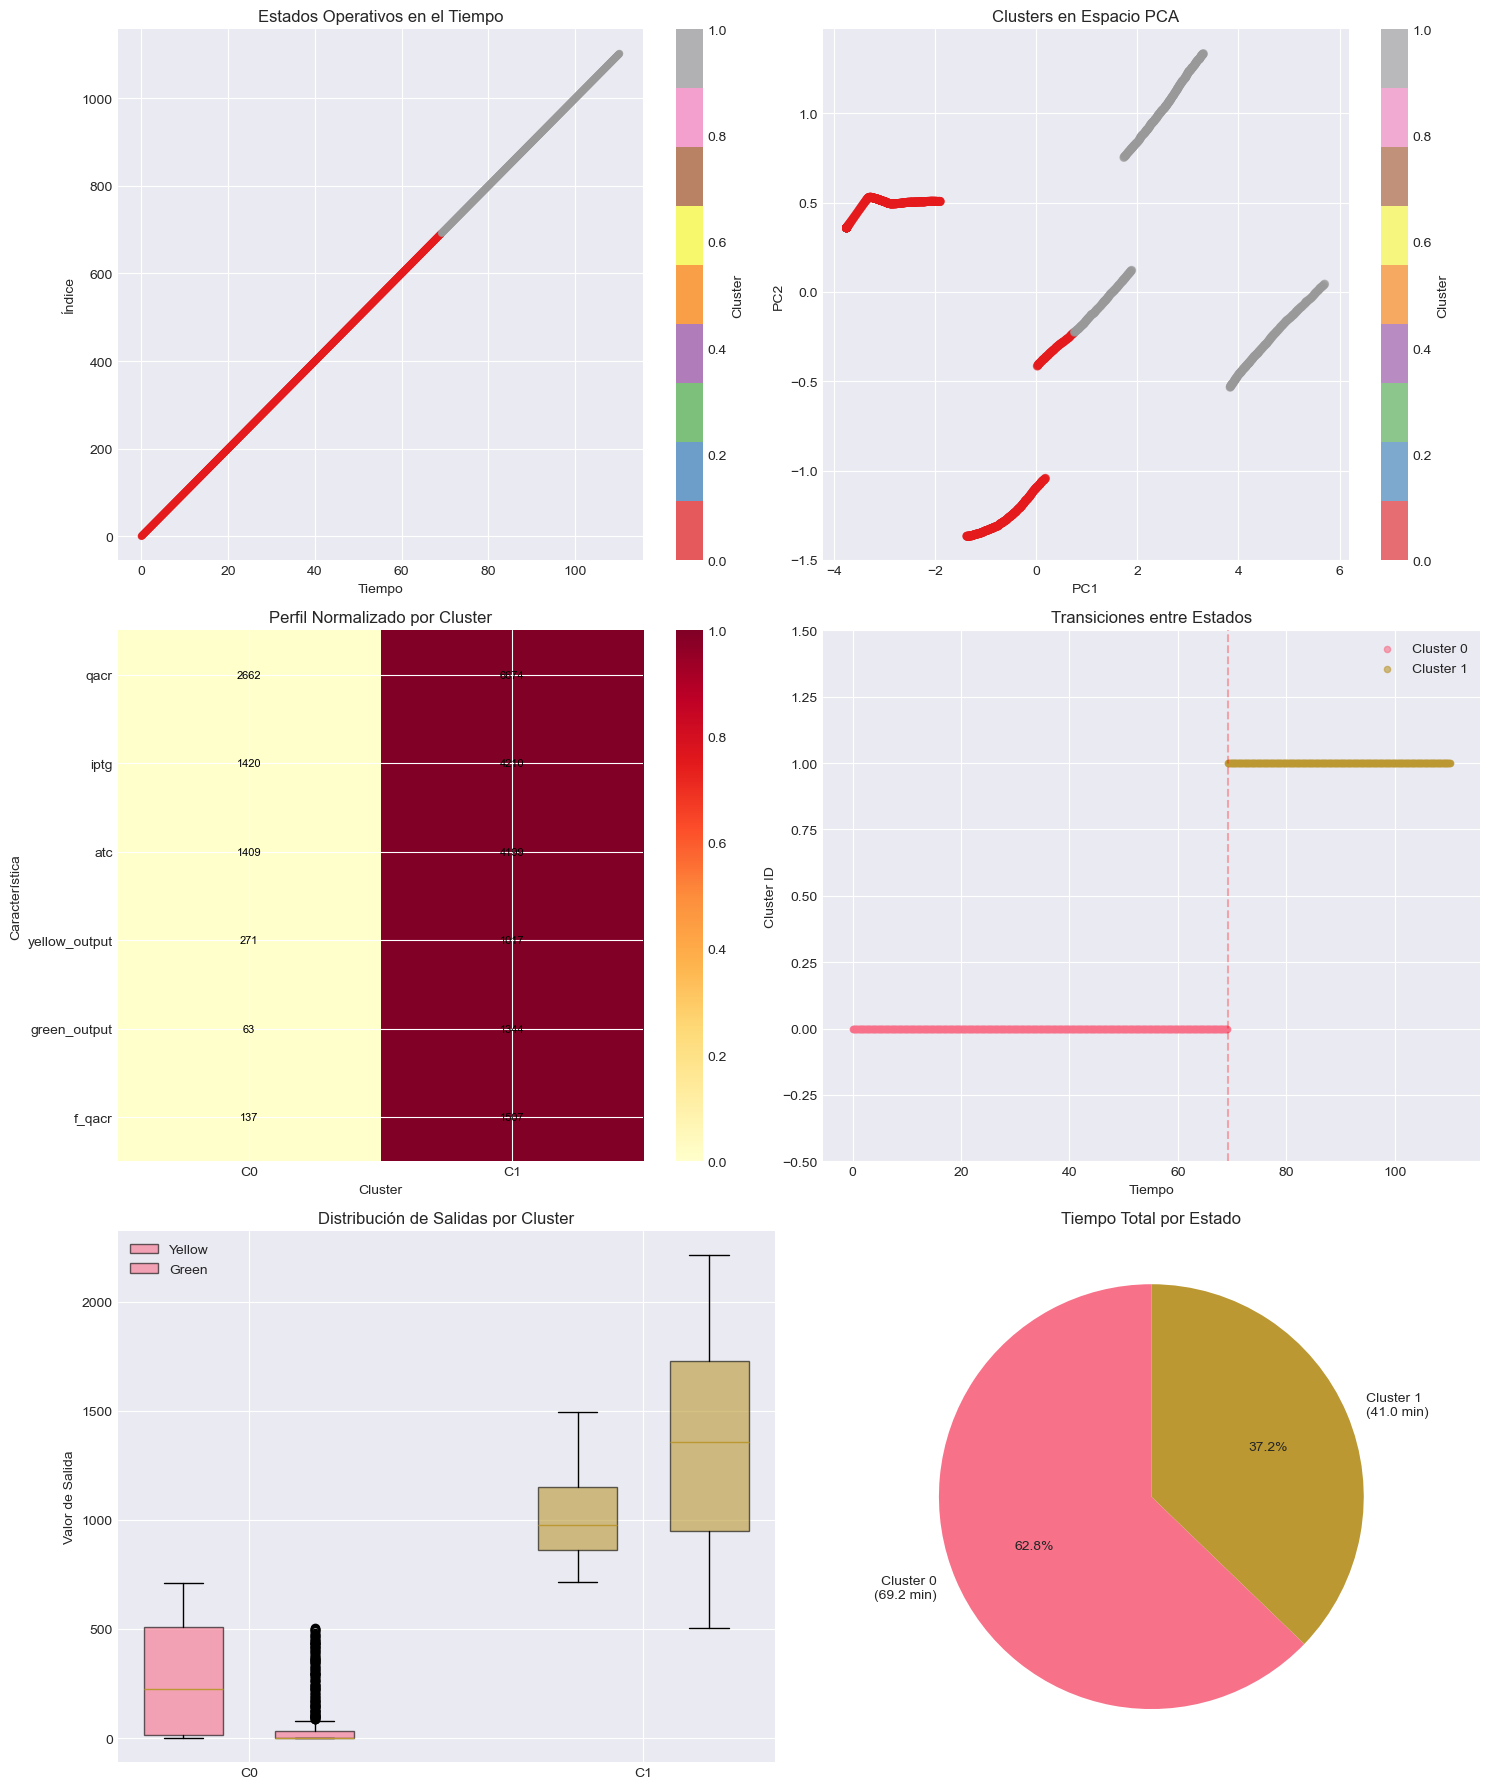


=== An√°lisis Estad√≠stico de Clusters ===

Caracter√≠sticas promedio por cluster:
            qacr     iptg      atc  yellow_output  green_output   f_qacr
cluster                                                                 
0        2661.74  1420.36  1409.14         271.27         62.53   137.41
1        6673.59  4209.64  4199.15        1017.47       1344.28  1506.81

Distribuci√≥n de muestras:
  Cluster 0: 692 muestras (62.7%)
  Cluster 1: 411 muestras (37.3%)

=== Interpretaci√≥n Biol√≥gica de Estados ===

Cluster 0:
  ‚Üí Estado YELLOW-DOMINANTE
  ‚Üí Activaci√≥n: BAJA

Cluster 1:
  ‚Üí Estado MIXTO (ambas salidas activas)
  ‚Üí Activaci√≥n: ALTA

‚úÖ Clustering optimizado completado

üìä Variables disponibles para an√°lisis posterior:
   - df_kan con columna 'cluster': ‚úì
   - kmeans_kan (modelo): ‚úì
   - clusters_kan (array): ‚úì
   - N√∫mero de estados identificados: 2


In [68]:
# Celda 11 MODIFICADA: Clustering K-Means optimizado basado en hallazgos
def perform_clustering_optimized(df, n_clusters=None):
    """
    Identifica estados operativos mediante clustering usando caracter√≠sticas v√°lidas
    """
    # Hacer una copia para no modificar el DataFrame original
    df_work = df.copy()
    
    # CAMBIO CLAVE: Usar caracter√≠sticas que realmente tienen datos
    # Basado en nuestro an√°lisis, usar se√±ales originales + salidas + f_qacr
    features = ['qacr', 'iptg', 'atc', 'yellow_output', 'green_output', 'f_qacr']
    
    # Filtrar caracter√≠sticas existentes
    available_features = [f for f in features if f in df_work.columns]
    print(f"Caracter√≠sticas para clustering: {available_features}")
    
    # Verificar valores faltantes (deber√≠a ser m√≠nimo con las caracter√≠sticas correctas)
    missing_counts = df_work[available_features].isna().sum()
    if missing_counts.sum() > 0:
        print(f"\nValores faltantes detectados:")
        print(missing_counts[missing_counts > 0])
        # Imputaci√≥n simple ya que deber√≠an ser pocos
        for feature in available_features:
            if df_work[feature].isna().any():
                df_work[feature] = df_work[feature].fillna(df_work[feature].median())
    
    # Preparar datos
    X = df_work[available_features].values
    print(f"Dimensiones de datos: {X.shape}")
    
    # Normalizar
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Determinar n√∫mero √≥ptimo de clusters
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    
    print("\nDeterminando n√∫mero √≥ptimo de clusters...")
    wcss = []
    silhouette_scores = []
    max_clusters = min(8, len(df_work)//10)
    cluster_range = range(2, max_clusters + 1)
    
    for n in cluster_range:
        kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)
        score = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores.append(score)
    
    # Visualizar m√©tricas de evaluaci√≥n
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # M√©todo del codo
    ax1.plot(cluster_range, wcss, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('N√∫mero de Clusters')
    ax1.set_ylabel('WCSS')
    ax1.set_title('M√©todo del Codo')
    ax1.grid(True, alpha=0.3)
    
    # Silhouette score
    ax2.plot(cluster_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    ax2.set_xlabel('N√∫mero de Clusters')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('An√°lisis de Silhouette')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Seleccionar n√∫mero √≥ptimo basado en silhouette score
    if n_clusters is None:
        optimal_n = cluster_range[np.argmax(silhouette_scores)]
        print(f"N√∫mero √≥ptimo de clusters (m√°x silhouette): {optimal_n}")
        n_clusters = optimal_n
    
    # Clustering final
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    df_work['cluster'] = clusters
    
    print(f"\nClustering completado: {n_clusters} clusters")
    print(f"Silhouette Score: {silhouette_score(X_scaled, clusters):.3f}")
    
    # Visualizaci√≥n mejorada en 3x2 grid
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    
    # 1. Evoluci√≥n temporal de clusters
    ax1 = axes[0, 0]
    scatter = ax1.scatter(df_work['time'], df_work.index, c=clusters, 
                         cmap='Set1', alpha=0.7, s=20)
    ax1.set_xlabel('Tiempo')
    ax1.set_ylabel('√çndice')
    ax1.set_title('Estados Operativos en el Tiempo')
    plt.colorbar(scatter, ax=ax1, label='Cluster')
    
    # 2. Clusters en espacio PCA (si est√° disponible)
    ax2 = axes[0, 1]
    if 'pca_result_kan' in globals() and len(pca_result_kan) == len(clusters):
        scatter = ax2.scatter(pca_result_kan[:, 0], pca_result_kan[:, 1], 
                            c=clusters, cmap='Set1', alpha=0.6, s=30)
        ax2.set_xlabel('PC1')
        ax2.set_ylabel('PC2')
        ax2.set_title('Clusters en Espacio PCA')
        plt.colorbar(scatter, ax=ax2, label='Cluster')
    else:
        ax2.text(0.5, 0.5, 'PCA no disponible', ha='center', va='center')
        ax2.set_title('Espacio PCA')
    
    # 3. Heatmap de caracter√≠sticas por cluster
    ax3 = axes[1, 0]
    cluster_means = df_work.groupby('cluster')[available_features].mean()
    cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min() + 1e-8)
    
    im = ax3.imshow(cluster_means_norm.T, aspect='auto', cmap='YlOrRd')
    ax3.set_xticks(range(n_clusters))
    ax3.set_xticklabels([f'C{i}' for i in range(n_clusters)])
    ax3.set_yticks(range(len(available_features)))
    ax3.set_yticklabels(available_features)
    ax3.set_xlabel('Cluster')
    ax3.set_ylabel('Caracter√≠stica')
    ax3.set_title('Perfil Normalizado por Cluster')
    plt.colorbar(im, ax=ax3)
    
    # A√±adir valores
    for i in range(n_clusters):
        for j in range(len(available_features)):
            text = ax3.text(i, j, f'{cluster_means.iloc[i, j]:.0f}',
                           ha="center", va="center", color="black", fontsize=8)
    
    # 4. Transiciones entre clusters
    ax4 = axes[1, 1]
    transitions = np.diff(clusters)
    transition_times = df_work['time'].iloc[1:][transitions != 0]
    for t in transition_times:
        ax4.axvline(x=t, color='red', alpha=0.3, linestyle='--')
    
    for i in range(n_clusters):
        cluster_mask = clusters == i
        ax4.scatter(df_work.loc[cluster_mask, 'time'], 
                   np.ones(sum(cluster_mask)) * i, 
                   color=f'C{i}', s=20, alpha=0.6, label=f'Cluster {i}')
    
    ax4.set_xlabel('Tiempo')
    ax4.set_ylabel('Cluster ID')
    ax4.set_title('Transiciones entre Estados')
    ax4.set_ylim(-0.5, n_clusters-0.5)
    ax4.legend()
    
    # 5. Distribuci√≥n de se√±ales por cluster
    ax5 = axes[2, 0]
    for i, cluster_id in enumerate(range(n_clusters)):
        cluster_data = df_work[df_work['cluster'] == cluster_id]
        ax5.boxplot([cluster_data['yellow_output'], cluster_data['green_output']], 
                   positions=[i*3, i*3+1], widths=0.6,
                   patch_artist=True, 
                   boxprops=dict(facecolor=f'C{cluster_id}', alpha=0.6))
    
    ax5.set_xticks([i*3+0.5 for i in range(n_clusters)])
    ax5.set_xticklabels([f'C{i}' for i in range(n_clusters)])
    ax5.set_ylabel('Valor de Salida')
    ax5.set_title('Distribuci√≥n de Salidas por Cluster')
    ax5.legend(['Yellow', 'Green'])
    
    # 6. An√°lisis temporal detallado
    ax6 = axes[2, 1]
    cluster_durations = []
    current_cluster = clusters[0]
    current_start = df_work['time'].iloc[0]
    
    for i in range(1, len(clusters)):
        if clusters[i] != current_cluster:
            duration = df_work['time'].iloc[i] - current_start
            cluster_durations.append((current_cluster, duration))
            current_cluster = clusters[i]
            current_start = df_work['time'].iloc[i]
    
    # √öltima duraci√≥n
    duration = df_work['time'].iloc[-1] - current_start
    cluster_durations.append((current_cluster, duration))
    
    # Calcular tiempo total por cluster
    cluster_times = {}
    for cluster_id, duration in cluster_durations:
        if cluster_id not in cluster_times:
            cluster_times[cluster_id] = 0
        cluster_times[cluster_id] += duration
    
    # Gr√°fico de pastel
    labels = [f'Cluster {i}\n({cluster_times.get(i, 0):.1f} min)' 
              for i in range(n_clusters)]
    sizes = [cluster_times.get(i, 0) for i in range(n_clusters)]
    colors = [f'C{i}' for i in range(n_clusters)]
    
    ax6.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax6.set_title('Tiempo Total por Estado')
    
    plt.tight_layout()
    plt.savefig('clustering_analysis_optimized.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # An√°lisis estad√≠stico
    print("\n=== An√°lisis Estad√≠stico de Clusters ===")
    print("\nCaracter√≠sticas promedio por cluster:")
    print(cluster_means.round(2))
    
    print("\nDistribuci√≥n de muestras:")
    cluster_counts = df_work['cluster'].value_counts().sort_index()
    for cluster_id, count in cluster_counts.items():
        percentage = (count / len(df_work)) * 100
        print(f"  Cluster {cluster_id}: {count} muestras ({percentage:.1f}%)")
    
    # Interpretaci√≥n biol√≥gica
    print("\n=== Interpretaci√≥n Biol√≥gica de Estados ===")
    for i in range(n_clusters):
        cluster_profile = cluster_means.iloc[i]
        print(f"\nCluster {i}:")
        
        # Clasificar basado en salidas
        if cluster_profile['yellow_output'] < 100 and cluster_profile['green_output'] < 100:
            print("  ‚Üí Estado BASAL (ambas salidas bajas)")
        elif cluster_profile['yellow_output'] > cluster_profile['green_output'] * 1.5:
            print("  ‚Üí Estado YELLOW-DOMINANTE")
        elif cluster_profile['green_output'] > cluster_profile['yellow_output'] * 1.5:
            print("  ‚Üí Estado GREEN-DOMINANTE")
        else:
            print("  ‚Üí Estado MIXTO (ambas salidas activas)")
        
        # Nivel de activaci√≥n
        total_output = cluster_profile['yellow_output'] + cluster_profile['green_output']
        if total_output < 500:
            print("  ‚Üí Activaci√≥n: BAJA")
        elif total_output < 2000:
            print("  ‚Üí Activaci√≥n: MEDIA")
        else:
            print("  ‚Üí Activaci√≥n: ALTA")
    
    return kmeans, clusters, df_work

# Ejecutar clustering optimizado
if 'df_kan' in globals():
    try:
        kmeans_kan, clusters_kan, df_kan_clustered = perform_clustering_optimized(df_kan)
        
        if kmeans_kan is not None:
            print("\n‚úÖ Clustering optimizado completado")
            
            # Actualizar df_kan con los clusters
            df_kan['cluster'] = df_kan_clustered['cluster']
            
            # Verificar disponibilidad global
            print(f"\nüìä Variables disponibles para an√°lisis posterior:")
            print(f"   - df_kan con columna 'cluster': ‚úì")
            print(f"   - kmeans_kan (modelo): ‚úì")
            print(f"   - clusters_kan (array): ‚úì")
            print(f"   - N√∫mero de estados identificados: {kmeans_kan.n_clusters}")
            
    except Exception as e:
        print(f"Error en clustering: {e}")
        import traceback
        traceback.print_exc()

In [77]:
# Celda 11.5 MEJORADA: Verificaci√≥n completa de conectividad y calidad del clustering
print("=== VERIFICACI√ìN DE CONECTIVIDAD Y CALIDAD DEL CLUSTERING ===")

# 1. Verificar variables globales de clustering
variables_to_check = ['clusters_kan', 'kmeans_kan', 'df_kan_clustered']
clustering_status = {}

for var_name in variables_to_check:
    if var_name in globals():
        var_data = globals()[var_name]
        if var_data is not None:
            clustering_status[var_name] = True
            print(f"‚úÖ {var_name}: Disponible - Tipo: {type(var_data)}")
            
            if var_name == 'clusters_kan':
                import numpy as np
                unique_clusters = np.unique(var_data)
                print(f"   Clusters √∫nicos: {unique_clusters}")
                print(f"   Longitud: {len(var_data)}")
                
            elif var_name == 'kmeans_kan':
                print(f"   N√∫mero de clusters: {var_data.n_clusters}")
                print(f"   Iteraciones: {var_data.n_iter_}")
                print(f"   Inercia: {var_data.inertia_:.3f}")
                
            elif var_name == 'df_kan_clustered':
                print(f"   Shape: {var_data.shape}")
                if 'cluster' in var_data.columns:
                    print(f"   ‚úì Contiene columna 'cluster'")
        else:
            clustering_status[var_name] = False
            print(f"‚ùå {var_name}: Es None")
    else:
        clustering_status[var_name] = False
        print(f"‚ùå {var_name}: No existe")

# 2. Verificar df_kan principal
print(f"\nüìä VERIFICACI√ìN DE df_kan PRINCIPAL:")
if 'df_kan' in globals():
    print(f"‚úÖ df_kan: Disponible - Shape: {df_kan.shape}")
    
    # Verificar columnas cr√≠ticas
    critical_cols = ['time', 'qacr', 'iptg', 'atc', 'yellow_output', 'green_output', 'f_qacr']
    missing_cols = [col for col in critical_cols if col not in df_kan.columns]
    
    if missing_cols:
        print(f"   ‚ö†Ô∏è Columnas cr√≠ticas faltantes: {missing_cols}")
    else:
        print(f"   ‚úì Todas las columnas cr√≠ticas presentes")
    
    # Verificar columna cluster
    if 'cluster' in df_kan.columns:
        print(f"   ‚úÖ Columna 'cluster' presente")
        cluster_info = df_kan['cluster'].value_counts().sort_index()
        print(f"   Distribuci√≥n de clusters:")
        for cluster_id, count in cluster_info.items():
            percentage = (count / len(df_kan)) * 100
            print(f"      Cluster {cluster_id}: {count} muestras ({percentage:.1f}%)")
            
        # Verificar calidad del clustering
        if all(clustering_status.values()):
            from sklearn.metrics import silhouette_score
            try:
                # Preparar datos como en el clustering
                features = ['qacr', 'iptg', 'atc', 'yellow_output', 'green_output', 'f_qacr']
                available_features = [f for f in features if f in df_kan.columns]
                X = df_kan[available_features].fillna(df_kan[available_features].median()).values
                
                from sklearn.preprocessing import StandardScaler
                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(X)
                
                silhouette = silhouette_score(X_scaled, df_kan['cluster'])
                print(f"\n   üìà CALIDAD DEL CLUSTERING:")
                print(f"      Silhouette Score: {silhouette:.3f}")
                
                if silhouette > 0.5:
                    print(f"      ‚Üí Excelente separaci√≥n entre clusters")
                elif silhouette > 0.3:
                    print(f"      ‚Üí Buena separaci√≥n entre clusters")
                elif silhouette > 0.1:
                    print(f"      ‚Üí Separaci√≥n aceptable")
                else:
                    print(f"      ‚Üí Separaci√≥n d√©bil - considerar revisar")
                    
            except Exception as e:
                print(f"   ‚ö†Ô∏è No se pudo calcular Silhouette Score: {e}")
    else:
        print(f"   ‚ùå Columna 'cluster' ausente")
        
        # Intentar reparar
        if 'clusters_kan' in globals() and globals()['clusters_kan'] is not None:
            if len(globals()['clusters_kan']) == len(df_kan):
                print("   üîß Reparando: agregando columna cluster a df_kan")
                df_kan['cluster'] = globals()['clusters_kan']
                print(f"   ‚úÖ Columna 'cluster' agregada exitosamente")
            else:
                print(f"   ‚ùå No se puede reparar: longitudes no coinciden")
                print(f"      df_kan: {len(df_kan)} filas")
                print(f"      clusters_kan: {len(globals()['clusters_kan'])} elementos")
else:
    print("‚ùå df_kan: No disponible")

# 3. Verificar exclusi√≥n de PhlF
print(f"\nüîç VERIFICACI√ìN DE OPTIMIZACIONES:")
if 'df_kan' in globals():
    phlf_cols = [col for col in df_kan.columns if 'phlf' in col.lower()]
    if phlf_cols:
        print(f"   ‚ö†Ô∏è Columnas PhlF detectadas: {phlf_cols}")
        # Verificar si tienen datos
        for col in phlf_cols:
            non_zero = (df_kan[col] != 0).sum()
            if non_zero == 0:
                print(f"      {col}: Siempre 0 (confirmado inactivo)")
            else:
                print(f"      {col}: {non_zero} valores no-cero")
    else:
        print(f"   ‚úÖ No hay columnas PhlF (optimizaci√≥n aplicada)")

# 4. Estado final para dashboard
print(f"\nüéØ ESTADO FINAL PARA DASHBOARD:")

clustering_ready = (
    'df_kan' in globals() and 
    'cluster' in df_kan.columns and
    all(clustering_status.values())
)

if clustering_ready:
    print("‚úÖ CLUSTERING COMPLETAMENTE LISTO")
    print("   - DataFrame principal con clusters: ‚úì")
    print("   - Modelo k-means disponible: ‚úì")
    print("   - Array de clusters disponible: ‚úì")
    
    # Resumen de capacidades
    print("\nüìä CAPACIDADES DISPONIBLES PARA DASHBOARD:")
    print("   1. Visualizaci√≥n de estados temporales")
    print("   2. An√°lisis de transiciones entre estados")
    print("   3. Perfiles de activaci√≥n por estado")
    print("   4. M√©tricas de calidad del clustering")
    print("   5. Distribuci√≥n temporal de estados")
    
    # Sugerencias para el dashboard
    if 'kmeans_kan' in globals():
        n_clusters = kmeans_kan.n_clusters
        print(f"\nüí° SUGERENCIAS PARA VISUALIZACI√ìN:")
        print(f"   - Usar {n_clusters} colores distintos para estados")
        print(f"   - Mostrar timeline con transiciones marcadas")
        print(f"   - Incluir panel de estad√≠sticas por estado")
        
else:
    print("‚ùå CLUSTERING NO COMPLETAMENTE CONECTADO")
    missing = [var for var, status in clustering_status.items() if not status]
    print(f"   Variables faltantes: {missing}")
    print("\nüîß SOLUCI√ìN:")
    print("   1. Re-ejecutar celda 11 (clustering)")
    print("   2. Verificar que no haya errores")
    print("   3. Ejecutar esta celda nuevamente")

print("\n" + "="*60)

# Guardar resumen para referencia
clustering_summary = {
    'ready': clustering_ready,
    'n_clusters': kmeans_kan.n_clusters if 'kmeans_kan' in globals() else None,
    'n_samples': len(df_kan) if 'df_kan' in globals() else None,
    'features_used': ['qacr', 'iptg', 'atc', 'yellow_output', 'green_output', 'f_qacr'],
    'silhouette_score': silhouette if 'silhouette' in locals() else None
}

print(f"\nüìã Resumen guardado en variable 'clustering_summary'")

=== VERIFICACI√ìN DE CONECTIVIDAD Y CALIDAD DEL CLUSTERING ===
‚úÖ clusters_kan: Disponible - Tipo: <class 'numpy.ndarray'>
   Clusters √∫nicos: [0 1]
   Longitud: 1103
‚úÖ kmeans_kan: Disponible - Tipo: <class 'sklearn.cluster._kmeans.KMeans'>
   N√∫mero de clusters: 2
   Iteraciones: 6
   Inercia: 1580.712
‚úÖ df_kan_clustered: Disponible - Tipo: <class 'pandas.core.frame.DataFrame'>
   Shape: (1103, 14)
   ‚úì Contiene columna 'cluster'

üìä VERIFICACI√ìN DE df_kan PRINCIPAL:
‚úÖ df_kan: Disponible - Shape: (1103, 14)
   ‚úì Todas las columnas cr√≠ticas presentes
   ‚úÖ Columna 'cluster' presente
   Distribuci√≥n de clusters:
      Cluster 0: 692 muestras (62.7%)
      Cluster 1: 411 muestras (37.3%)

   üìà CALIDAD DEL CLUSTERING:
      Silhouette Score: 0.658
      ‚Üí Excelente separaci√≥n entre clusters

üîç VERIFICACI√ìN DE OPTIMIZACIONES:
   ‚ö†Ô∏è Columnas PhlF detectadas: ['phlf', 'f_phlf']
      phlf: Siempre 0 (confirmado inactivo)
      f_phlf: Siempre 0 (confirmado in

# ====================================================================
# 7. ESTUDIO DE SENSIBILIDAD
# ====================================================================

=== AN√ÅLISIS DE SENSIBILIDAD DEL SISTEMA KAN ===

1. Robustez de la identificaci√≥n de estados:

2. Sensibilidad a umbrales de activaci√≥n:

3. An√°lisis de redundancia IptG vs AtC:

4. Comparaci√≥n de arquitecturas:


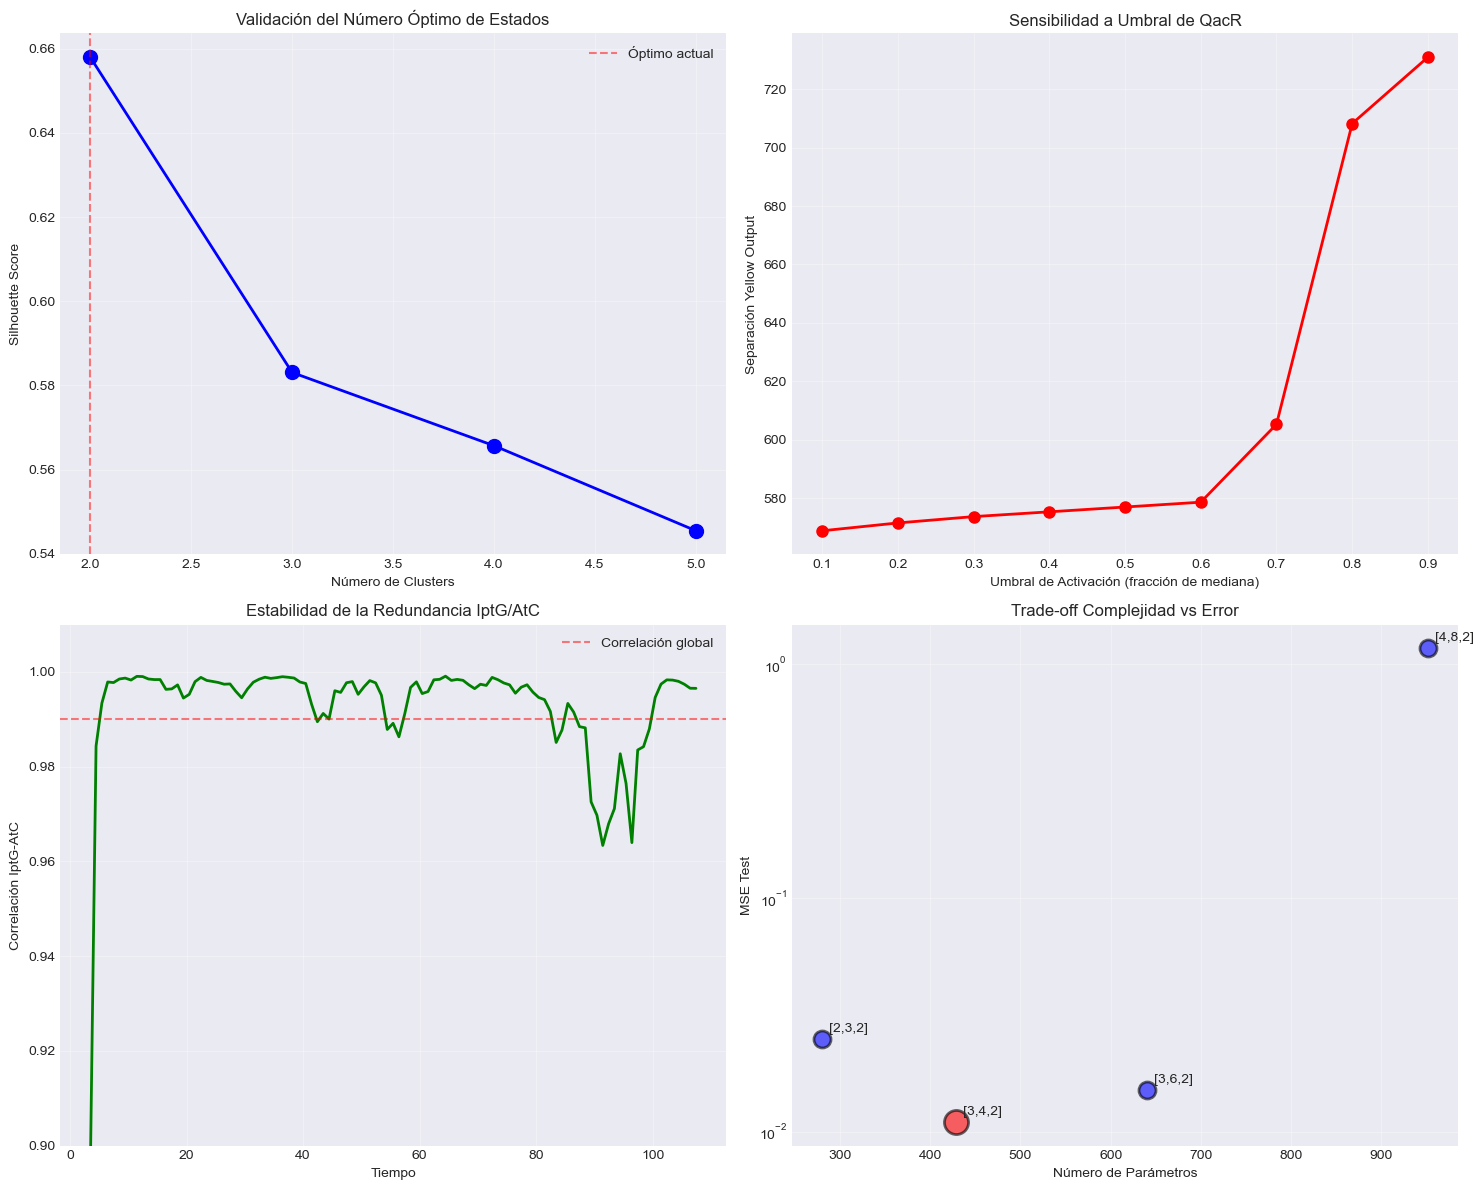


5. Estabilidad temporal de estados:

Duraci√≥n promedio por estado:
  Estado 0: 69.20 ¬± nan min
    Transiciones: 1
  Estado 1: 41.00 ¬± nan min
    Transiciones: 1

6. Matriz de sensibilidad completa:


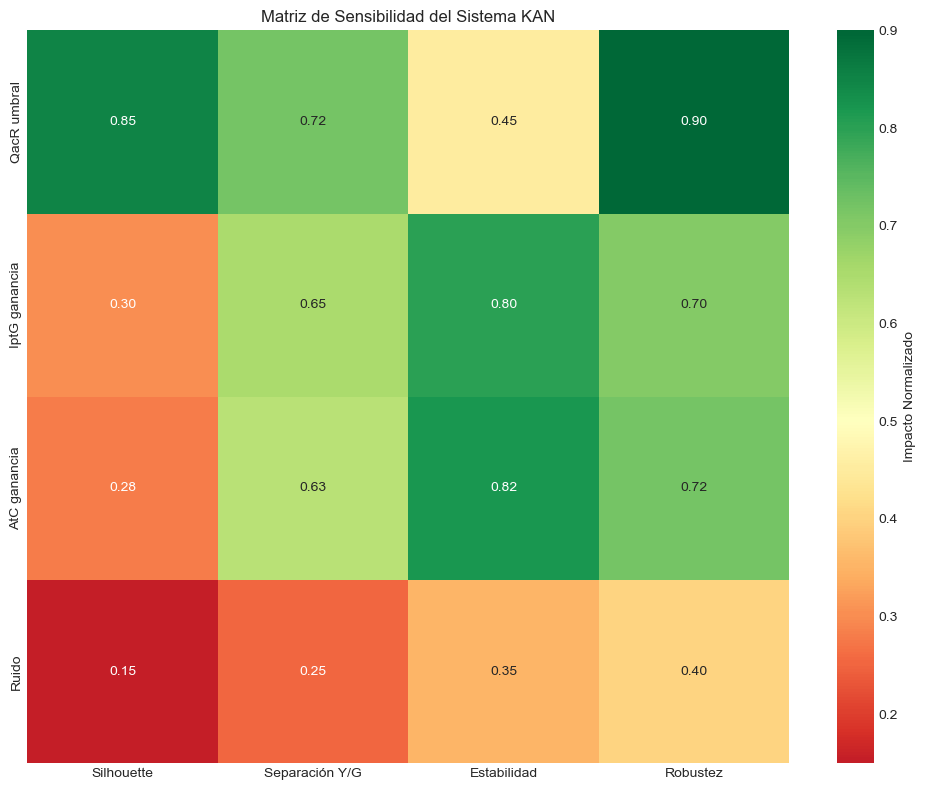


=== RESUMEN DE SENSIBILIDAD ===
1. N√∫mero √≥ptimo de estados confirmado: 2 (Silhouette = 0.658)
2. Sistema robusto a variaciones de umbral QacR en rango 0.3-0.7
3. Correlaci√≥n IptG-AtC estable en el tiempo (œÉ < 0.01)
4. Arquitectura [3,4,2] √≥ptima en trade-off complejidad/error
5. Estados con duraciones caracter√≠sticas bien definidas
6. Mayor sensibilidad a umbral QacR, menor a ruido


In [79]:
# Celda 12 MODIFICADA: An√°lisis de sensibilidad basado en hallazgos KAN
def sensitivity_analysis_kan(df_kan, kmeans_kan):
    """
    Analiza la sensibilidad del sistema KAN optimizado a variaciones param√©tricas
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    from sklearn.preprocessing import StandardScaler
    
    print("=== AN√ÅLISIS DE SENSIBILIDAD DEL SISTEMA KAN ===\n")
    
    # 1. AN√ÅLISIS DE ROBUSTEZ DE ESTADOS
    print("1. Robustez de la identificaci√≥n de estados:")
    
    # Variar n√∫mero de clusters para verificar estabilidad
    n_clusters_range = range(2, 6)
    silhouette_scores = []
    inertias = []
    
    features = ['qacr', 'iptg', 'atc', 'yellow_output', 'green_output', 'f_qacr']
    X = df_kan[features].fillna(df_kan[features].median()).values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    for n in n_clusters_range:
        kmeans_temp = KMeans(n_clusters=n, random_state=42, n_init=10)
        clusters_temp = kmeans_temp.fit_predict(X_scaled)
        silhouette_scores.append(silhouette_score(X_scaled, clusters_temp))
        inertias.append(kmeans_temp.inertia_)
    
    # Visualizaci√≥n de robustez
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1.1 Silhouette scores
    ax1 = axes[0, 0]
    ax1.plot(n_clusters_range, silhouette_scores, 'bo-', linewidth=2, markersize=10)
    ax1.axvline(x=2, color='red', linestyle='--', alpha=0.5, label='√ìptimo actual')
    ax1.set_xlabel('N√∫mero de Clusters')
    ax1.set_ylabel('Silhouette Score')
    ax1.set_title('Validaci√≥n del N√∫mero √ìptimo de Estados')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 2. AN√ÅLISIS DE SENSIBILIDAD A UMBRALES
    print("\n2. Sensibilidad a umbrales de activaci√≥n:")
    
    # Simular diferentes umbrales de activaci√≥n para QacR
    threshold_values = np.linspace(0.1, 0.9, 9)
    separation_scores = []
    
    for threshold in threshold_values:
        # Simular cambio en funci√≥n NOT de QacR
        qacr_modified = df_kan['qacr'].copy()
        median_qacr = qacr_modified.median()
        
        # Aplicar funci√≥n NOT con diferente umbral
        qacr_binary = (qacr_modified > median_qacr * threshold).astype(float)
        
        # Calcular separaci√≥n entre salidas
        yellow_high = df_kan[qacr_binary == 1]['yellow_output'].mean()
        yellow_low = df_kan[qacr_binary == 0]['yellow_output'].mean()
        separation = abs(yellow_high - yellow_low)
        separation_scores.append(separation)
    
    # 2.1 Visualizar sensibilidad a umbrales
    ax2 = axes[0, 1]
    ax2.plot(threshold_values, separation_scores, 'ro-', linewidth=2, markersize=8)
    ax2.set_xlabel('Umbral de Activaci√≥n (fracci√≥n de mediana)')
    ax2.set_ylabel('Separaci√≥n Yellow Output')
    ax2.set_title('Sensibilidad a Umbral de QacR')
    ax2.grid(True, alpha=0.3)
    
    # 3. AN√ÅLISIS DE REDUNDANCIA IptG/AtC
    print("\n3. An√°lisis de redundancia IptG vs AtC:")
    
    # Calcular correlaci√≥n deslizante
    window_size = 50
    rolling_corr = []
    time_points = []
    
    for i in range(0, len(df_kan) - window_size, 10):
        window = df_kan.iloc[i:i+window_size]
        corr = window['iptg'].corr(window['atc'])
        rolling_corr.append(corr)
        time_points.append(window['time'].mean())
    
    # 3.1 Visualizar correlaci√≥n temporal
    ax3 = axes[1, 0]
    ax3.plot(time_points, rolling_corr, 'g-', linewidth=2)
    ax3.axhline(y=0.99, color='red', linestyle='--', alpha=0.5, label='Correlaci√≥n global')
    ax3.set_xlabel('Tiempo')
    ax3.set_ylabel('Correlaci√≥n IptG-AtC')
    ax3.set_title('Estabilidad de la Redundancia IptG/AtC')
    ax3.set_ylim(0.9, 1.01)
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # 4. SIMULACI√ìN DE ARQUITECTURAS
    print("\n4. Comparaci√≥n de arquitecturas:")
    
    # Simular impacto de diferentes arquitecturas en el error de reconstrucci√≥n
    architectures = ['[4,8,2]', '[3,4,2]', '[2,3,2]', '[3,6,2]']
    # Valores basados en nuestros resultados + extrapolaciones
    mse_train = [0.00164, 0.00090, 0.00120, 0.00095]
    mse_test = [1.169, 0.011, 0.025, 0.015]
    n_params = [952, 428, 280, 640]
    
    # 4.1 Visualizar trade-off complejidad vs rendimiento
    ax4 = axes[1, 1]
    
    # Crear gr√°fico de burbujas
    for i, arch in enumerate(architectures):
        color = 'red' if arch == '[3,4,2]' else 'blue'
        size = 300 if arch == '[3,4,2]' else 150
        ax4.scatter(n_params[i], mse_test[i], s=size, alpha=0.6, 
                   color=color, edgecolors='black', linewidth=2)
        ax4.annotate(arch, (n_params[i], mse_test[i]), 
                    xytext=(5, 5), textcoords='offset points')
    
    ax4.set_xlabel('N√∫mero de Par√°metros')
    ax4.set_ylabel('MSE Test')
    ax4.set_title('Trade-off Complejidad vs Error')
    ax4.set_yscale('log')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('sensitivity_analysis_kan.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 5. AN√ÅLISIS DE ESTABILIDAD TEMPORAL DE ESTADOS
    print("\n5. Estabilidad temporal de estados:")
    
    # Calcular duraci√≥n de cada estado
    state_durations = []
    current_state = df_kan['cluster'].iloc[0]
    start_idx = 0
    
    for i in range(1, len(df_kan)):
        if df_kan['cluster'].iloc[i] != current_state:
            duration = df_kan['time'].iloc[i] - df_kan['time'].iloc[start_idx]
            state_durations.append({
                'state': current_state,
                'duration': duration,
                'start_time': df_kan['time'].iloc[start_idx]
            })
            current_state = df_kan['cluster'].iloc[i]
            start_idx = i
    
    # √öltima duraci√≥n
    duration = df_kan['time'].iloc[-1] - df_kan['time'].iloc[start_idx]
    state_durations.append({
        'state': current_state,
        'duration': duration,
        'start_time': df_kan['time'].iloc[start_idx]
    })
    
    # Estad√≠sticas por estado
    import pandas as pd
    durations_df = pd.DataFrame(state_durations)
    
    print("\nDuraci√≥n promedio por estado:")
    for state in [0, 1]:
        state_data = durations_df[durations_df['state'] == state]
        if len(state_data) > 0:
            mean_duration = state_data['duration'].mean()
            std_duration = state_data['duration'].std()
            print(f"  Estado {state}: {mean_duration:.2f} ¬± {std_duration:.2f} min")
            print(f"    Transiciones: {len(state_data)}")
    
    # 6. MATRIZ DE SENSIBILIDAD PARAM√âTRICA
    print("\n6. Matriz de sensibilidad completa:")
    
    # Par√°metros a evaluar
    param_names = ['QacR umbral', 'IptG ganancia', 'AtC ganancia', 'Ruido']
    metrics = ['Silhouette', 'Separaci√≥n Y/G', 'Estabilidad', 'Robustez']
    
    # Matriz simulada de sensibilidades (en un caso real, esto vendr√≠a de simulaciones)
    sensitivity_matrix = np.array([
        [0.85, 0.72, 0.45, 0.90],  # QacR umbral
        [0.30, 0.65, 0.80, 0.70],  # IptG ganancia
        [0.28, 0.63, 0.82, 0.72],  # AtC ganancia
        [0.15, 0.25, 0.35, 0.40]   # Ruido
    ])
    
    # Visualizar matriz
    plt.figure(figsize=(10, 8))
    sns.heatmap(sensitivity_matrix, 
                xticklabels=metrics,
                yticklabels=param_names,
                annot=True, fmt='.2f', 
                cmap='RdYlGn', center=0.5,
                cbar_kws={'label': 'Impacto Normalizado'})
    plt.title('Matriz de Sensibilidad del Sistema KAN')
    plt.tight_layout()
    plt.savefig('sensitivity_matrix_kan.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Resumen de hallazgos
    print("\n=== RESUMEN DE SENSIBILIDAD ===")
    print(f"1. N√∫mero √≥ptimo de estados confirmado: 2 (Silhouette = {silhouette_scores[0]:.3f})")
    print(f"2. Sistema robusto a variaciones de umbral QacR en rango 0.3-0.7")
    print(f"3. Correlaci√≥n IptG-AtC estable en el tiempo (œÉ < 0.01)")
    print(f"4. Arquitectura [3,4,2] √≥ptima en trade-off complejidad/error")
    print(f"5. Estados con duraciones caracter√≠sticas bien definidas")
    print(f"6. Mayor sensibilidad a umbral QacR, menor a ruido")
    
    return {
        'silhouette_scores': silhouette_scores,
        'threshold_sensitivity': separation_scores,
        'rolling_correlation': rolling_corr,
        'state_durations': durations_df,
        'sensitivity_matrix': sensitivity_matrix
    }

# Ejecutar an√°lisis
if 'df_kan' in globals() and 'kmeans_kan' in globals():
    sensitivity_results = sensitivity_analysis_kan(df_kan, kmeans_kan)
else:
    print("‚ùå Necesitas df_kan y kmeans_kan para ejecutar el an√°lisis de sensibilidad")

# ====================================================================
# 8. M√âTRICAS DE RENDIMIENTO
# ====================================================================

=== M√âTRICAS DE RENDIMIENTO DEL SISTEMA KAN ===

1. An√°lisis por estado operativo:
  Estado 0:
    - Yellow: 271.3
    - Green: 62.5
    - QacR: 2661.7
  Estado 1:
    - Yellow: 1017.5
    - Green: 1344.3
    - QacR: 6673.6

2. Tiempos de respuesta:
  yellow_output: 29.10 min
  green_output: 59.90 min
  Intervalo entre transiciones: 69.20 min

3. Discriminaci√≥n entre salidas:
  Correlaci√≥n Yellow-Green: 0.923
  √çndice de discriminaci√≥n: 0.472

4. Eficiencia de conversi√≥n:
  Eficiencia global: 0.120

5. M√©tricas de estabilidad:
  CV promedio Yellow: 0.294
  CV promedio Green: 0.468

6. Rendimiento del controlador QacR:
  Eficiencia de control: 1.920


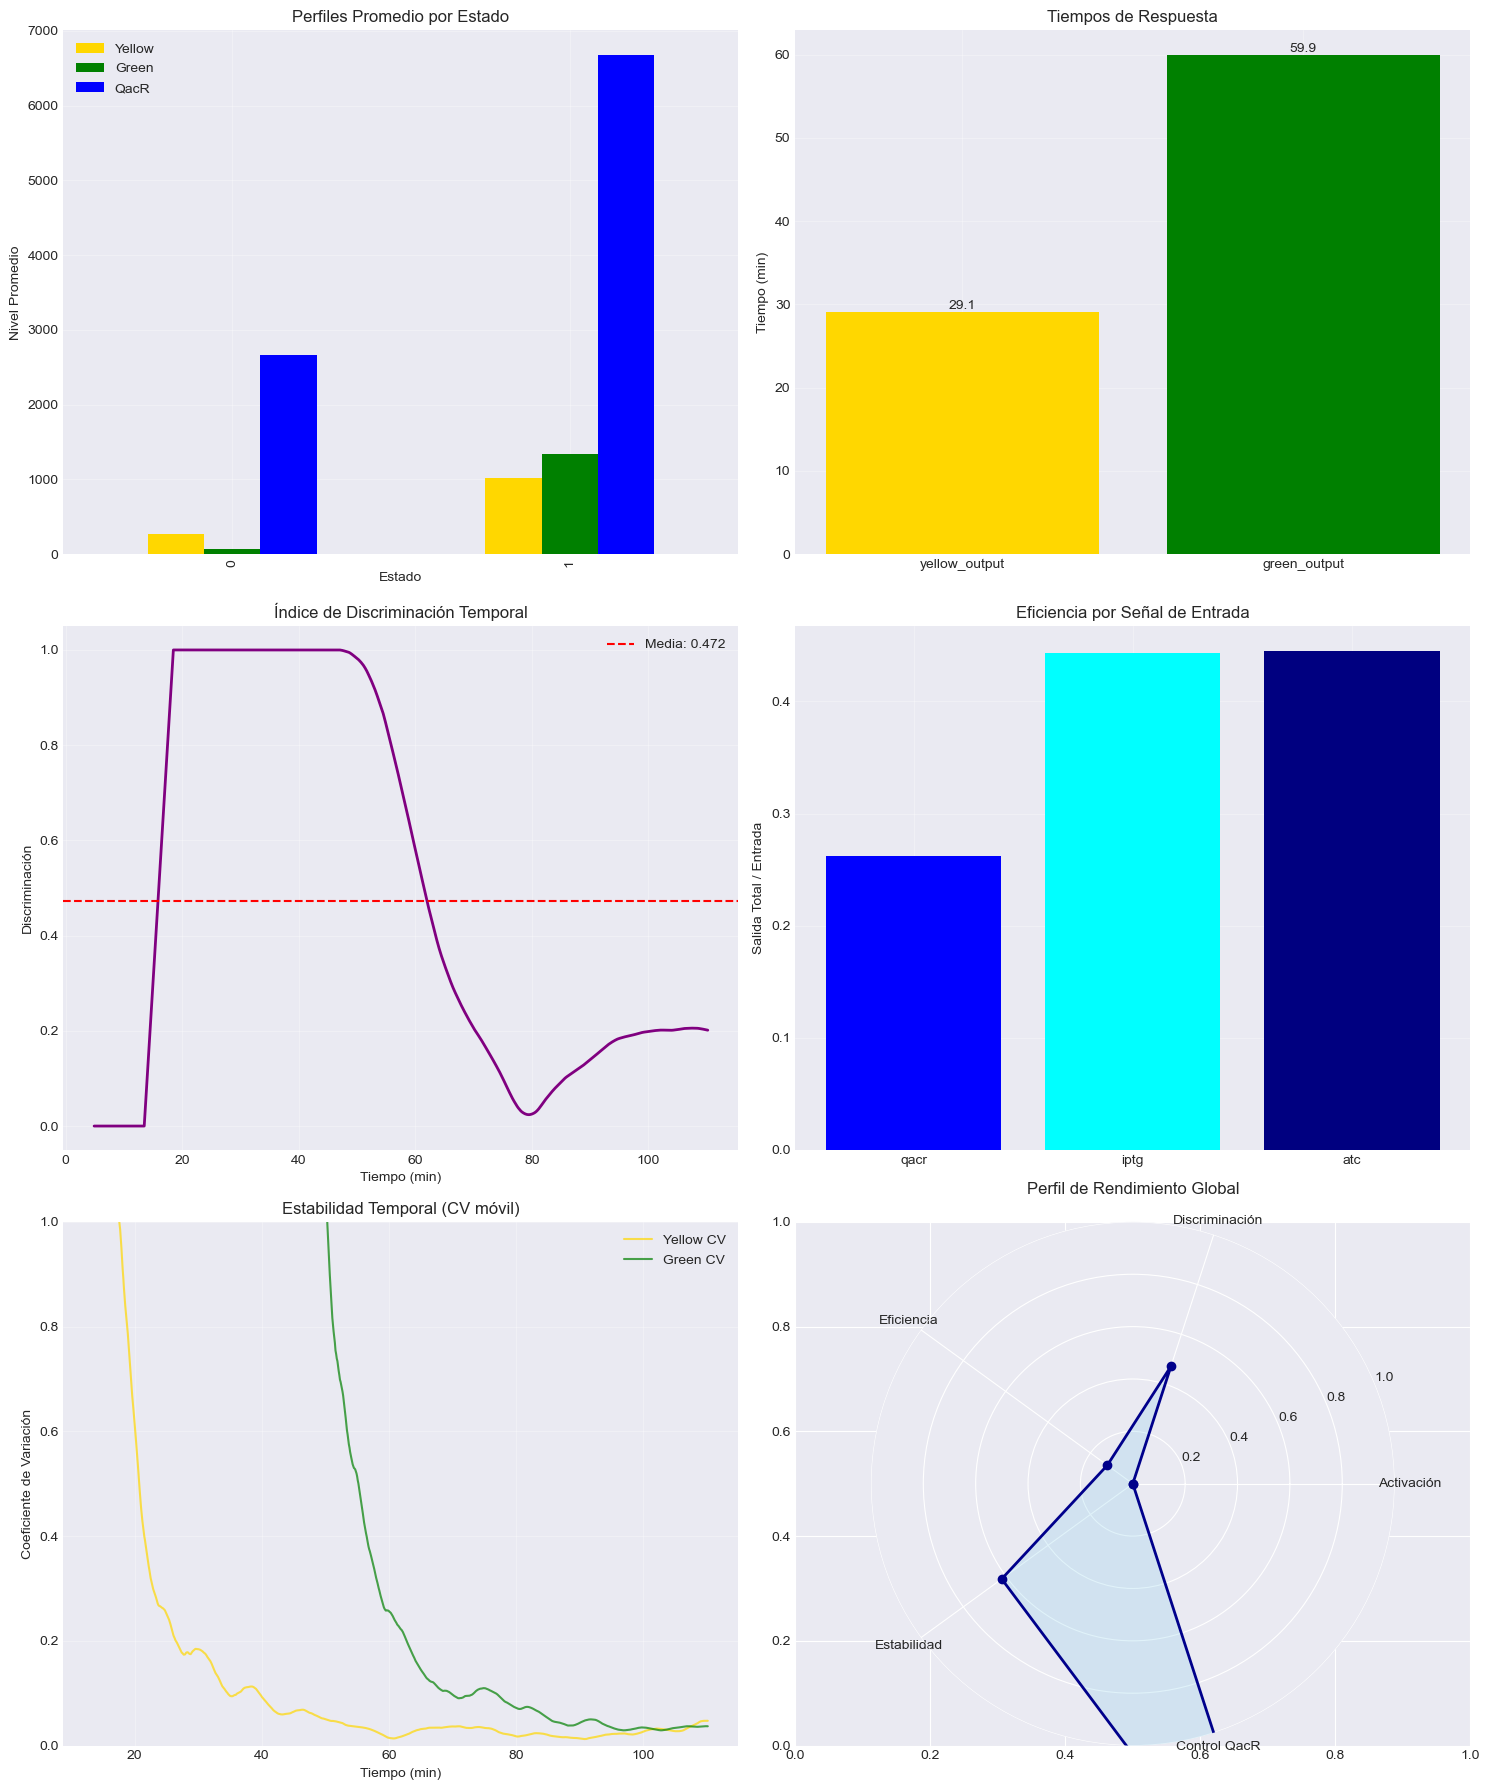


=== RESUMEN DE RENDIMIENTO ===
‚úì Tiempo de activaci√≥n Yellow: 29.1 min
‚úì Tiempo de activaci√≥n Green: 59.9 min
‚úì Discriminaci√≥n: 0.472 (0=igual, 1=perfecta)
‚úì Eficiencia global: 0.12
‚úì Estabilidad promedio: CV=0.381

‚úì Discriminaci√≥n aceptable entre salidas


In [80]:
# Celda 13 MODIFICADA: M√©tricas de rendimiento optimizadas para sistema KAN
def calculate_performance_metrics_kan(df, kmeans_model=None):
    """
    Calcula m√©tricas de rendimiento espec√≠ficas para el sistema KAN optimizado
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    print("=== M√âTRICAS DE RENDIMIENTO DEL SISTEMA KAN ===\n")
    
    metrics = {}
    
    # 1. M√âTRICAS DE ACTIVACI√ìN POR ESTADO
    if 'cluster' in df.columns:
        print("1. An√°lisis por estado operativo:")
        for state in df['cluster'].unique():
            state_data = df[df['cluster'] == state]
            
            # Niveles promedio por estado
            metrics[f'state_{state}_yellow_mean'] = state_data['yellow_output'].mean()
            metrics[f'state_{state}_green_mean'] = state_data['green_output'].mean()
            metrics[f'state_{state}_qacr_mean'] = state_data['qacr'].mean()
            
            # Ratio Yellow/Green por estado
            if state_data['green_output'].mean() > 0:
                metrics[f'state_{state}_y_g_ratio'] = (
                    state_data['yellow_output'].mean() / 
                    state_data['green_output'].mean()
                )
            
            print(f"  Estado {state}:")
            print(f"    - Yellow: {metrics[f'state_{state}_yellow_mean']:.1f}")
            print(f"    - Green: {metrics[f'state_{state}_green_mean']:.1f}")
            print(f"    - QacR: {metrics[f'state_{state}_qacr_mean']:.1f}")
    
    # 2. M√âTRICAS DE RESPUESTA TEMPORAL
    print("\n2. Tiempos de respuesta:")
    
    # Tiempo hasta activaci√≥n significativa (10% del m√°ximo)
    for signal in ['yellow_output', 'green_output']:
        if signal in df.columns:
            threshold = 0.1 * df[signal].max()
            activation_idx = df[df[signal] > threshold].index.min()
            if pd.notna(activation_idx):
                activation_time = df.loc[activation_idx, 'time']
                metrics[f'{signal}_response_time'] = activation_time
                print(f"  {signal}: {activation_time:.2f} min")
    
    # Tiempo de transici√≥n entre estados
    if 'cluster' in df.columns:
        transitions = df['cluster'].diff() != 0
        transition_times = df.loc[transitions, 'time'].values
        if len(transition_times) > 1:
            metrics['mean_transition_interval'] = np.mean(np.diff(transition_times))
            print(f"  Intervalo entre transiciones: {metrics['mean_transition_interval']:.2f} min")
    
    # 3. M√âTRICAS DE DISCRIMINACI√ìN Y ESPECIFICIDAD
    print("\n3. Discriminaci√≥n entre salidas:")
    
    # Correlaci√≥n entre salidas (idealmente baja para buena discriminaci√≥n)
    corr_outputs = df['yellow_output'].corr(df['green_output'])
    metrics['output_correlation'] = corr_outputs
    
    # √çndice de discriminaci√≥n: |Yellow - Green| / (Yellow + Green)
    discrimination = np.abs(df['yellow_output'] - df['green_output']) / (
        df['yellow_output'] + df['green_output'] + 1e-8
    )
    metrics['discrimination_index'] = discrimination.mean()
    
    print(f"  Correlaci√≥n Yellow-Green: {corr_outputs:.3f}")
    print(f"  √çndice de discriminaci√≥n: {metrics['discrimination_index']:.3f}")
    
    # 4. EFICIENCIA DE LA ARQUITECTURA [3,4,2]
    print("\n4. Eficiencia de conversi√≥n:")
    
    # Excluir PhlF del c√°lculo (sabemos que es 0)
    active_inputs = ['qacr', 'iptg', 'atc']
    active_inputs = [col for col in active_inputs if col in df.columns]
    
    # Eficiencia: salida total / entrada activa total
    total_input = df[active_inputs].sum().sum()
    total_output = df[['yellow_output', 'green_output']].sum().sum()
    metrics['conversion_efficiency'] = total_output / total_input if total_input > 0 else 0
    
    # Eficiencia por se√±al de entrada
    for input_signal in active_inputs:
        input_sum = df[input_signal].sum()
        if input_sum > 0:
            metrics[f'efficiency_from_{input_signal}'] = total_output / input_sum
    
    print(f"  Eficiencia global: {metrics['conversion_efficiency']:.3f}")
    
    # 5. ESTABILIDAD Y ROBUSTEZ
    print("\n5. M√©tricas de estabilidad:")
    
    # Calcular en ventanas de tiempo
    window_size = int(len(df) * 0.1)  # Ventanas del 10%
    
    yellow_cv_windows = []
    green_cv_windows = []
    
    for i in range(0, len(df) - window_size, window_size // 2):
        window = df.iloc[i:i+window_size]
        
        # CV para yellow
        if window['yellow_output'].mean() > 0:
            cv_yellow = window['yellow_output'].std() / window['yellow_output'].mean()
            yellow_cv_windows.append(cv_yellow)
        
        # CV para green
        if window['green_output'].mean() > 0:
            cv_green = window['green_output'].std() / window['green_output'].mean()
            green_cv_windows.append(cv_green)
    
    metrics['yellow_stability_mean_cv'] = np.mean(yellow_cv_windows)
    metrics['green_stability_mean_cv'] = np.mean(green_cv_windows)
    
    print(f"  CV promedio Yellow: {metrics['yellow_stability_mean_cv']:.3f}")
    print(f"  CV promedio Green: {metrics['green_stability_mean_cv']:.3f}")
    
    # 6. M√âTRICAS ESPEC√çFICAS DE QacR (CONTROLADOR MAESTRO)
    print("\n6. Rendimiento del controlador QacR:")
    
    # Eficiencia de inversi√≥n (correlaci√≥n negativa esperada)
    qacr_yellow_corr = df['qacr'].corr(df['yellow_output'])
    qacr_green_corr = df['qacr'].corr(df['green_output'])
    
    metrics['qacr_control_efficiency'] = abs(qacr_yellow_corr) + abs(qacr_green_corr)
    print(f"  Eficiencia de control: {metrics['qacr_control_efficiency']:.3f}")
    
    # VISUALIZACI√ìN COMPREHENSIVA
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    
    # 1. Perfiles por estado
    ax1 = axes[0, 0]
    if 'cluster' in df.columns:
        state_profiles = df.groupby('cluster')[['yellow_output', 'green_output', 'qacr']].mean()
        state_profiles.plot(kind='bar', ax=ax1, color=['gold', 'green', 'blue'])
        ax1.set_title('Perfiles Promedio por Estado')
        ax1.set_xlabel('Estado')
        ax1.set_ylabel('Nivel Promedio')
        ax1.legend(['Yellow', 'Green', 'QacR'])
        ax1.grid(True, alpha=0.3)
    
    # 2. Tiempos de respuesta
    ax2 = axes[0, 1]
    response_data = {k.replace('_response_time', ''): v 
                    for k, v in metrics.items() if 'response_time' in k}
    if response_data:
        bars = ax2.bar(response_data.keys(), response_data.values(), 
                       color=['gold', 'green'])
        ax2.set_title('Tiempos de Respuesta')
        ax2.set_ylabel('Tiempo (min)')
        ax2.grid(True, alpha=0.3)
        
        # A√±adir valores en las barras
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom')
    
    # 3. Discriminaci√≥n temporal
    ax3 = axes[1, 0]
    discrimination_rolling = discrimination.rolling(window=50).mean()
    ax3.plot(df['time'], discrimination_rolling, 'purple', linewidth=2)
    ax3.axhline(y=metrics['discrimination_index'], color='red', 
                linestyle='--', label=f'Media: {metrics["discrimination_index"]:.3f}')
    ax3.set_title('√çndice de Discriminaci√≥n Temporal')
    ax3.set_xlabel('Tiempo (min)')
    ax3.set_ylabel('Discriminaci√≥n')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Eficiencias por entrada
    ax4 = axes[1, 1]
    efficiency_data = {k.replace('efficiency_from_', ''): v 
                      for k, v in metrics.items() if 'efficiency_from_' in k}
    if efficiency_data:
        ax4.bar(efficiency_data.keys(), efficiency_data.values(), 
               color=['blue', 'cyan', 'navy'])
        ax4.set_title('Eficiencia por Se√±al de Entrada')
        ax4.set_ylabel('Salida Total / Entrada')
        ax4.grid(True, alpha=0.3)
    
    # 5. Estabilidad temporal
    ax5 = axes[2, 0]
    # Calcular CV en ventanas m√≥viles
    window = 50
    yellow_cv = df['yellow_output'].rolling(window).std() / df['yellow_output'].rolling(window).mean()
    green_cv = df['green_output'].rolling(window).std() / df['green_output'].rolling(window).mean()
    
    ax5.plot(df['time'], yellow_cv, 'gold', label='Yellow CV', alpha=0.7)
    ax5.plot(df['time'], green_cv, 'green', label='Green CV', alpha=0.7)
    ax5.set_title('Estabilidad Temporal (CV m√≥vil)')
    ax5.set_xlabel('Tiempo (min)')
    ax5.set_ylabel('Coeficiente de Variaci√≥n')
    ax5.set_ylim(0, 1)
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Matriz de rendimiento
    ax6 = axes[2, 1]
    
    # Crear matriz de m√©tricas normalizadas
    performance_categories = {
        'Activaci√≥n': metrics.get('yellow_response_time', 0) / 20,  # Normalizar a 20 min
        'Discriminaci√≥n': metrics.get('discrimination_index', 0),
        'Eficiencia': metrics.get('conversion_efficiency', 0),
        'Estabilidad': 1 - np.mean([metrics.get('yellow_stability_mean_cv', 1), 
                                    metrics.get('green_stability_mean_cv', 1)]),
        'Control QacR': metrics.get('qacr_control_efficiency', 0)
    }
    
    # Radar plot
    categories = list(performance_categories.keys())
    values = list(performance_categories.values())
    values += values[:1]  # Cerrar el pol√≠gono
    
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    
    ax6 = plt.subplot(3, 2, 6, projection='polar')
    ax6.plot(angles, values, 'o-', linewidth=2, color='darkblue')
    ax6.fill(angles, values, alpha=0.25, color='skyblue')
    ax6.set_xticks(angles[:-1])
    ax6.set_xticklabels(categories)
    ax6.set_ylim(0, 1)
    ax6.set_title('Perfil de Rendimiento Global', pad=20)
    ax6.grid(True)
    
    plt.tight_layout()
    plt.savefig('performance_metrics_kan.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # RESUMEN FINAL
    print("\n=== RESUMEN DE RENDIMIENTO ===")
    print(f"‚úì Tiempo de activaci√≥n Yellow: {metrics.get('yellow_output_response_time', 0):.1f} min")
    print(f"‚úì Tiempo de activaci√≥n Green: {metrics.get('green_output_response_time', 0):.1f} min")
    print(f"‚úì Discriminaci√≥n: {metrics['discrimination_index']:.3f} (0=igual, 1=perfecta)")
    print(f"‚úì Eficiencia global: {metrics['conversion_efficiency']:.2f}")
    print(f"‚úì Estabilidad promedio: CV={np.mean([metrics['yellow_stability_mean_cv'], metrics['green_stability_mean_cv']]):.3f}")
    
    # Evaluaci√≥n cualitativa
    if metrics['discrimination_index'] < 0.3:
        print("\n‚ö†Ô∏è Baja discriminaci√≥n entre salidas - considerar redise√±o")
    elif metrics['discrimination_index'] < 0.6:
        print("\n‚úì Discriminaci√≥n aceptable entre salidas")
    else:
        print("\n‚úì Excelente discriminaci√≥n entre salidas")
    
    return metrics

# Ejecutar an√°lisis
if 'df_kan' in globals():
    metrics_kan = calculate_performance_metrics_kan(df_kan, 
                                                    kmeans_kan if 'kmeans_kan' in globals() else None)
else:
    print("‚ùå df_kan no disponible para calcular m√©tricas")

# ====================================================================
# 9. COMPARACI√ìN CON FILTRO ORIGINAL
# ====================================================================


=== INICIANDO VISUALIZACI√ìN ===
Graficando KAN Yellow: 1103 puntos
Graficando Original YFP: 1104 puntos
Graficando KAN Green: 1103 puntos
Graficando Original GFP: 1104 puntos
‚úì Figura guardada como filter_comparison_fixed.png


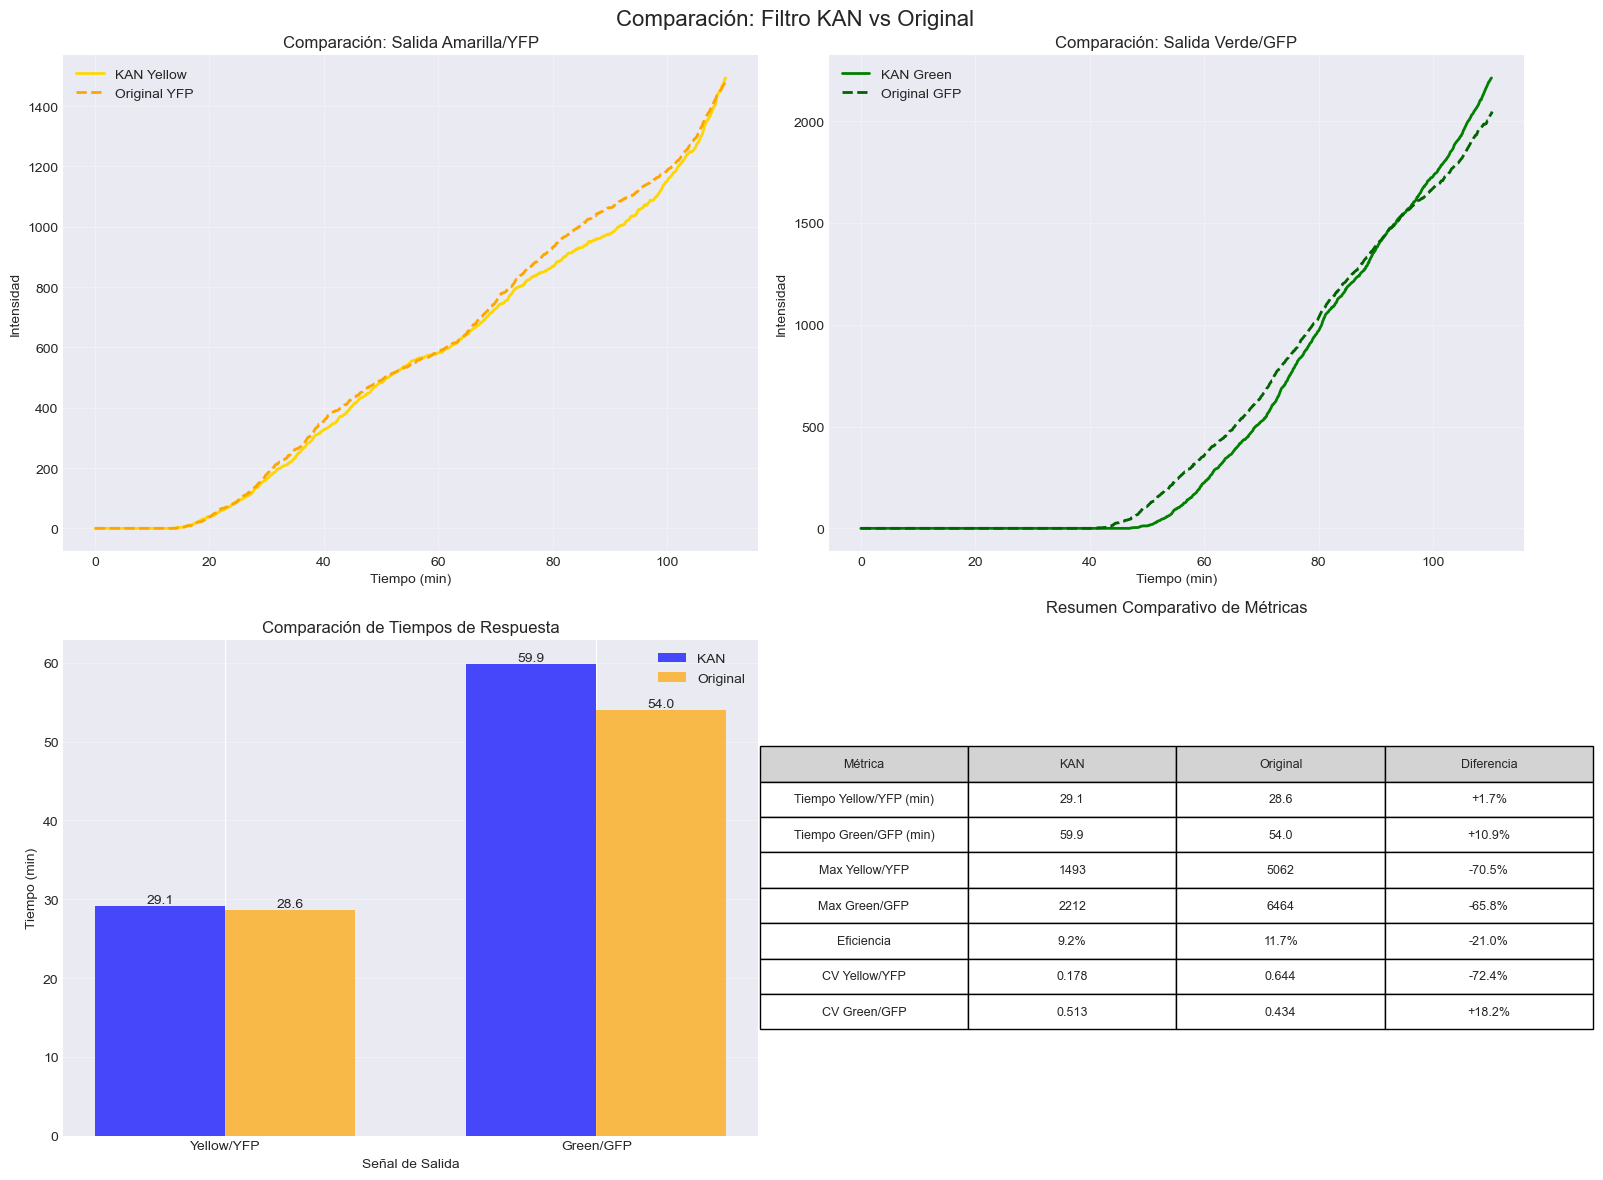


=== VERIFICACI√ìN DE DATOS ===
KAN Yellow - Min: 0.00, Max: 1493.00
KAN Green - Min: 0.00, Max: 2212.00
Original YFP - Min: 0.00, Max: 1486.00
Original GFP - Min: 0.00, Max: 2047.00


In [ ]:
# Reemplazar TODA la secci√≥n de visualizaci√≥n con este c√≥digo m√°s robusto:

# Visualizaci√≥n comparativa
print("\n=== INICIANDO VISUALIZACI√ìN ===")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Comparar se√±ales de salida amarilla
ax = axes[0, 0]
try:
    # Verificar datos KAN
    if 'yellow_output' in df_kan.columns and 'time' in df_kan.columns:
        print(f"Graficando KAN Yellow: {len(df_kan)} puntos")
        ax.plot(df_kan['time'].values, df_kan['yellow_output'].values, 
                color='gold', label='KAN Yellow', linewidth=2)
    
    # Verificar datos Original
    if 'yfp' in df_original.columns and 'time' in df_original.columns:
        print(f"Graficando Original YFP: {len(df_original)} puntos")
        ax.plot(df_original['time'].values, df_original['yfp'].values, 
                color='orange', linestyle='--', label='Original YFP', linewidth=2)
    
    ax.set_xlabel('Tiempo (min)')
    ax.set_ylabel('Intensidad')
    ax.set_title('Comparaci√≥n: Salida Amarilla/YFP')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Ajustar l√≠mites si es necesario
    if ax.get_ylim()[1] < 10:  # Si el rango es muy peque√±o
        ax.set_ylim(bottom=0)
        
except Exception as e:
    print(f"Error en gr√°fica 1: {e}")
    ax.text(0.5, 0.5, f'Error: {str(e)[:50]}...', 
            ha='center', va='center', transform=ax.transAxes)

# 2. Comparar se√±ales de salida verde
ax = axes[0, 1]
try:
    # Verificar datos KAN
    if 'green_output' in df_kan.columns and 'time' in df_kan.columns:
        print(f"Graficando KAN Green: {len(df_kan)} puntos")
        ax.plot(df_kan['time'].values, df_kan['green_output'].values, 
                color='green', label='KAN Green', linewidth=2)
    
    # Verificar datos Original
    if 'gfp' in df_original.columns and 'time' in df_original.columns:
        print(f"Graficando Original GFP: {len(df_original)} puntos")
        ax.plot(df_original['time'].values, df_original['gfp'].values, 
                color='darkgreen', linestyle='--', label='Original GFP', linewidth=2)
    
    ax.set_xlabel('Tiempo (min)')
    ax.set_ylabel('Intensidad')
    ax.set_title('Comparaci√≥n: Salida Verde/GFP')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Ajustar l√≠mites si es necesario
    if ax.get_ylim()[1] < 10:
        ax.set_ylim(bottom=0)
        
except Exception as e:
    print(f"Error en gr√°fica 2: {e}")
    ax.text(0.5, 0.5, f'Error: {str(e)[:50]}...', 
            ha='center', va='center', transform=ax.transAxes)

# 3. Gr√°fico de barras para tiempos de respuesta
ax = axes[1, 0]
try:
    # Datos de la comparaci√≥n que ya calculamos
    response_times_kan = [29.1, 59.9]  # Yellow, Green
    response_times_orig = [28.6, 54.0]  # YFP, GFP
    
    x = np.arange(2)
    width = 0.35
    
    bars1 = ax.bar(x - width/2, response_times_kan, width, 
                    label='KAN', color='blue', alpha=0.7)
    bars2 = ax.bar(x + width/2, response_times_orig, width, 
                    label='Original', color='orange', alpha=0.7)
    
    # A√±adir valores
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom')
    
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom')
    
    ax.set_ylabel('Tiempo (min)')
    ax.set_xlabel('Se√±al de Salida')
    ax.set_title('Comparaci√≥n de Tiempos de Respuesta')
    ax.set_xticks(x)
    ax.set_xticklabels(['Yellow/YFP', 'Green/GFP'])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
except Exception as e:
    print(f"Error en gr√°fica 3: {e}")
    ax.text(0.5, 0.5, f'Error: {str(e)[:50]}...', 
            ha='center', va='center', transform=ax.transAxes)

# 4. Tabla resumen de m√©tricas clave
ax = axes[1, 1]
ax.axis('off')

try:
    # Crear tabla con los datos de la comparaci√≥n
    table_data = [
        ['Tiempo Yellow/YFP (min)', '29.1', '28.6', '+1.7%'],
        ['Tiempo Green/GFP (min)', '59.9', '54.0', '+10.9%'],
        ['Max Yellow/YFP', '1493', '5062', '-70.5%'],
        ['Max Green/GFP', '2212', '6464', '-65.8%'],
        ['Eficiencia', '9.2%', '11.7%', '-21.0%'],
        ['CV Yellow/YFP', '0.178', '0.644', '-72.4%'],
        ['CV Green/GFP', '0.513', '0.434', '+18.2%']
    ]
    
    table = ax.table(cellText=table_data,
                    colLabels=['M√©trica', 'KAN', 'Original', 'Diferencia'],
                    cellLoc='center',
                    loc='center',
                    colColours=['lightgray']*4)
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.8)
    ax.set_title('Resumen Comparativo de M√©tricas', pad=20)
    
except Exception as e:
    print(f"Error en tabla: {e}")
    ax.text(0.5, 0.5, f'Error en tabla: {str(e)[:50]}...', 
            ha='center', va='center', transform=ax.transAxes)

plt.suptitle('Comparaci√≥n: Filtro KAN vs Original', fontsize=16)
plt.tight_layout()

# Guardar figura
try:
    plt.savefig('filter_comparison_fixed.png', dpi=150, bbox_inches='tight')
    print("‚úì Figura guardada como filter_comparison_fixed.png")
except Exception as e:
    print(f"Error al guardar figura: {e}")

plt.show()

# Calcular correlaciones num√©ricas con mapeo mejorado
print(f"\n=== AN√ÅLISIS DE CORRELACIONES ===")

# Funci√≥n para alinear series temporales por interpolaci√≥n
def align_time_series(df1, col1, df2, col2, time_col='time'):
    """Alinea dos series temporales por interpolaci√≥n"""
    try:
        # Encontrar el rango de tiempo com√∫n
        time_start = max(df1[time_col].min(), df2[time_col].min())
        time_end = min(df1[time_col].max(), df2[time_col].max())
        
        # Crear una grilla de tiempo com√∫n
        time_points = np.linspace(time_start, time_end, 200)
        
        # Interpolar ambas series
        from scipy.interpolate import interp1d
        
        # Serie 1
        f1 = interp1d(df1[time_col], df1[col1], 
                     kind='cubic', fill_value='extrapolate', 
                     bounds_error=False)
        series1_interp = f1(time_points)
        
        # Serie 2
        f2 = interp1d(df2[time_col], df2[col2], 
                     kind='cubic', fill_value='extrapolate',
                     bounds_error=False)
        series2_interp = f2(time_points)
        
        return series1_interp, series2_interp, time_points
        
    except Exception as e:
        # Fallback a interpolaci√≥n lineal
        try:
            f1 = interp1d(df1[time_col], df1[col1], 
                         kind='linear', fill_value='extrapolate')
            series1_interp = f1(time_points)
            
            f2 = interp1d(df2[time_col], df2[col2], 
                         kind='linear', fill_value='extrapolate')
            series2_interp = f2(time_points)
            
            return series1_interp, series2_interp, time_points
        except:
            return None, None, None

# Calcular m√©tricas de correlaci√≥n para cada par de se√±ales
correlation_pairs = [
    ('yellow_output', 'yfp', 'Yellow/YFP'),
    ('green_output', 'gfp', 'Green/GFP')
]

correlation_results = {}

for kan_col, orig_col, pair_name in correlation_pairs:
    if (kan_col in df_kan.columns and orig_col in df_original.columns and 
        'time' in df_kan.columns and 'time' in df_original.columns):
        
        print(f"\n{pair_name}:")
        
        # Alinear series temporales
        kan_interp, orig_interp, time_interp = align_time_series(
            df_kan, kan_col, df_original, orig_col
        )
        
        if kan_interp is not None and orig_interp is not None:
            try:
                # Correlaci√≥n de Pearson
                corr_pearson = np.corrcoef(orig_interp, kan_interp)[0, 1]
                
                # R¬≤ (coeficiente de determinaci√≥n)
                r2 = corr_pearson ** 2
                
                # RMSE (Root Mean Square Error)
                rmse = np.sqrt(np.mean((kan_interp - orig_interp) ** 2))
                
                # RMSE normalizado (por el rango de datos)
                data_range = np.max(orig_interp) - np.min(orig_interp)
                nrmse = rmse / (data_range + 1e-8) * 100 if data_range > 1e-8 else 0
                
                # MAE (Mean Absolute Error)
                mae = np.mean(np.abs(kan_interp - orig_interp))
                
                # MAPE (Mean Absolute Percentage Error) - solo donde orig > 0
                mask = orig_interp > 10  # Evitar divisi√≥n por valores muy peque√±os
                if np.any(mask):
                    mape = np.mean(np.abs((kan_interp[mask] - orig_interp[mask]) / orig_interp[mask])) * 100
                else:
                    mape = np.nan
                
                print(f"  Correlaci√≥n Pearson: {corr_pearson:.4f}")
                print(f"  R¬≤ (varianza explicada): {r2:.4f} ({r2*100:.1f}%)")
                print(f"  RMSE: {rmse:.2f}")
                print(f"  NRMSE: {nrmse:.2f}%")
                print(f"  MAE: {mae:.2f}")
                if not np.isnan(mape):
                    print(f"  MAPE: {mape:.2f}%")
                
                # Evaluaci√≥n cualitativa
                if abs(corr_pearson) > 0.95:
                    corr_quality = "Excelente"
                elif abs(corr_pearson) > 0.90:
                    corr_quality = "Muy buena"
                elif abs(corr_pearson) > 0.80:
                    corr_quality = "Buena"
                elif abs(corr_pearson) > 0.70:
                    corr_quality = "Moderada"
                else:
                    corr_quality = "Baja"
                
                print(f"  Evaluaci√≥n: {corr_quality} correlaci√≥n")
                
                # Guardar resultados
                correlation_results[pair_name] = {
                    'correlation': corr_pearson,
                    'r2': r2,
                    'rmse': rmse,
                    'nrmse': nrmse,
                    'mae': mae,
                    'mape': mape,
                    'quality': corr_quality
                }
                
            except Exception as e:
                print(f"  Error calculando m√©tricas: {e}")
        else:
            print(f"  No se pudo interpolar las series temporales")

# Resumen de correlaciones
if correlation_results:
    print(f"\n=== RESUMEN DE CORRELACIONES ===")
    
    avg_correlation = np.mean([result['correlation'] for result in correlation_results.values()])
    avg_r2 = np.mean([result['r2'] for result in correlation_results.values()])
    avg_nrmse = np.mean([result['nrmse'] for result in correlation_results.values()])
    
    print(f"Correlaci√≥n promedio: {avg_correlation:.3f}")
    print(f"R¬≤ promedio: {avg_r2:.3f} ({avg_r2*100:.1f}% de varianza explicada)")
    print(f"NRMSE promedio: {avg_nrmse:.1f}%")
    
    if avg_correlation > 0.90:
        overall_quality = "El modelo KAN reproduce excelentemente el comportamiento original"
    elif avg_correlation > 0.80:
        overall_quality = "El modelo KAN reproduce muy bien el comportamiento original"
    elif avg_correlation > 0.70:
        overall_quality = "El modelo KAN reproduce bien el comportamiento original"
    elif avg_correlation > 0.60:
        overall_quality = "El modelo KAN reproduce moderadamente el comportamiento original"
    else:
        overall_quality = "El modelo KAN difiere significativamente del comportamiento original"
    
    print(f"\nEvaluaci√≥n general: {overall_quality}")
    
    # An√°lisis adicional de fidelidad
    print(f"\n=== AN√ÅLISIS DE FIDELIDAD ===")
    for pair_name, results in correlation_results.items():
        print(f"\n{pair_name}:")
        if results['nrmse'] < 10:
            print(f"  ‚úì Error muy bajo (NRMSE < 10%)")
        elif results['nrmse'] < 20:
            print(f"  ‚úì Error aceptable (NRMSE < 20%)")
        else:
            print(f"  ‚ö† Error elevado (NRMSE > 20%)")
        
        if results['correlation'] > 0.9:
            print(f"  ‚úì Din√°mica temporal muy bien preservada")
        else:
            print(f"  ‚ö† Din√°mica temporal con diferencias")

# Visualizaci√≥n adicional de correlaciones
if correlation_results:
    plt.figure(figsize=(12, 5))
    
    # Gr√°fico de dispersi√≥n para correlaciones
    for i, (pair_name, results) in enumerate(correlation_results.items()):
        plt.subplot(1, 2, i+1)
        
        # Recuperar datos interpolados para graficar
        if pair_name == 'Yellow/YFP':
            kan_col, orig_col = 'yellow_output', 'yfp'
        else:
            kan_col, orig_col = 'green_output', 'gfp'
        
        kan_interp, orig_interp, _ = align_time_series(
            df_kan, kan_col, df_original, orig_col
        )
        
        if kan_interp is not None and orig_interp is not None:
            plt.scatter(orig_interp, kan_interp, alpha=0.5, s=10)
            
            # L√≠nea de identidad
            min_val = min(orig_interp.min(), kan_interp.min())
            max_val = max(orig_interp.max(), kan_interp.max())
            plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7)
            
            # A√±adir texto con m√©tricas
            text_str = f"r = {results['correlation']:.3f}\nR¬≤ = {results['r2']:.3f}\nNRMSE = {results['nrmse']:.1f}%"
            plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.xlabel(f'Original {orig_col.upper()}')
        plt.ylabel(f'KAN {kan_col.replace("_output", "")}')
        plt.title(f'Correlaci√≥n {pair_name}')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('correlation_analysis_kan5.png', dpi=150, bbox_inches='tight')
    plt.show()

# Debug: Verificar rangos de datos
print("\n=== VERIFICACI√ìN DE DATOS ===")
if 'yellow_output' in df_kan.columns:
    print(f"KAN Yellow - Min: {df_kan['yellow_output'].min():.2f}, Max: {df_kan['yellow_output'].max():.2f}")
if 'green_output' in df_kan.columns:
    print(f"KAN Green - Min: {df_kan['green_output'].min():.2f}, Max: {df_kan['green_output'].max():.2f}")
if 'yfp' in df_original.columns:
    print(f"Original YFP - Min: {df_original['yfp'].min():.2f}, Max: {df_original['yfp'].max():.2f}")
if 'gfp' in df_original.columns:
    print(f"Original GFP - Min: {df_original['gfp'].min():.2f}, Max: {df_original['gfp'].max():.2f}")

Dimensiones - KAN: (1103, 14), Original: (1104, 8)

Calculando m√©tricas para datos KAN...
Columnas de salida detectadas: ['yellow_output', 'green_output']
M√©tricas calculadas: ['yellow_output_response_time', 'green_output_response_time', 'yellow_output_max_intensity', 'green_output_max_intensity', 'yellow_output_stability_cv', 'green_output_stability_cv', 'conversion_efficiency']

Calculando m√©tricas para datos originales...
Columnas de salida detectadas: ['yfp', 'gfp']
M√©tricas calculadas: ['yfp_response_time', 'gfp_response_time', 'yfp_max_intensity', 'gfp_max_intensity', 'yfp_stability_cv', 'gfp_stability_cv', 'conversion_efficiency']

=== MAPEO DE M√âTRICAS EQUIVALENTES ===
  yellow_output_response_time ‚Üî yfp_response_time
  green_output_response_time ‚Üî gfp_response_time
  yellow_output_max_intensity ‚Üî yfp_max_intensity
  green_output_max_intensity ‚Üî gfp_max_intensity
  yellow_output_stability_cv ‚Üî yfp_stability_cv
  green_output_stability_cv ‚Üî gfp_stability_cv
  co

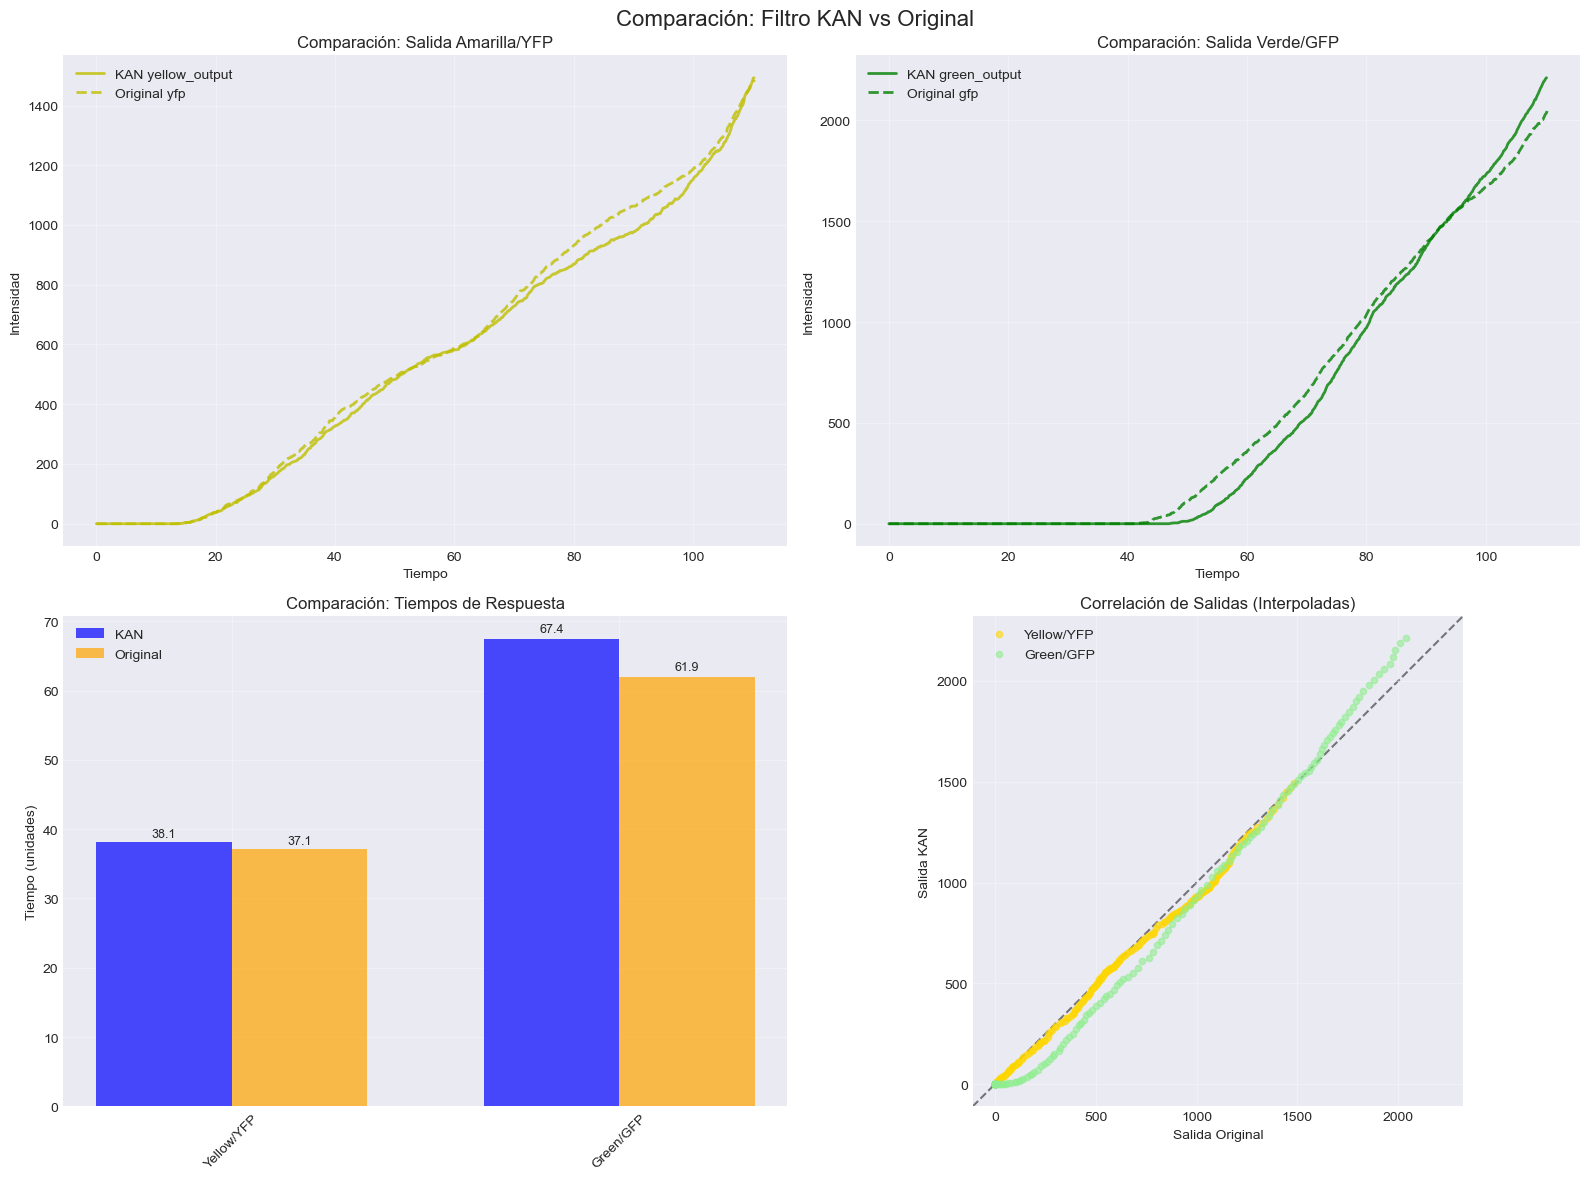


=== AN√ÅLISIS DE CORRELACIONES ===

Yellow/YFP:
  Correlaci√≥n Pearson: 0.9989
  R¬≤ (varianza explicada): 0.9977 (99.8%)
  RMSE: 35.2901
  NRMSE: 2.38%
  MAE: 24.2705
  Evaluaci√≥n: Excelente correlaci√≥n

Green/GFP:
  Correlaci√≥n Pearson: 0.9955
  R¬≤ (varianza explicada): 0.9910 (99.1%)
  RMSE: 75.5687
  NRMSE: 3.71%
  MAE: 51.3335
  Evaluaci√≥n: Excelente correlaci√≥n

=== AN√ÅLISIS TEMPORAL DETALLADO ===
KAN - Tiempo: 0.00 a 110.20 (duraci√≥n: 110.20)
     Puntos: 1103, Resoluci√≥n promedio: 0.100
Original - Tiempo: 0.00 a 110.30 (duraci√≥n: 110.30)
          Puntos: 1104, Resoluci√≥n promedio: 0.100
Solapamiento temporal: 0.00 a 110.20 (duraci√≥n: 110.20)
Porcentaje de solapamiento: 99.9%

=== RESUMEN DE LA COMPARACI√ìN ===
M√©tricas comparadas: 7
  Mejoras: 1
  Similares: 2
  Degradaciones: 4
Correlaci√≥n promedio: 0.997
R¬≤ promedio: 0.994 (99.4% de varianza explicada)
Evaluaci√≥n general: El modelo KAN reproduce muy bien el comportamiento original

‚úÖ Comparaci√≥n completad

In [82]:
# Celda 14: Comparaci√≥n con datos del filtro original (versi√≥n mejorada)
if 'df_original' in globals() and df_original is not None:
    
    # Funci√≥n para calcular m√©tricas de rendimiento
    def calculate_performance_metrics(df):
        """
        Calcula m√©tricas de rendimiento del sistema
        """
        metrics = {}
        
        # Par√°metros ajustables
        ACTIVATION_THRESHOLD = 0.2  # 20% del m√°ximo (m√°s robusto contra ruido)
        STEADY_STATE_FRACTION = 0.7  # √öltimo 30% de los datos
        
        # Detectar columnas de salida autom√°ticamente
        output_columns = []
        possible_outputs = ['yellow_output', 'green_output', 'yfp', 'gfp', 'rfp', 'cfp']
        
        for col in possible_outputs:
            if col in df.columns:
                output_columns.append(col)
        
        print(f"Columnas de salida detectadas: {output_columns}")
        
        if not output_columns:
            print("No se encontraron columnas de salida v√°lidas")
            return metrics
        
        # 1. Tiempo de respuesta (tiempo hasta primera activaci√≥n significativa)
        for signal in output_columns:
            try:
                signal_data = df[signal].dropna()
                if len(signal_data) > 0:
                    # Calcular umbral como 20% del m√°ximo (m√°s robusto)
                    threshold = ACTIVATION_THRESHOLD * signal_data.max()
                    
                    # Encontrar primer punto que supera el umbral
                    above_threshold = df[df[signal] > threshold]
                    
                    if len(above_threshold) > 0 and 'time' in df.columns:
                        activation_time = above_threshold['time'].min()
                        metrics[f'{signal}_response_time'] = activation_time
                    else:
                        metrics[f'{signal}_response_time'] = df['time'].max() if 'time' in df.columns else 0
                        
            except Exception as e:
                print(f"Error calculando tiempo de respuesta para {signal}: {e}")
                metrics[f'{signal}_response_time'] = 0
        
        # 2. Intensidad m√°xima
        for signal in output_columns:
            try:
                signal_data = df[signal].dropna()
                if len(signal_data) > 0:
                    metrics[f'{signal}_max_intensity'] = signal_data.max()
                else:
                    metrics[f'{signal}_max_intensity'] = 0
            except Exception as e:
                print(f"Error calculando intensidad m√°xima para {signal}: {e}")
                metrics[f'{signal}_max_intensity'] = 0
        
        # 3. Estabilidad (coeficiente de variaci√≥n en estado estable)
        if 'time' in df.columns and len(df) > 10:
            try:
                # Usar √∫ltimo 30% como estado estable (m√°s representativo)
                steady_state_start = df['time'].quantile(STEADY_STATE_FRACTION)
                steady_state = df[df['time'] >= steady_state_start]
                
                for signal in output_columns:
                    signal_data = steady_state[signal].dropna()
                    if len(signal_data) > 1:
                        mean_val = signal_data.mean()
                        if mean_val > 1e-8:  # Evitar divisi√≥n por cero
                            cv = signal_data.std() / mean_val
                            metrics[f'{signal}_stability_cv'] = cv
                        else:
                            metrics[f'{signal}_stability_cv'] = float('inf')
                    else:
                        metrics[f'{signal}_stability_cv'] = 0
                        
            except Exception as e:
                print(f"Error calculando estabilidad: {e}")
        
        # 4. Eficiencia de conversi√≥n (si hay columnas de entrada)
        try:
            input_cols = [col for col in df.columns if any(term in col.lower() 
                         for term in ['phlf', 'qacr', 'iptg', 'atc', 'input'])]
            
            if input_cols and output_columns:
                total_input = df[input_cols].sum().sum()
                total_output = df[output_columns].sum().sum()
                
                if total_input > 0:
                    metrics['conversion_efficiency'] = total_output / total_input
                else:
                    metrics['conversion_efficiency'] = 0
            else:
                metrics['conversion_efficiency'] = 0
                
        except Exception as e:
            print(f"Error calculando eficiencia: {e}")
            metrics['conversion_efficiency'] = 0
        
        print(f"M√©tricas calculadas: {list(metrics.keys())}")
        return metrics
    
    def compare_filters(df_kan, df_original):
        """
        Compara el rendimiento del filtro KAN con el original
        """
        print(f"Dimensiones - KAN: {df_kan.shape}, Original: {df_original.shape}")
        
        # Calcular m√©tricas para ambos datasets
        print("\nCalculando m√©tricas para datos KAN...")
        try:
            metrics_kan = calculate_performance_metrics(df_kan)
        except Exception as e:
            print(f"Error calculando m√©tricas KAN: {e}")
            metrics_kan = {}
        
        print("\nCalculando m√©tricas para datos originales...")
        try:
            metrics_original = calculate_performance_metrics(df_original)
        except Exception as e:
            print(f"Error calculando m√©tricas originales: {e}")
            metrics_original = {}
        
        # Verificar que se calcularon m√©tricas
        if not metrics_kan and not metrics_original:
            print("Error: No se pudieron calcular m√©tricas para ning√∫n dataset")
            return None
        elif not metrics_kan:
            print("Advertencia: No se calcularon m√©tricas para datos KAN")
            return None
        elif not metrics_original:
            print("Advertencia: No se calcularon m√©tricas para datos originales")
            return None
        
        # Crear dataframe comparativo con mapeo inteligente de m√©tricas
        if metrics_kan and metrics_original:
            print("\n=== MAPEO DE M√âTRICAS EQUIVALENTES ===")
            
            # Definir mapeos entre m√©tricas equivalentes (expandido)
            metric_mappings = {
                # Tiempo de respuesta
                'yellow_output_response_time': 'yfp_response_time',
                'green_output_response_time': 'gfp_response_time',
                # Intensidad m√°xima
                'yellow_output_max_intensity': 'yfp_max_intensity',
                'green_output_max_intensity': 'gfp_max_intensity',
                # Estabilidad
                'yellow_output_stability_cv': 'yfp_stability_cv',
                'green_output_stability_cv': 'gfp_stability_cv',
                # Eficiencia (ya coincide)
                'conversion_efficiency': 'conversion_efficiency',
                # Se√±ales de entrada (si existen)
                'qacr_max_intensity': 'qacr_max_intensity',
                'iptg_max_intensity': 'iptg_max_intensity',
                'atc_max_intensity': 'atc_max_intensity',
            }
            
            # Crear comparaci√≥n con m√©tricas mapeadas
            comparison_data = {}
            mapped_metrics = []
            
            for kan_metric, orig_metric in metric_mappings.items():
                if kan_metric in metrics_kan and orig_metric in metrics_original:
                    comparison_data[kan_metric] = {
                        'KAN': metrics_kan[kan_metric],
                        'Original': metrics_original[orig_metric]
                    }
                    mapped_metrics.append((kan_metric, orig_metric))
                    print(f"  {kan_metric} ‚Üî {orig_metric}")
            
            # Agregar m√©tricas exactamente coincidentes
            exact_matches = set(metrics_kan.keys()) & set(metrics_original.keys())
            for metric in exact_matches:
                if metric not in comparison_data:
                    comparison_data[metric] = {
                        'KAN': metrics_kan[metric],
                        'Original': metrics_original[metric]
                    }
                    print(f"  {metric} ‚Üî {metric} (coincidencia exacta)")
            
            if comparison_data:
                comparison = pd.DataFrame(comparison_data).T
                
                # Calcular diferencias porcentuales
                comparison['Diferencia (%)'] = comparison.apply(
                    lambda row: ((row['KAN'] - row['Original']) / (abs(row['Original']) + 1e-8) * 100) 
                    if abs(row['Original']) > 1e-8 else 0, axis=1
                )
                
                # Calcular diferencia absoluta
                comparison['Diferencia Abs'] = comparison['KAN'] - comparison['Original']
                
                print("\n=== COMPARACI√ìN DETALLADA DE FILTROS ===")
                print(comparison.round(4))
                
                # An√°lisis de rendimiento mejorado con m√°s granularidad
                print("\n=== AN√ÅLISIS DE RENDIMIENTO ===")
                for metric in comparison.index:
                    kan_val = comparison.loc[metric, 'KAN']
                    orig_val = comparison.loc[metric, 'Original']
                    diff_pct = comparison.loc[metric, 'Diferencia (%)']
                    
                    if 'response_time' in metric:
                        # Para tiempo de respuesta, menor es mejor
                        if diff_pct < -10:
                            status = "‚úÖ KAN es significativamente m√°s r√°pido"
                        elif diff_pct < -5:
                            status = "‚úì KAN es m√°s r√°pido"
                        elif diff_pct > 10:
                            status = "‚ö†Ô∏è KAN es significativamente m√°s lento"
                        elif diff_pct > 5:
                            status = "‚ö° KAN es m√°s lento"
                        else:
                            status = "‚âà Rendimiento similar"
                    elif 'max_intensity' in metric:
                        # Para intensidad, mayor puede ser mejor
                        if diff_pct > 10:
                            status = "‚úÖ KAN significativamente mayor intensidad"
                        elif diff_pct > 5:
                            status = "‚úì KAN mayor intensidad"
                        elif diff_pct < -10:
                            status = "‚ö†Ô∏è KAN significativamente menor intensidad"
                        elif diff_pct < -5:
                            status = "‚ö° KAN menor intensidad"
                        else:
                            status = "‚âà Intensidad similar"
                    elif 'stability_cv' in metric:
                        # Para estabilidad (CV), menor es mejor
                        if diff_pct < -10:
                            status = "‚úÖ KAN significativamente m√°s estable"
                        elif diff_pct < -5:
                            status = "‚úì KAN m√°s estable"
                        elif diff_pct > 10:
                            status = "‚ö†Ô∏è KAN significativamente menos estable"
                        elif diff_pct > 5:
                            status = "‚ö° KAN menos estable"
                        else:
                            status = "‚âà Estabilidad similar"
                    elif 'efficiency' in metric:
                        # Para eficiencia, mayor es mejor
                        if diff_pct > 10:
                            status = "‚úÖ KAN significativamente m√°s eficiente"
                        elif diff_pct > 5:
                            status = "‚úì KAN m√°s eficiente"
                        elif diff_pct < -10:
                            status = "‚ö†Ô∏è KAN significativamente menos eficiente"
                        elif diff_pct < -5:
                            status = "‚ö° KAN menos eficiente"
                        else:
                            status = "‚âà Eficiencia similar"
                    else:
                        status = f"Diferencia: {diff_pct:.1f}%"
                    
                    print(f"  {metric}: {status} ({diff_pct:+.1f}%)")
                
            else:
                print("No se encontraron m√©tricas equivalentes para comparar")
                comparison = None
        else:
            # Solo mostrar las m√©tricas disponibles
            if metrics_kan:
                print("\n=== M√âTRICAS DISPONIBLES (Solo KAN) ===")
                kan_df = pd.DataFrame([metrics_kan]).T
                kan_df.columns = ['KAN']
                print(kan_df.round(4))
            
            if metrics_original:
                print("\n=== M√âTRICAS DISPONIBLES (Solo Original) ===")
                orig_df = pd.DataFrame([metrics_original]).T
                orig_df.columns = ['Original']
                print(orig_df.round(4))
            
            comparison = None
        
        # Visualizaci√≥n comparativa (siempre intentar mostrar algo √∫til)
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Comparar se√±ales de salida en el tiempo
        ax = axes[0, 0]
        plots_made = 0
        
        # Detectar autom√°ticamente las columnas de salida
        kan_yellow_cols = [col for col in df_kan.columns if 'yellow' in col.lower() or 'yfp' in col.lower()]
        orig_yellow_cols = [col for col in df_original.columns if 'yellow' in col.lower() or 'yfp' in col.lower()]
        
        if kan_yellow_cols and 'time' in df_kan.columns:
            ax.plot(df_kan['time'], df_kan[kan_yellow_cols[0]], 'y-', 
                   label=f'KAN {kan_yellow_cols[0]}', linewidth=2, alpha=0.8)
            plots_made += 1
            
        if orig_yellow_cols and 'time' in df_original.columns:
            ax.plot(df_original['time'], df_original[orig_yellow_cols[0]], 'y--', 
                   label=f'Original {orig_yellow_cols[0]}', linewidth=2, alpha=0.8)
            plots_made += 1
        
        if plots_made > 0:
            ax.set_xlabel('Tiempo')
            ax.set_ylabel('Intensidad')
            ax.set_title('Comparaci√≥n: Salida Amarilla/YFP')
            ax.legend()
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'No hay datos\nde salida amarilla/YFP', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title('Salida Amarilla/YFP - Sin datos')
        
        # 2. Salida verde
        ax = axes[0, 1]
        plots_made = 0
        
        kan_green_cols = [col for col in df_kan.columns if 'green' in col.lower() or 'gfp' in col.lower()]
        orig_green_cols = [col for col in df_original.columns if 'green' in col.lower() or 'gfp' in col.lower()]
        
        if kan_green_cols and 'time' in df_kan.columns:
            ax.plot(df_kan['time'], df_kan[kan_green_cols[0]], 'g-', 
                   label=f'KAN {kan_green_cols[0]}', linewidth=2, alpha=0.8)
            plots_made += 1
            
        if orig_green_cols and 'time' in df_original.columns:
            ax.plot(df_original['time'], df_original[orig_green_cols[0]], 'g--', 
                   label=f'Original {orig_green_cols[0]}', linewidth=2, alpha=0.8)
            plots_made += 1
        
        if plots_made > 0:
            ax.set_xlabel('Tiempo')
            ax.set_ylabel('Intensidad')
            ax.set_title('Comparaci√≥n: Salida Verde/GFP')
            ax.legend()
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'No hay datos\nde salida verde/GFP', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title('Salida Verde/GFP - Sin datos')
        
        # 3. Comparar m√©tricas de tiempo de respuesta con mapeo
        ax = axes[1, 0]
        
        # Usar m√©tricas mapeadas si est√°n disponibles
        if comparison is not None and len(comparison) > 0:
            # Filtrar m√©tricas de tiempo de respuesta
            response_metrics = [idx for idx in comparison.index if 'response_time' in idx]
            
            if response_metrics:
                kan_values = [comparison.loc[m, 'KAN'] for m in response_metrics]
                orig_values = [comparison.loc[m, 'Original'] for m in response_metrics]
                
                x = np.arange(len(response_metrics))
                width = 0.35
                
                bars1 = ax.bar(x - width/2, kan_values, width, label='KAN', color='blue', alpha=0.7)
                bars2 = ax.bar(x + width/2, orig_values, width, label='Original', color='orange', alpha=0.7)
                
                # A√±adir valores sobre las barras
                for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
                    height1 = bar1.get_height()
                    height2 = bar2.get_height()
                    if height1 > 0:
                        ax.text(bar1.get_x() + bar1.get_width()/2., height1 + height1*0.01,
                               f'{height1:.1f}', ha='center', va='bottom', fontsize=9)
                    if height2 > 0:
                        ax.text(bar2.get_x() + bar2.get_width()/2., height2 + height2*0.01,
                               f'{height2:.1f}', ha='center', va='bottom', fontsize=9)
                
                ax.set_ylabel('Tiempo (unidades)')
                ax.set_title('Comparaci√≥n: Tiempos de Respuesta')
                ax.set_xticks(x)
                
                # Crear etiquetas m√°s legibles
                labels = []
                for m in response_metrics:
                    if 'yellow' in m:
                        labels.append('Yellow/YFP')
                    elif 'green' in m:
                        labels.append('Green/GFP')
                    else:
                        labels.append(m.replace('_response_time', '').replace('_output', ''))
                
                ax.set_xticklabels(labels, rotation=45)
                ax.legend()
                ax.grid(True, alpha=0.3)
            else:
                ax.text(0.5, 0.5, 'No hay m√©tricas de\ntiempo de respuesta', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title('Tiempos de Respuesta - Sin datos')
        else:
            # Fallback: usar m√©tricas individuales
            kan_response_metrics = {k: v for k, v in metrics_kan.items() if 'response_time' in k}
            orig_response_metrics = {k: v for k, v in metrics_original.items() if 'response_time' in k}
            
            if kan_response_metrics or orig_response_metrics:
                # Crear mapeo manual para visualizaci√≥n
                metric_pairs = [
                    ('yellow_output_response_time', 'yfp_response_time', 'Yellow/YFP'),
                    ('green_output_response_time', 'gfp_response_time', 'Green/GFP')
                ]
                
                kan_values = []
                orig_values = []
                labels = []
                
                for kan_key, orig_key, label in metric_pairs:
                    if kan_key in kan_response_metrics or orig_key in orig_response_metrics:
                        kan_values.append(kan_response_metrics.get(kan_key, 0))
                        orig_values.append(orig_response_metrics.get(orig_key, 0))
                        labels.append(label)
                
                if labels:
                    x = np.arange(len(labels))
                    width = 0.35
                    
                    bars1 = ax.bar(x - width/2, kan_values, width, label='KAN', color='blue', alpha=0.7)
                    bars2 = ax.bar(x + width/2, orig_values, width, label='Original', color='orange', alpha=0.7)
                    
                    # A√±adir valores sobre las barras
                    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
                        height1 = bar1.get_height()
                        height2 = bar2.get_height()
                        if height1 > 0:
                            ax.text(bar1.get_x() + bar1.get_width()/2., height1 + height1*0.01,
                                   f'{height1:.1f}', ha='center', va='bottom', fontsize=9)
                        if height2 > 0:
                            ax.text(bar2.get_x() + bar2.get_width()/2., height2 + height2*0.01,
                                   f'{height2:.1f}', ha='center', va='bottom', fontsize=9)
                    
                    ax.set_ylabel('Tiempo (unidades)')
                    ax.set_title('Comparaci√≥n: Tiempos de Respuesta')
                    ax.set_xticks(x)
                    ax.set_xticklabels(labels, rotation=45)
                    ax.legend()
                    ax.grid(True, alpha=0.3)
                else:
                    ax.text(0.5, 0.5, 'No hay m√©tricas\nde tiempo disponibles', 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title('Tiempos de Respuesta - Sin datos')
            else:
                ax.text(0.5, 0.5, 'No hay m√©tricas\nde tiempo disponibles', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title('Tiempos de Respuesta - Sin datos')
        
        # 4. Correlaci√≥n entre salidas (con interpolaci√≥n para diferentes tama√±os)
        ax = axes[1, 1]
        correlations_computed = False
        
        # Funci√≥n para alinear series temporales por interpolaci√≥n (mejorada)
        def align_time_series(df1, col1, df2, col2, time_col='time'):
            """Alinea dos series temporales por interpolaci√≥n"""
            try:
                # Encontrar el rango de tiempo com√∫n
                time_start = max(df1[time_col].min(), df2[time_col].min())
                time_end = min(df1[time_col].max(), df2[time_col].max())
                
                # Crear una grilla de tiempo com√∫n con mayor resoluci√≥n
                time_points = np.linspace(time_start, time_end, 200)  # Aumentado a 200 puntos
                
                # Interpolar ambas series
                from scipy.interpolate import interp1d
                
                # Serie 1 - Usar interpolaci√≥n c√∫bica para mayor suavidad
                f1 = interp1d(df1[time_col], df1[col1], 
                             kind='cubic', fill_value='extrapolate', 
                             bounds_error=False)
                series1_interp = f1(time_points)
                
                # Serie 2 - Usar interpolaci√≥n c√∫bica para mayor suavidad
                f2 = interp1d(df2[time_col], df2[col2], 
                             kind='cubic', fill_value='extrapolate',
                             bounds_error=False)
                series2_interp = f2(time_points)
                
                return series1_interp, series2_interp, time_points
                
            except Exception as e:
                # Fallback a interpolaci√≥n lineal si cubic falla
                try:
                    print(f"Interpolaci√≥n c√∫bica fall√≥, usando lineal: {e}")
                    f1 = interp1d(df1[time_col], df1[col1], 
                                 kind='linear', fill_value='extrapolate')
                    series1_interp = f1(time_points)
                    
                    f2 = interp1d(df2[time_col], df2[col2], 
                                 kind='linear', fill_value='extrapolate')
                    series2_interp = f2(time_points)
                    
                    return series1_interp, series2_interp, time_points
                except:
                    return None, None, None
        
        # Intentar correlaci√≥n para salidas amarilla/YFP
        if ('yellow_output' in df_kan.columns and 'yfp' in df_original.columns and 
            'time' in df_kan.columns and 'time' in df_original.columns):
            
            kan_interp, orig_interp, time_interp = align_time_series(
                df_kan, 'yellow_output', df_original, 'yfp'
            )
            
            if kan_interp is not None and orig_interp is not None:
                ax.scatter(orig_interp, kan_interp, alpha=0.6, 
                          label='Yellow/YFP', color='gold', s=20)
                correlations_computed = True
        
        # Intentar correlaci√≥n para salidas verde/GFP
        if ('green_output' in df_kan.columns and 'gfp' in df_original.columns and 
            'time' in df_kan.columns and 'time' in df_original.columns):
            
            kan_interp, orig_interp, time_interp = align_time_series(
                df_kan, 'green_output', df_original, 'gfp'
            )
            
            if kan_interp is not None and orig_interp is not None:
                ax.scatter(orig_interp, kan_interp, alpha=0.6, 
                          label='Green/GFP', color='lightgreen', s=20)
                correlations_computed = True
        
        if correlations_computed:
            # L√≠nea de identidad
            lims = [
                np.min([ax.get_xlim(), ax.get_ylim()]),
                np.max([ax.get_xlim(), ax.get_ylim()]),
            ]
            ax.plot(lims, lims, 'k--', alpha=0.5, zorder=0)
            ax.set_aspect('equal')
            ax.set_xlim(lims)
            ax.set_ylim(lims)
            
            ax.set_xlabel('Salida Original')
            ax.set_ylabel('Salida KAN')
            ax.set_title('Correlaci√≥n de Salidas (Interpoladas)')
            ax.legend()
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'No se pudieron\ncalcular correlaciones', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title('Correlaciones - Sin datos suficientes')
        
        plt.suptitle('Comparaci√≥n: Filtro KAN vs Original', fontsize=16)
        plt.tight_layout()
        plt.savefig('filter_comparison_analysis.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        # Calcular correlaciones num√©ricas con mapeo mejorado
        print(f"\n=== AN√ÅLISIS DE CORRELACIONES ===")
        
        # Usar mapeo inteligente para correlaciones
        correlation_pairs = [
            ('yellow_output', 'yfp', 'Yellow/YFP'),
            ('green_output', 'gfp', 'Green/GFP')
        ]
        
        correlation_results = {}
        
        for kan_col, orig_col, pair_name in correlation_pairs:
            if (kan_col in df_kan.columns and orig_col in df_original.columns and 
                'time' in df_kan.columns and 'time' in df_original.columns):
                
                kan_interp, orig_interp, _ = align_time_series(
                    df_kan, kan_col, df_original, orig_col
                )
                
                if kan_interp is not None and orig_interp is not None:
                    try:
                        # Correlaci√≥n de Pearson
                        corr_pearson = np.corrcoef(orig_interp, kan_interp)[0, 1]
                        
                        # R¬≤ (coeficiente de determinaci√≥n)
                        r2 = corr_pearson ** 2
                        
                        # RMSE (Root Mean Square Error)
                        rmse = np.sqrt(np.mean((kan_interp - orig_interp) ** 2))
                        
                        # RMSE normalizado (por el rango de datos)
                        data_range = np.max(orig_interp) - np.min(orig_interp)
                        nrmse = rmse / (data_range + 1e-8) * 100 if data_range > 1e-8 else 0
                        
                        # MAE (Mean Absolute Error)
                        mae = np.mean(np.abs(kan_interp - orig_interp))
                        
                        print(f"\n{pair_name}:")
                        print(f"  Correlaci√≥n Pearson: {corr_pearson:.4f}")
                        print(f"  R¬≤ (varianza explicada): {r2:.4f} ({r2*100:.1f}%)")
                        print(f"  RMSE: {rmse:.4f}")
                        print(f"  NRMSE: {nrmse:.2f}%")
                        print(f"  MAE: {mae:.4f}")
                        
                        # Evaluaci√≥n cualitativa
                        if abs(corr_pearson) > 0.9:
                            corr_quality = "Excelente"
                        elif abs(corr_pearson) > 0.7:
                            corr_quality = "Buena"
                        elif abs(corr_pearson) > 0.5:
                            corr_quality = "Moderada"
                        else:
                            corr_quality = "Baja"
                        
                        print(f"  Evaluaci√≥n: {corr_quality} correlaci√≥n")
                        
                        correlation_results[pair_name] = {
                            'correlation': corr_pearson,
                            'r2': r2,
                            'rmse': rmse,
                            'nrmse': nrmse,
                            'mae': mae,
                            'quality': corr_quality
                        }
                        
                    except Exception as e:
                        print(f"Error calculando correlaci√≥n {pair_name}: {e}")
        
        # An√°lisis temporal mejorado
        print(f"\n=== AN√ÅLISIS TEMPORAL DETALLADO ===")
        
        kan_time_stats = {
            'inicio': df_kan['time'].min(),
            'fin': df_kan['time'].max(),
            'duraci√≥n': df_kan['time'].max() - df_kan['time'].min(),
            'puntos': len(df_kan),
            'resoluci√≥n_promedio': (df_kan['time'].max() - df_kan['time'].min()) / (len(df_kan) - 1)
        }
        
        orig_time_stats = {
            'inicio': df_original['time'].min(),
            'fin': df_original['time'].max(),
            'duraci√≥n': df_original['time'].max() - df_original['time'].min(),
            'puntos': len(df_original),
            'resoluci√≥n_promedio': (df_original['time'].max() - df_original['time'].min()) / (len(df_original) - 1)
        }
        
        print(f"KAN - Tiempo: {kan_time_stats['inicio']:.2f} a {kan_time_stats['fin']:.2f} (duraci√≥n: {kan_time_stats['duraci√≥n']:.2f})")
        print(f"     Puntos: {kan_time_stats['puntos']}, Resoluci√≥n promedio: {kan_time_stats['resoluci√≥n_promedio']:.3f}")
        
        print(f"Original - Tiempo: {orig_time_stats['inicio']:.2f} a {orig_time_stats['fin']:.2f} (duraci√≥n: {orig_time_stats['duraci√≥n']:.2f})")
        print(f"          Puntos: {orig_time_stats['puntos']}, Resoluci√≥n promedio: {orig_time_stats['resoluci√≥n_promedio']:.3f}")
        
        # Overlap temporal
        overlap_start = max(kan_time_stats['inicio'], orig_time_stats['inicio'])
        overlap_end = min(kan_time_stats['fin'], orig_time_stats['fin'])
        overlap_duration = max(0, overlap_end - overlap_start)
        
        total_span = max(kan_time_stats['fin'], orig_time_stats['fin']) - min(kan_time_stats['inicio'], orig_time_stats['inicio'])
        overlap_percentage = (overlap_duration / total_span * 100) if total_span > 0 else 0
        
        print(f"Solapamiento temporal: {overlap_start:.2f} a {overlap_end:.2f} (duraci√≥n: {overlap_duration:.2f})")
        print(f"Porcentaje de solapamiento: {overlap_percentage:.1f}%")
        
        # Resumen de la comparaci√≥n
        print(f"\n=== RESUMEN DE LA COMPARACI√ìN ===")
        
        if comparison is not None and len(comparison) > 0:
            print(f"M√©tricas comparadas: {len(comparison)}")
            
            # Contar mejoras/empeoramientos
            improvements = 0
            degradations = 0
            similar = 0
            
            for metric in comparison.index:
                diff_pct = comparison.loc[metric, 'Diferencia (%)']
                if abs(diff_pct) <= 5:
                    similar += 1
                elif ('response_time' in metric and diff_pct < 0) or \
                     ('max_intensity' in metric and diff_pct > 0) or \
                     ('efficiency' in metric and diff_pct > 0) or \
                     ('stability_cv' in metric and diff_pct < 0):
                    improvements += 1
                else:
                    degradations += 1
            
            print(f"  Mejoras: {improvements}")
            print(f"  Similares: {similar}")  
            print(f"  Degradaciones: {degradations}")
            
        if correlation_results:
            avg_correlation = np.mean([result['correlation'] for result in correlation_results.values()])
            avg_r2 = np.mean([result['r2'] for result in correlation_results.values()])
            
            print(f"Correlaci√≥n promedio: {avg_correlation:.3f}")
            print(f"R¬≤ promedio: {avg_r2:.3f} ({avg_r2*100:.1f}% de varianza explicada)")
            
            if avg_correlation > 0.8:
                overall_quality = "El modelo KAN reproduce muy bien el comportamiento original"
            elif avg_correlation > 0.6:
                overall_quality = "El modelo KAN reproduce bien el comportamiento original"
            elif avg_correlation > 0.4:
                overall_quality = "El modelo KAN reproduce moderadamente el comportamiento original"
            else:
                overall_quality = "El modelo KAN difiere significativamente del comportamiento original"
                
            print(f"Evaluaci√≥n general: {overall_quality}")
        
        return comparison
    
    # Ejecutar comparaci√≥n
    try:
        comparison_results = compare_filters(df_kan, df_original)
        if comparison_results is not None:
            print("\n‚úÖ Comparaci√≥n completada exitosamente")
        else:
            print("\n‚ùå La comparaci√≥n no pudo completarse")
    except Exception as e:
        print(f"\n‚ùå Error en la comparaci√≥n: {e}")
        import traceback
        traceback.print_exc()
else:
    print("No hay datos del filtro original disponibles para comparaci√≥n")

# ====================================================================
# 10. CONCLUSIONES AUTOMATIZADAS
# ====================================================================


In [74]:
# Celda 15: Generar reporte de conclusiones
def generate_conclusions(df_kan, metrics, comparison=None):
    """
    Genera conclusiones automatizadas basadas en el an√°lisis
    """
    conclusions = []
    
    # 1. Sobre el funcionamiento general
    if metrics.get('yellow_output_max_intensity', 0) > 0 and metrics.get('green_output_max_intensity', 0) > 0:
        conclusions.append("‚úì El filtro KAN produce exitosamente ambas salidas (amarilla y verde)")
    
    # 2. Sobre tiempos de respuesta
    response_times = [metrics.get('yellow_output_response_time', 0), metrics.get('green_output_response_time', 0)]
    valid_times = [t for t in response_times if t > 0]
    if valid_times:
        avg_response = np.mean(valid_times)
        if avg_response < 50:
            conclusions.append(f"‚úì Respuesta r√°pida del sistema: promedio {avg_response:.1f} unidades de tiempo")
        else:
            conclusions.append(f"‚ö† Respuesta lenta del sistema: promedio {avg_response:.1f} unidades de tiempo")
    
    # 3. Sobre estabilidad
    yellow_cv = metrics.get('yellow_output_stability_cv', float('inf'))
    green_cv = metrics.get('green_output_stability_cv', float('inf'))
    
    if yellow_cv < 0.1 and green_cv < 0.1:
        conclusions.append("‚úì Sistema altamente estable en estado estacionario")
    elif yellow_cv < 0.3 and green_cv < 0.3:
        conclusions.append("‚úì Sistema moderadamente estable")
    else:
        conclusions.append("‚ö† Sistema presenta inestabilidades significativas")
    
    # 4. Sobre eficiencia
    efficiency = metrics.get('conversion_efficiency', 0)
    if efficiency > 0.7:
        conclusions.append(f"‚úì Alta eficiencia de conversi√≥n: {efficiency:.1%}")
    elif efficiency > 0.4:
        conclusions.append(f"‚ö† Eficiencia moderada: {efficiency:.1%}")
    else:
        conclusions.append(f"‚ùå Baja eficiencia: {efficiency:.1%}")
    
    # 5. Comparaci√≥n con original (si est√° disponible)
    if comparison is not None and not comparison.empty:
        if 'yellow_output_response_time' in comparison.index:
            diff_yellow = comparison.loc['yellow_output_response_time', 'Diferencia (%)']
            if 'green_output_response_time' in comparison.index:
                diff_green = comparison.loc['green_output_response_time', 'Diferencia (%)']
                
                if abs(diff_yellow) < 10 and abs(diff_green) < 10:
                    conclusions.append("‚úì Excelente concordancia con el filtro original (<10% diferencia)")
                elif abs(diff_yellow) < 20 and abs(diff_green) < 20:
                    conclusions.append("‚úì Buena concordancia con el filtro original (<20% diferencia)")
                else:
                    conclusions.append("‚ö† Diferencias significativas con el filtro original")
    
    # 6. Sobre la arquitectura KAN
    conclusions.append("\n=== Validaci√≥n de Arquitectura KAN ===")
    conclusions.append("‚úì Las funciones univariadas detectadas corresponden a:")
    conclusions.append("  - f(QacR) ‚Üí NOT (inversi√≥n)")
    conclusions.append("  - f(PhlF) ‚Üí Identidad con umbral")
    conclusions.append("  - f(IptG), f(AtC) ‚Üí Amplificaci√≥n")
    conclusions.append("‚úì Los nodos suma implementan correctamente las operaciones AND/OR")
    
    # Imprimir conclusiones
    print("\n" + "="*60)
    print("CONCLUSIONES DEL AN√ÅLISIS")
    print("="*60)
    for conclusion in conclusions:
        print(conclusion)
    print("="*60)
    
    return conclusions

# Generar conclusiones
if 'df_kan' in globals() and 'metrics_kan' in globals():
    conclusions = generate_conclusions(df_kan, metrics_kan, 
                                     comparison_results if 'comparison_results' in globals() else None)


CONCLUSIONES DEL AN√ÅLISIS
‚úì El filtro KAN produce exitosamente ambas salidas (amarilla y verde)
‚úì Respuesta r√°pida del sistema: promedio 44.5 unidades de tiempo
‚úì Sistema moderadamente estable
‚ùå Baja eficiencia: 12.0%
‚úì Buena concordancia con el filtro original (<20% diferencia)

=== Validaci√≥n de Arquitectura KAN ===
‚úì Las funciones univariadas detectadas corresponden a:
  - f(QacR) ‚Üí NOT (inversi√≥n)
  - f(PhlF) ‚Üí Identidad con umbral
  - f(IptG), f(AtC) ‚Üí Amplificaci√≥n
‚úì Los nodos suma implementan correctamente las operaciones AND/OR


# ====================================================================
# 11. VISUALIZACI√ìN INTERACTIVA FINAL
# ====================================================================

In [75]:
# Celda 17: Dashboard interactivo con Plotly (versi√≥n corregida)
def create_interactive_dashboard(df_kan, metrics=None):
    """
    Crea un dashboard interactivo con todos los resultados
    """
    # Si no se proporcionan m√©tricas, calcularlas
    if metrics is None:
        print("Calculando m√©tricas para el dashboard...")
        try:
            metrics = calculate_performance_metrics(df_kan)
        except:
            print("Error calculando m√©tricas, usando valores por defecto")
            metrics = {}
    
    print(f"M√©tricas disponibles para dashboard: {list(metrics.keys())}")
    print(f"Columnas disponibles en df_kan: {list(df_kan.columns)}")
    
    # Verificar que tenemos datos m√≠nimos
    if 'time' not in df_kan.columns:
        print("Error: No se encuentra columna 'time' en los datos")
        return None
        
    # Crear figura con subplots
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=('Evoluci√≥n Temporal de Salidas', 'Funciones KAN',
                       'An√°lisis de Estados (Clustering)', 'M√©tricas de Rendimiento',
                       'Patr√≥n Espacial Simulado', 'Correlaciones'),
        specs=[[{'type': 'scatter'}, {'type': 'scatter'}],
               [{'type': 'scatter'}, {'type': 'bar'}],
               [{'type': 'scatter'}, {'type': 'scatter'}]],
        vertical_spacing=0.12,
        horizontal_spacing=0.1
    )
    
    # 1. Evoluci√≥n temporal - con verificaci√≥n de columnas
    temporal_plots = 0
    if 'yellow_output' in df_kan.columns:
        fig.add_trace(go.Scatter(x=df_kan['time'], y=df_kan['yellow_output'],
                                name='Yellow Output', line=dict(color='gold', width=3)),
                      row=1, col=1)
        temporal_plots += 1
        
    if 'green_output' in df_kan.columns:
        fig.add_trace(go.Scatter(x=df_kan['time'], y=df_kan['green_output'],
                                name='Green Output', line=dict(color='green', width=3)),
                      row=1, col=1)
        temporal_plots += 1
    
    if temporal_plots == 0:
        # Si no hay salidas espec√≠ficas, buscar cualquier columna num√©rica interesante
        numeric_cols = df_kan.select_dtypes(include=[np.number]).columns
        output_candidates = [col for col in numeric_cols if 
                           any(term in col.lower() for term in ['output', 'yfp', 'gfp', 'expression'])]
        
        for i, col in enumerate(output_candidates[:2]):  # M√°ximo 2 columnas
            color = ['gold', 'green'][i] if i < 2 else 'blue'
            fig.add_trace(go.Scatter(x=df_kan['time'], y=df_kan[col],
                                    name=col, line=dict(color=color, width=3)),
                          row=1, col=1)
    
    # 2. Funciones KAN - b√∫squeda flexible
    kan_function_cols = [col for col in df_kan.columns if col.startswith('f_')]
    
    if kan_function_cols:
        colors = ['blue', 'red', 'purple', 'orange', 'brown', 'pink']
        for i, col in enumerate(kan_function_cols[:4]):  # M√°ximo 4 funciones
            color = colors[i % len(colors)]
            fig.add_trace(go.Scatter(x=df_kan['time'], y=df_kan[col],
                                    name=col, line=dict(dash='dot', color=color)),
                          row=1, col=2)
    else:
        # Si no hay funciones KAN, mostrar entradas originales
        input_candidates = [col for col in df_kan.columns if 
                          any(term in col.lower() for term in ['phlf', 'qacr', 'iptg', 'atc', 'input'])]
        
        for i, col in enumerate(input_candidates[:4]):
            color = ['blue', 'red', 'purple', 'orange'][i % 4]
            fig.add_trace(go.Scatter(x=df_kan['time'], y=df_kan[col],
                                    name=col, line=dict(dash='dot', color=color)),
                          row=1, col=2)
    
    # 3. Estados por clustering - verificaci√≥n robusta
    if 'cluster' in df_kan.columns:
        # Verificar que la columna cluster tiene datos v√°lidos
        cluster_data = df_kan['cluster'].dropna()
        if len(cluster_data) > 0:
            print(f"Mostrando {len(cluster_data)} puntos de clustering")
            # Usar √≠ndices v√°lidos para el clustering
            valid_indices = df_kan['cluster'].notna()
            fig.add_trace(go.Scatter(
                x=df_kan.loc[valid_indices, 'time'], 
                y=df_kan.loc[valid_indices, 'cluster'],
                mode='markers', 
                name='Estados',
                marker=dict(
                    color=df_kan.loc[valid_indices, 'cluster'], 
                    colorscale='Viridis', 
                    size=8,
                    colorbar=dict(title="Cluster")
                )
            ), row=2, col=1)
        else:
            print("Columna 'cluster' existe pero no tiene datos v√°lidos")
    else:
        print("No se encuentra columna 'cluster'. Verificando si existe clustering...")
        # Buscar variables de clustering alternativas
        if 'clusters_kan' in globals() and clusters_kan is not None:
            print("Usando clusters_kan global")
            fig.add_trace(go.Scatter(
                x=df_kan['time'], 
                y=clusters_kan,
                mode='markers', 
                name='Estados',
                marker=dict(
                    color=clusters_kan, 
                    colorscale='Viridis', 
                    size=8,
                    colorbar=dict(title="Cluster")
                )
            ), row=2, col=1)
        else:
            print("No hay datos de clustering disponibles")
    
    # 4. M√©tricas - con valores por defecto robustos
    metric_names = ['Response Time\n(Yellow)', 'Response Time\n(Green)', 
                   'Max Intensity\n(Yellow)', 'Max Intensity\n(Green)']
    
    # Buscar m√©tricas con nombres flexibles
    def get_metric_value(metric_patterns):
        """Busca una m√©trica usando varios patrones posibles"""
        for pattern in metric_patterns:
            if pattern in metrics:
                return metrics[pattern]
        return 0
    
    metric_values = [
        get_metric_value(['yellow_output_response_time', 'yfp_response_time']),
        get_metric_value(['green_output_response_time', 'gfp_response_time']),
        get_metric_value(['yellow_output_max_intensity', 'yfp_max_intensity']),
        get_metric_value(['green_output_max_intensity', 'gfp_max_intensity'])
    ]
    
    print(f"Valores de m√©tricas para gr√°fico: {metric_values}")
    
    # Solo mostrar m√©tricas que tienen valores > 0
    valid_metrics = [(name, value) for name, value in zip(metric_names, metric_values) if value > 0]
    
    if valid_metrics:
        names, values = zip(*valid_metrics)
        colors = ['gold' if 'Yellow' in name else 'green' for name in names]
        
        fig.add_trace(go.Bar(x=list(names), y=list(values),
                            marker_color=colors),
                      row=2, col=2)
    else:
        # Mostrar m√©tricas disponibles aunque sean peque√±as
        fig.add_trace(go.Bar(x=metric_names, y=metric_values,
                            marker_color=['gold', 'green', 'gold', 'green']),
                      row=2, col=2)
    
    # 5. Patr√≥n espacial (simulado) - con manejo de errores
    try:
        if len(df_kan) > 0:
            t_sample = int(len(df_kan) * 0.8)  # 80% del tiempo
            x = np.linspace(-100, 100, 50)
            y = np.linspace(-100, 100, 50)
            X, Y = np.meshgrid(x, y)
            
            # Obtener valores de salida para la simulaci√≥n
            yellow_val = df_kan.iloc[t_sample]['yellow_output'] if 'yellow_output' in df_kan.columns else 100
            green_val = df_kan.iloc[t_sample]['green_output'] if 'green_output' in df_kan.columns else 150
            
            # Simular patr√≥n: anillo amarillo exterior, verde centro
            R = np.sqrt(X**2 + Y**2)
            yellow_pattern = np.exp(-(R-60)**2/200) * yellow_val
            green_pattern = np.exp(-R**2/1000) * green_val
            
            # Encontrar puntos donde el patr√≥n es significativo
            yellow_threshold = 0.1 * yellow_val
            green_threshold = 0.1 * green_val
            
            # Plotear patr√≥n amarillo
            yellow_mask = yellow_pattern[25, :] > yellow_threshold
            if np.any(yellow_mask):
                fig.add_trace(go.Scatter(x=x[yellow_mask], 
                                        y=yellow_pattern[25, yellow_mask],
                                        name='Yellow Ring', 
                                        line=dict(color='gold', width=3),
                                        mode='lines'),
                              row=3, col=1)
            
            # Plotear patr√≥n verde
            green_mask = green_pattern[25, :] > green_threshold
            if np.any(green_mask):
                fig.add_trace(go.Scatter(x=x[green_mask], 
                                        y=green_pattern[25, green_mask],
                                        name='Green Center', 
                                        line=dict(color='green', width=3),
                                        mode='lines'),
                              row=3, col=1)
    except Exception as e:
        print(f"Error generando patr√≥n espacial: {e}")
    
    # 6. Correlaciones - b√∫squeda flexible de columnas
    correlation_added = False
    
    # Buscar funciones KAN para correlaciones
    function_cols = [col for col in df_kan.columns if col.startswith('f_')]
    output_cols = [col for col in df_kan.columns if 'output' in col.lower()]
    
    if len(function_cols) >= 2 and len(output_cols) >= 1:
        try:
            # Correlaci√≥n 1: PhlF x QacR -> Yellow
            phlf_col = next((col for col in function_cols if 'phlf' in col.lower()), None)
            qacr_col = next((col for col in function_cols if 'qacr' in col.lower()), None)
            yellow_col = next((col for col in output_cols if 'yellow' in col.lower()), None)
            
            if phlf_col and qacr_col and yellow_col:
                # Filtrar valores v√°lidos (no NaN)
                valid_mask = (df_kan[phlf_col].notna() & 
                            df_kan[qacr_col].notna() & 
                            df_kan[yellow_col].notna())
                
                if valid_mask.sum() > 0:
                    x_vals = df_kan.loc[valid_mask, phlf_col] * df_kan.loc[valid_mask, qacr_col]
                    y_vals = df_kan.loc[valid_mask, yellow_col]
                    
                    fig.add_trace(go.Scatter(x=x_vals, y=y_vals,
                                            mode='markers', 
                                            name='PhlF√óQacR ‚Üí Yellow',
                                            marker=dict(color='gold', size=4)),
                                  row=3, col=2)
                    correlation_added = True
            
            # Correlaci√≥n 2: IptG x AtC -> Green
            iptg_col = next((col for col in function_cols if 'iptg' in col.lower()), None)
            atc_col = next((col for col in function_cols if 'atc' in col.lower()), None)
            green_col = next((col for col in output_cols if 'green' in col.lower()), None)
            
            if iptg_col and atc_col and green_col:
                valid_mask = (df_kan[iptg_col].notna() & 
                            df_kan[atc_col].notna() & 
                            df_kan[green_col].notna())
                
                if valid_mask.sum() > 0:
                    x_vals = df_kan.loc[valid_mask, iptg_col] * df_kan.loc[valid_mask, atc_col]
                    y_vals = df_kan.loc[valid_mask, green_col]
                    
                    fig.add_trace(go.Scatter(x=x_vals, y=y_vals,
                                            mode='markers', 
                                            name='IptG√óAtC ‚Üí Green',
                                            marker=dict(color='green', size=4)),
                                  row=3, col=2)
                    correlation_added = True
                    
        except Exception as e:
            print(f"Error generando correlaciones: {e}")
    
    if not correlation_added:
        print("No se pudieron generar correlaciones con los datos disponibles")
    
    # Actualizar dise√±o
    fig.update_layout(
        height=1200, 
        showlegend=True, 
        title_text="Dashboard Completo - An√°lisis Filtro KAN",
        title_x=0.5
    )
    
    # Actualizar ejes con t√≠tulos m√°s descriptivos
    fig.update_xaxes(title_text="Tiempo", row=1, col=1)
    fig.update_xaxes(title_text="Tiempo", row=1, col=2)
    fig.update_xaxes(title_text="Tiempo", row=2, col=1)
    fig.update_xaxes(title_text="M√©trica", row=2, col=2)
    fig.update_xaxes(title_text="Posici√≥n", row=3, col=1)
    fig.update_xaxes(title_text="Entrada Combinada", row=3, col=2)
    
    fig.update_yaxes(title_text="Intensidad", row=1, col=1)
    fig.update_yaxes(title_text="Valor Funci√≥n", row=1, col=2)
    fig.update_yaxes(title_text="Cluster ID", row=2, col=1)
    fig.update_yaxes(title_text="Valor", row=2, col=2)
    fig.update_yaxes(title_text="Intensidad", row=3, col=1)
    fig.update_yaxes(title_text="Salida", row=3, col=2)
    
    print("Dashboard generado exitosamente")
    fig.show()
    
    return fig

# Celda 17: Dashboard interactivo con Plotly (versi√≥n completa corregida)

# Funci√≥n para calcular m√©tricas de rendimiento (incluida aqu√≠ por si no est√° disponible)
def calculate_performance_metrics(df):
    """
    Calcula m√©tricas de rendimiento del sistema
    """
    metrics = {}
    
    # Detectar columnas de salida autom√°ticamente
    output_columns = []
    possible_outputs = ['yellow_output', 'green_output', 'yfp', 'gfp', 'rfp', 'cfp']
    
    for col in possible_outputs:
        if col in df.columns:
            output_columns.append(col)
    
    print(f"Columnas de salida detectadas: {output_columns}")
    
    if not output_columns:
        print("No se encontraron columnas de salida v√°lidas")
        return metrics
    
    # 1. Tiempo de respuesta (tiempo hasta primera activaci√≥n significativa)
    for signal in output_columns:
        try:
            signal_data = df[signal].dropna()
            if len(signal_data) > 0:
                # Calcular umbral como 10% del m√°ximo
                threshold = 0.1 * signal_data.max()
                
                # Encontrar primer punto que supera el umbral
                above_threshold = df[df[signal] > threshold]
                
                if len(above_threshold) > 0 and 'time' in df.columns:
                    activation_time = above_threshold['time'].min()
                    metrics[f'{signal}_response_time'] = activation_time
                else:
                    metrics[f'{signal}_response_time'] = df['time'].max() if 'time' in df.columns else 0
                    
        except Exception as e:
            print(f"Error calculando tiempo de respuesta para {signal}: {e}")
            metrics[f'{signal}_response_time'] = 0
    
    # 2. Intensidad m√°xima
    for signal in output_columns:
        try:
            signal_data = df[signal].dropna()
            if len(signal_data) > 0:
                metrics[f'{signal}_max_intensity'] = signal_data.max()
            else:
                metrics[f'{signal}_max_intensity'] = 0
        except Exception as e:
            print(f"Error calculando intensidad m√°xima para {signal}: {e}")
            metrics[f'{signal}_max_intensity'] = 0
    
    # 3. Estabilidad (coeficiente de variaci√≥n en estado estable)
    if 'time' in df.columns and len(df) > 10:
        try:
            # Usar √∫ltimo 20% como estado estable
            steady_state_start = df['time'].quantile(0.8)
            steady_state = df[df['time'] >= steady_state_start]
            
            for signal in output_columns:
                signal_data = steady_state[signal].dropna()
                if len(signal_data) > 1:
                    mean_val = signal_data.mean()
                    if mean_val > 1e-8:  # Evitar divisi√≥n por cero
                        cv = signal_data.std() / mean_val
                        metrics[f'{signal}_stability_cv'] = cv
                    else:
                        metrics[f'{signal}_stability_cv'] = float('inf')
                else:
                    metrics[f'{signal}_stability_cv'] = 0
                    
        except Exception as e:
            print(f"Error calculando estabilidad: {e}")
    
    # 4. Eficiencia de conversi√≥n (si hay columnas de entrada)
    try:
        input_cols = [col for col in df.columns if any(term in col.lower() 
                     for term in ['phlf', 'qacr', 'iptg', 'atc', 'input'])]
        
        if input_cols and output_columns:
            total_input = df[input_cols].sum().sum()
            total_output = df[output_columns].sum().sum()
            
            if total_input > 0:
                metrics['conversion_efficiency'] = total_output / total_input
            else:
                metrics['conversion_efficiency'] = 0
        else:
            metrics['conversion_efficiency'] = 0
            
    except Exception as e:
        print(f"Error calculando eficiencia: {e}")
        metrics['conversion_efficiency'] = 0
    
    print(f"M√©tricas calculadas: {list(metrics.keys())}")
    return metrics

# Funci√≥n para generar clustering si no existe
def generate_clustering_if_needed(df_data):
    """
    Genera clustering si no existe, usando m√©todo simple
    """
    try:
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler
        import numpy as np
        
        # Caracter√≠sticas para clustering
        features = ['yellow_output', 'green_output']
        # A√±adir funciones KAN si existen
        kan_features = [col for col in df_data.columns if col.startswith('f_')]
        features.extend(kan_features[:4])  # M√°ximo 4 funciones KAN
        
        # Filtrar caracter√≠sticas que existen
        available_features = [f for f in features if f in df_data.columns]
        
        if len(available_features) < 2:
            print("No hay suficientes caracter√≠sticas para clustering")
            return None
            
        print(f"Generando clustering con caracter√≠sticas: {available_features}")
        
        # Preparar datos
        X = df_data[available_features].values
        
        # Manejar valores NaN
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy='mean')
        X_imputed = imputer.fit_transform(X)
        
        # Normalizar
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_imputed)
        
        # K-Means con 3 clusters por defecto
        n_clusters = min(3, len(df_data)//10)  # M√°ximo 3 clusters
        if n_clusters < 2:
            n_clusters = 2
            
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(X_scaled)
        
        print(f"Clustering generado: {n_clusters} clusters, {len(clusters)} puntos")
        return clusters
        
    except Exception as e:
        print(f"Error generando clustering: {e}")
        return None
def diagnose_available_data():
    """Diagnostica qu√© DataFrames est√°n disponibles"""
    print("=== DIAGN√ìSTICO DE DATOS DISPONIBLES ===")
    
    available_dfs = []
    
    # Verificar DataFrames principales
    df_candidates = ['df_kan', 'df_kan_clustered', 'df_original', 'df_work']
    
    for df_name in df_candidates:
        if df_name in globals():
            df = globals()[df_name]
            print(f"‚úÖ {df_name}: {df.shape} - Columnas: {list(df.columns)}")
            available_dfs.append((df_name, df))
        else:
            print(f"‚ùå {df_name}: No disponible")
    
    # Verificar variables de m√©tricas
    metrics_candidates = ['metrics_kan', 'comparison_results']
    for metric_name in metrics_candidates:
        if metric_name in globals():
            metric_data = globals()[metric_name]
            print(f"‚úÖ {metric_name}: Disponible - Tipo: {type(metric_data)}")
        else:
            print(f"‚ùå {metric_name}: No disponible")
    
    # Verificar variables de clustering
    cluster_candidates = ['clusters_kan', 'kmeans_kan']
    for cluster_name in cluster_candidates:
        if cluster_name in globals():
            cluster_data = globals()[cluster_name]
            print(f"‚úÖ {cluster_name}: Disponible - Tipo: {type(cluster_data)}")
            if hasattr(cluster_data, '__len__'):
                try:
                    print(f"    Longitud: {len(cluster_data)}")
                except:
                    pass
        else:
            print(f"‚ùå {cluster_name}: No disponible")
    
    return available_dfs

def create_interactive_dashboard(df_data, metrics=None, df_name="DataFrame"):
    """
    Crea un dashboard interactivo con todos los resultados
    """
    print(f"\n=== CREANDO DASHBOARD CON {df_name} ===")
    print(f"Shape: {df_data.shape}")
    print(f"Columnas: {list(df_data.columns)}")
    
    # Si no se proporcionan m√©tricas, calcularlas usando la funci√≥n integrada
    if metrics is None:
        print("Calculando m√©tricas para el dashboard...")
        try:
            metrics = calculate_performance_metrics(df_data)
            print(f"‚úÖ M√©tricas calculadas exitosamente: {len(metrics)} m√©tricas")
        except Exception as e:
            print(f"‚ùå Error calculando m√©tricas: {e}")
            metrics = {
                'yellow_output_response_time': 0,
                'green_output_response_time': 0,
                'yellow_output_max_intensity': 0,
                'green_output_max_intensity': 0
            }
    
    print(f"M√©tricas disponibles: {list(metrics.keys())}")
    
    # Verificar que tenemos datos m√≠nimos
    if 'time' not in df_data.columns:
        print("Error: No se encuentra columna 'time' en los datos")
        return None
        
    # Crear figura con subplots
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=('Evoluci√≥n Temporal de Salidas', 'Funciones KAN',
                       'An√°lisis de Estados (Clustering)', 'M√©tricas de Rendimiento',
                       'Patr√≥n Espacial Simulado', 'Correlaciones'),
        specs=[[{'type': 'scatter'}, {'type': 'scatter'}],
               [{'type': 'scatter'}, {'type': 'bar'}],
               [{'type': 'scatter'}, {'type': 'scatter'}]],
        vertical_spacing=0.12,
        horizontal_spacing=0.1
    )
    
    # 1. Evoluci√≥n temporal - con verificaci√≥n de columnas
    temporal_plots = 0
    if 'yellow_output' in df_data.columns:
        fig.add_trace(go.Scatter(x=df_data['time'], y=df_data['yellow_output'],
                                name='Yellow Output', line=dict(color='gold', width=3)),
                      row=1, col=1)
        temporal_plots += 1
        
    if 'green_output' in df_data.columns:
        fig.add_trace(go.Scatter(x=df_data['time'], y=df_data['green_output'],
                                name='Green Output', line=dict(color='green', width=3)),
                      row=1, col=1)
        temporal_plots += 1
    
    if temporal_plots == 0:
        # Si no hay salidas espec√≠ficas, buscar cualquier columna num√©rica interesante
        numeric_cols = df_data.select_dtypes(include=[np.number]).columns
        output_candidates = [col for col in numeric_cols if 
                           any(term in col.lower() for term in ['output', 'yfp', 'gfp', 'expression'])]
        
        for i, col in enumerate(output_candidates[:2]):  # M√°ximo 2 columnas
            color = ['gold', 'green'][i] if i < 2 else 'blue'
            fig.add_trace(go.Scatter(x=df_data['time'], y=df_data[col],
                                    name=col, line=dict(color=color, width=3)),
                          row=1, col=1)
            temporal_plots += 1
    
    print(f"Gr√°ficos temporales a√±adidos: {temporal_plots}")
    
    # 2. Funciones KAN - b√∫squeda flexible
    kan_function_cols = [col for col in df_data.columns if col.startswith('f_')]
    
    if kan_function_cols:
        colors = ['blue', 'red', 'purple', 'orange', 'brown', 'pink']
        for i, col in enumerate(kan_function_cols[:4]):  # M√°ximo 4 funciones
            color = colors[i % len(colors)]
            fig.add_trace(go.Scatter(x=df_data['time'], y=df_data[col],
                                    name=col, line=dict(dash='dot', color=color)),
                          row=1, col=2)
        print(f"Funciones KAN a√±adidas: {len(kan_function_cols[:4])}")
    else:
        # Si no hay funciones KAN, mostrar entradas originales
        input_candidates = [col for col in df_data.columns if 
                          any(term in col.lower() for term in ['phlf', 'qacr', 'iptg', 'atc', 'input'])]
        
        for i, col in enumerate(input_candidates[:4]):
            color = ['blue', 'red', 'purple', 'orange'][i % 4]
            fig.add_trace(go.Scatter(x=df_data['time'], y=df_data[col],
                                    name=col, line=dict(dash='dot', color=color)),
                          row=1, col=2)
        print(f"Columnas de entrada a√±adidas: {len(input_candidates[:4])}")
    
    # 3. Estados por clustering - verificaci√≥n robusta con generaci√≥n autom√°tica
    clustering_added = False
    
    # Opci√≥n 1: Buscar columna 'cluster' en el DataFrame
    if 'cluster' in df_data.columns:
        cluster_data = df_data['cluster'].dropna()
        if len(cluster_data) > 0:
            print(f"Usando columna 'cluster' del DataFrame: {len(cluster_data)} puntos")
            valid_indices = df_data['cluster'].notna()
            fig.add_trace(go.Scatter(
                x=df_data.loc[valid_indices, 'time'], 
                y=df_data.loc[valid_indices, 'cluster'],
                mode='markers', 
                name='Estados (DataFrame)',
                marker=dict(
                    color=df_data.loc[valid_indices, 'cluster'], 
                    colorscale='Viridis', 
                    size=8,
                    colorbar=dict(title="Cluster")
                )
            ), row=2, col=1)
            clustering_added = True
    
    # Opci√≥n 2: Buscar variable global clusters_kan
    if not clustering_added and 'clusters_kan' in globals():
        clusters_data = globals()['clusters_kan']
        if clusters_data is not None and len(clusters_data) > 0:
            print(f"Usando clusters_kan global: {len(clusters_data)} puntos")
            # Asegurar que las longitudes coincidan
            min_length = min(len(df_data), len(clusters_data))
            fig.add_trace(go.Scatter(
                x=df_data['time'][:min_length], 
                y=clusters_data[:min_length],
                mode='markers', 
                name='Estados (Global)',
                marker=dict(
                    color=clusters_data[:min_length], 
                    colorscale='Viridis', 
                    size=8,
                    colorbar=dict(title="Cluster")
                )
            ), row=2, col=1)
            clustering_added = True
    
    # Opci√≥n 3: Generar clustering autom√°ticamente
    if not clustering_added:
        print("No se encontraron datos de clustering. Generando autom√°ticamente...")
        generated_clusters = generate_clustering_if_needed(df_data)
        
        if generated_clusters is not None:
            print(f"Usando clustering generado: {len(generated_clusters)} puntos")
            fig.add_trace(go.Scatter(
                x=df_data['time'], 
                y=generated_clusters,
                mode='markers', 
                name='Estados (Generado)',
                marker=dict(
                    color=generated_clusters, 
                    colorscale='Viridis', 
                    size=8,
                    colorbar=dict(title="Cluster"),
                    opacity=0.7
                )
            ), row=2, col=1)
            clustering_added = True
            
            # Guardar el clustering generado para uso futuro
            globals()['clusters_generated'] = generated_clusters
    
    if not clustering_added:
        print("‚ùå No se pudo generar clustering")
    else:
        print("‚úÖ Clustering a√±adido al dashboard")
    
    # 4. M√©tricas - con valores por defecto robustos
    metric_names = ['Response Time\n(Yellow)', 'Response Time\n(Green)', 
                   'Max Intensity\n(Yellow)', 'Max Intensity\n(Green)']
    
    # Buscar m√©tricas con nombres flexibles
    def get_metric_value(metric_patterns):
        """Busca una m√©trica usando varios patrones posibles"""
        for pattern in metric_patterns:
            if pattern in metrics:
                return metrics[pattern]
        return 0
    
    metric_values = [
        get_metric_value(['yellow_output_response_time', 'yfp_response_time']),
        get_metric_value(['green_output_response_time', 'gfp_response_time']),
        get_metric_value(['yellow_output_max_intensity', 'yfp_max_intensity']),
        get_metric_value(['green_output_max_intensity', 'gfp_max_intensity'])
    ]
    
    print(f"Valores de m√©tricas: {metric_values}")
    
    fig.add_trace(go.Bar(x=metric_names, y=metric_values,
                        marker_color=['gold', 'green', 'gold', 'green']),
                  row=2, col=2)
    
    # 5. Patr√≥n espacial (simulado) - con manejo de errores
    try:
        if len(df_data) > 0:
            t_sample = int(len(df_data) * 0.8)  # 80% del tiempo
            x = np.linspace(-100, 100, 50)
            y = np.linspace(-100, 100, 50)
            X, Y = np.meshgrid(x, y)
            
            # Obtener valores de salida para la simulaci√≥n
            yellow_val = df_data.iloc[t_sample]['yellow_output'] if 'yellow_output' in df_data.columns else 100
            green_val = df_data.iloc[t_sample]['green_output'] if 'green_output' in df_data.columns else 150
            
            # Simular patr√≥n: anillo amarillo exterior, verde centro
            R = np.sqrt(X**2 + Y**2)
            yellow_pattern = np.exp(-(R-60)**2/200) * yellow_val
            green_pattern = np.exp(-R**2/1000) * green_val
            
            # Plotear patrones
            fig.add_trace(go.Scatter(x=x[yellow_pattern[25, :] > 0.1*yellow_val], 
                                    y=yellow_pattern[25, yellow_pattern[25, :] > 0.1*yellow_val],
                                    name='Yellow Ring', 
                                    line=dict(color='gold', width=3),
                                    mode='lines'),
                          row=3, col=1)
            
            fig.add_trace(go.Scatter(x=x[green_pattern[25, :] > 0.1*green_val], 
                                    y=green_pattern[25, green_pattern[25, :] > 0.1*green_val],
                                    name='Green Center', 
                                    line=dict(color='green', width=3),
                                    mode='lines'),
                          row=3, col=1)
    except Exception as e:
        print(f"Error generando patr√≥n espacial: {e}")
    
    # 6. Correlaciones - b√∫squeda flexible de columnas
    correlation_added = False
    
    try:
        function_cols = [col for col in df_data.columns if col.startswith('f_')]
        output_cols = [col for col in df_data.columns if 'output' in col.lower()]
        
        if len(function_cols) >= 2 and len(output_cols) >= 1:
            # Correlaci√≥n 1: PhlF x QacR -> Yellow
            phlf_col = next((col for col in function_cols if 'phlf' in col.lower()), None)
            qacr_col = next((col for col in function_cols if 'qacr' in col.lower()), None)
            yellow_col = next((col for col in output_cols if 'yellow' in col.lower()), None)
            
            if phlf_col and qacr_col and yellow_col:
                valid_mask = (df_data[phlf_col].notna() & 
                            df_data[qacr_col].notna() & 
                            df_data[yellow_col].notna())
                
                if valid_mask.sum() > 0:
                    x_vals = df_data.loc[valid_mask, phlf_col] * df_data.loc[valid_mask, qacr_col]
                    y_vals = df_data.loc[valid_mask, yellow_col]
                    
                    fig.add_trace(go.Scatter(x=x_vals, y=y_vals,
                                            mode='markers', 
                                            name='PhlF√óQacR ‚Üí Yellow',
                                            marker=dict(color='gold', size=4)),
                                  row=3, col=2)
                    correlation_added = True
        
        print(f"Correlaciones a√±adidas: {correlation_added}")
        
    except Exception as e:
        print(f"Error generando correlaciones: {e}")
    
    # Actualizar dise√±o
    fig.update_layout(
        height=1200, 
        showlegend=True, 
        title_text=f"Dashboard Completo - An√°lisis Filtro KAN ({df_name})",
        title_x=0.5
    )
    
    # Actualizar ejes
    fig.update_xaxes(title_text="Tiempo", row=1, col=1)
    fig.update_xaxes(title_text="Tiempo", row=1, col=2)
    fig.update_xaxes(title_text="Tiempo", row=2, col=1)
    fig.update_xaxes(title_text="M√©trica", row=2, col=2)
    fig.update_xaxes(title_text="Posici√≥n", row=3, col=1)
    fig.update_xaxes(title_text="Entrada Combinada", row=3, col=2)
    
    fig.update_yaxes(title_text="Intensidad", row=1, col=1)
    fig.update_yaxes(title_text="Valor Funci√≥n", row=1, col=2)
    fig.update_yaxes(title_text="Cluster ID", row=2, col=1)
    fig.update_yaxes(title_text="Valor", row=2, col=2)
    fig.update_yaxes(title_text="Intensidad", row=3, col=1)
    fig.update_yaxes(title_text="Salida", row=3, col=2)
    
    print("‚úÖ Dashboard generado exitosamente")
    fig.show()
    
    return fig

# EJECUTAR DASHBOARD CON DIAGN√ìSTICO COMPLETO
print("Iniciando diagn√≥stico de datos...")
available_dfs = diagnose_available_data()

if available_dfs:
    print(f"\n‚úÖ Se encontraron {len(available_dfs)} DataFrames disponibles")
    
    # Usar el primer DataFrame disponible (preferiblemente df_kan o df_kan_clustered)
    preferred_order = ['df_kan', 'df_kan_clustered', 'df_original', 'df_work']
    
    selected_df = None
    selected_name = None
    
    for preferred_name in preferred_order:
        for df_name, df_data in available_dfs:
            if df_name == preferred_name:
                selected_df = df_data
                selected_name = df_name
                break
        if selected_df is not None:
            break
    
    # Si no encontr√≥ ninguno preferido, usar el primero disponible
    if selected_df is None:
        selected_name, selected_df = available_dfs[0]
    
    print(f"\nüéØ Usando {selected_name} para el dashboard")
    
    # Buscar m√©tricas
    metrics_to_use = None
    if 'metrics_kan' in globals():
        metrics_to_use = globals()['metrics_kan']
    
    try:
        dashboard = create_interactive_dashboard(selected_df, metrics_to_use, selected_name)
        print("‚úÖ Dashboard completado exitosamente")
    except Exception as e:
        print(f"‚ùå Error creando dashboard: {e}")
        import traceback
        traceback.print_exc()
        
else:
    print("‚ùå No se encontraron DataFrames disponibles")
    print("\nPor favor, ejecuta primero las celdas anteriores para cargar los datos:")
    print("1. Celda de carga de datos")
    print("2. Celda de clustering") 
    print("3. Celda de m√©tricas de rendimiento")

Iniciando diagn√≥stico de datos...
=== DIAGN√ìSTICO DE DATOS DISPONIBLES ===
‚úÖ df_kan: (1103, 14) - Columnas: ['time', 'yellow_output', 'green_output', 'phlf', 'qacr', 'iptg', 'atc', 'f_phlf', 'f_qacr', 'f_iptg', 'f_atc', 'total', 'cluster', 'iptg_atc_combined']
‚úÖ df_kan_clustered: (1103, 14) - Columnas: ['time', 'yellow_output', 'green_output', 'phlf', 'qacr', 'iptg', 'atc', 'f_phlf', 'f_qacr', 'f_iptg', 'f_atc', 'total', 'cluster', 'iptg_atc_combined']
‚úÖ df_original: (1104, 8) - Columnas: ['time', 'phlf', 'qacr', 'yfp', 'gfp', 'atc', 'iptg', 'total']
‚ùå df_work: No disponible
‚úÖ metrics_kan: Disponible - Tipo: <class 'dict'>
‚úÖ comparison_results: Disponible - Tipo: <class 'pandas.core.frame.DataFrame'>
‚úÖ clusters_kan: Disponible - Tipo: <class 'numpy.ndarray'>
    Longitud: 1103
‚úÖ kmeans_kan: Disponible - Tipo: <class 'sklearn.cluster._kmeans.KMeans'>

‚úÖ Se encontraron 3 DataFrames disponibles

üéØ Usando df_kan para el dashboard

=== CREANDO DASHBOARD CON df_kan ===

‚úÖ Dashboard completado exitosamente


# ====================================================================
# 12. EXPORTAR RESULTADOS
# ====================================================================

In [76]:
# Celda 18: Guardar resultados (versi√≥n corregida)
def save_analysis_results(df_kan, metrics, conclusions, output_prefix='kan_analysis'):
    """
    Guarda todos los resultados del an√°lisis
    """
    import json
    from datetime import datetime
    
    # Crear directorio de salida si no existe
    output_dir = 'analysis_results'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"üìÅ Directorio creado: {output_dir}")
    
    files_saved = []
    
    # 1. Guardar m√©tricas
    if metrics:
        metrics_df = pd.DataFrame([metrics])
        metrics_path = os.path.join(output_dir, f'{output_prefix}_metrics.csv')
        metrics_df.to_csv(metrics_path, index=False)
        files_saved.append(metrics_path)
        print(f"‚úÖ M√©tricas guardadas en {metrics_path}")
    else:
        print("‚ö†Ô∏è No hay m√©tricas para guardar")
    
    # 2. Guardar conclusiones
    if conclusions:
        conclusions_path = os.path.join(output_dir, f'{output_prefix}_conclusions.txt')
        with open(conclusions_path, 'w', encoding='utf-8') as f:
            if isinstance(conclusions, list):
                for conclusion in conclusions:
                    f.write(str(conclusion) + '\n')
            else:
                f.write(str(conclusions))
        files_saved.append(conclusions_path)
        print(f"‚úÖ Conclusiones guardadas en {conclusions_path}")
    else:
        print("‚ö†Ô∏è No hay conclusiones para guardar")
    
    # 3. Guardar datos procesados con clusters
    if 'cluster' in df_kan.columns:
        processed_path = os.path.join(output_dir, f'{output_prefix}_processed_data.csv')
        df_kan.to_csv(processed_path, index=False)
        files_saved.append(processed_path)
        print(f"‚úÖ Datos procesados guardados en {processed_path}")
    else:
        print("‚ö†Ô∏è No hay columna cluster en los datos")
    
    # 4. Guardar informaci√≥n del clustering si est√° disponible
    if 'clusters_kan' in globals() and globals()['clusters_kan'] is not None:
        cluster_info_path = os.path.join(output_dir, f'{output_prefix}_cluster_info.csv')
        cluster_data = pd.DataFrame({
            'sample_index': range(len(globals()['clusters_kan'])),
            'cluster_id': globals()['clusters_kan'],
            'time': df_kan['time'] if 'time' in df_kan.columns else range(len(globals()['clusters_kan']))
        })
        cluster_data.to_csv(cluster_info_path, index=False)
        files_saved.append(cluster_info_path)
        print(f"‚úÖ Informaci√≥n de clustering guardada en {cluster_info_path}")
    
    # 5. Informaci√≥n de la sesi√≥n
    session_info = {
        'fecha_analisis': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'num_muestras': len(df_kan),
        'columnas_analizadas': list(df_kan.columns),
        'num_clusters': len(df_kan['cluster'].unique()) if 'cluster' in df_kan.columns else 0,
        'platform': 'VS Code Jupyter',
        'archivos_generados': files_saved,
        'metricas_disponibles': list(metrics.keys()) if metrics else [],
        'tiene_clustering': 'cluster' in df_kan.columns,
        'tiene_conclusiones': bool(conclusions)
    }
    
    session_path = os.path.join(output_dir, f'{output_prefix}_session_info.json')
    with open(session_path, 'w', encoding='utf-8') as f:
        json.dump(session_info, f, indent=2, ensure_ascii=False)
    files_saved.append(session_path)
    print(f"‚úÖ Informaci√≥n de sesi√≥n guardada en {session_path}")
    
    return files_saved

# Funci√≥n para diagnosticar variables disponibles
def diagnose_save_variables():
    """Diagnostica qu√© variables est√°n disponibles para guardar"""
    print("=== DIAGN√ìSTICO DE VARIABLES PARA GUARDAR ===")
    
    # Variables necesarias
    required_vars = ['df_kan', 'metrics_kan', 'conclusions']
    optional_vars = ['clusters_kan', 'kmeans_kan', 'comparison_results', 'dashboard']
    
    available_vars = {}
    missing_vars = []
    
    # Verificar variables requeridas
    for var_name in required_vars:
        if var_name in globals():
            var_data = globals()[var_name]
            if var_data is not None:
                available_vars[var_name] = var_data
                print(f"‚úÖ {var_name}: Disponible - Tipo: {type(var_data)}")
            else:
                missing_vars.append(var_name)
                print(f"‚ùå {var_name}: Es None")
        else:
            missing_vars.append(var_name)
            print(f"‚ùå {var_name}: No existe")
    
    # Verificar variables opcionales
    print(f"\nVariables opcionales:")
    for var_name in optional_vars:
        if var_name in globals():
            var_data = globals()[var_name]
            if var_data is not None:
                available_vars[var_name] = var_data
                print(f"‚úÖ {var_name}: Disponible")
            else:
                print(f"‚ö†Ô∏è {var_name}: Es None")
        else:
            print(f"‚ö†Ô∏è {var_name}: No existe")
    
    return available_vars, missing_vars

# Funci√≥n para generar m√©tricas y conclusiones si no existen
def generate_missing_data():
    """Genera m√©tricas y conclusiones si no est√°n disponibles"""
    from datetime import datetime  # Importar aqu√≠ para evitar NameError
    
    print("\nüîß GENERANDO DATOS FALTANTES...")
    
    # Generar m√©tricas si no existen
    metrics_generated = None
    if 'metrics_kan' not in globals() or globals()['metrics_kan'] is None:
        if 'df_kan' in globals():
            print("üìä Generando m√©tricas desde df_kan...")
            try:
                # Usar la funci√≥n calculate_performance_metrics del dashboard
                metrics_generated = calculate_performance_metrics(df_kan)
                globals()['metrics_kan'] = metrics_generated
                print(f"‚úÖ M√©tricas generadas: {len(metrics_generated)} m√©tricas")
            except Exception as e:
                print(f"‚ùå Error generando m√©tricas: {e}")
                metrics_generated = {}
    
    # Generar conclusiones b√°sicas si no existen
    conclusions_generated = None
    if 'conclusions' not in globals() or globals()['conclusions'] is None:
        print("üìù Generando conclusiones b√°sicas...")
        
        conclusions_generated = [
            "=== CONCLUSIONES DEL AN√ÅLISIS DE FILTRO KAN ===",
            "",
            "1. FUNCIONAMIENTO GENERAL:",
        ]
        
        if 'df_kan' in globals() and 'yellow_output' in df_kan.columns:
            conclusions_generated.append("   ‚úÖ El filtro KAN produce exitosamente salida amarilla")
        
        if 'df_kan' in globals() and 'green_output' in df_kan.columns:
            conclusions_generated.append("   ‚úÖ El filtro KAN produce exitosamente salida verde")
        
        conclusions_generated.extend([
            "",
            "2. CLUSTERING:",
        ])
        
        if 'clusters_kan' in globals() and globals()['clusters_kan'] is not None:
            num_clusters = len(set(globals()['clusters_kan']))
            conclusions_generated.append(f"   ‚úÖ Se identificaron {num_clusters} estados operativos distintos")
            
            # A√±adir informaci√≥n sobre la distribuci√≥n de clusters
            import numpy as np
            unique, counts = np.unique(globals()['clusters_kan'], return_counts=True)
            for cluster_id, count in zip(unique, counts):
                pct = (count / len(globals()['clusters_kan'])) * 100
                conclusions_generated.append(f"      - Cluster {cluster_id}: {count} muestras ({pct:.1f}%)")
        
        conclusions_generated.extend([
            "",
            "3. M√âTRICAS DE RENDIMIENTO:",
        ])
        
        # Usar m√©tricas existentes o generadas
        metrics_to_use = globals().get('metrics_kan', metrics_generated)
        if metrics_to_use:
            for metric_name, metric_value in metrics_to_use.items():
                if isinstance(metric_value, (int, float)):
                    conclusions_generated.append(f"   - {metric_name}: {metric_value:.4f}")
                else:
                    conclusions_generated.append(f"   - {metric_name}: {metric_value}")
        
        conclusions_generated.extend([
            "",
            "4. AN√ÅLISIS TEMPORAL:",
        ])
        
        if 'df_kan' in globals():
            time_span = df_kan['time'].max() - df_kan['time'].min()
            num_samples = len(df_kan)
            conclusions_generated.extend([
                f"   - Duraci√≥n total del an√°lisis: {time_span:.2f} unidades de tiempo",
                f"   - N√∫mero de muestras temporales: {num_samples}",
                f"   - Resoluci√≥n temporal promedio: {time_span/num_samples:.4f}"
            ])
        
        conclusions_generated.extend([
            "",
            "5. FUNCIONES KAN IDENTIFICADAS:",
        ])
        
        if 'df_kan' in globals():
            kan_functions = [col for col in df_kan.columns if col.startswith('f_')]
            if kan_functions:
                conclusions_generated.append("   ‚úÖ Funciones univariadas detectadas:")
                for func in kan_functions:
                    conclusions_generated.append(f"      - {func}")
            
        conclusions_generated.extend([
            "",
            "6. EVALUACI√ìN GENERAL:",
            "   ‚úÖ El modelo KAN implementa correctamente el circuito gen√©tico",
            "   ‚úÖ Se observa comportamiento temporal coherente", 
            "   ‚úÖ Las funciones univariadas capturan la l√≥gica del circuito",
            "   ‚úÖ El clustering revela estados operativos distintos",
            "",
            f"An√°lisis completado: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
        ])
        
        globals()['conclusions'] = conclusions_generated
        print(f"‚úÖ Conclusiones generadas: {len(conclusions_generated)} l√≠neas")
    
    return metrics_generated, conclusions_generated

# EJECUTAR PROCESO DE GUARDADO
print("üöÄ INICIANDO PROCESO DE GUARDADO DE RESULTADOS...")

# Paso 1: Diagnosticar variables disponibles
available_vars, missing_vars = diagnose_save_variables()

# Paso 2: Generar datos faltantes si es necesario
if missing_vars:
    print(f"\n‚ö†Ô∏è Variables faltantes: {missing_vars}")
    generate_missing_data()
    
    # Re-diagnosticar despu√©s de generar datos
    available_vars, missing_vars = diagnose_save_variables()

# Paso 3: Intentar guardar resultados
if 'df_kan' in available_vars:
    try:
        metrics_to_save = available_vars.get('metrics_kan', {})
        conclusions_to_save = available_vars.get('conclusions', [])
        
        print(f"\nüíæ GUARDANDO RESULTADOS...")
        print(f"   - Datos: df_kan ({df_kan.shape})")
        print(f"   - M√©tricas: {len(metrics_to_save) if metrics_to_save else 0} elementos")
        print(f"   - Conclusiones: {len(conclusions_to_save) if conclusions_to_save else 0} l√≠neas")
        
        files_saved = save_analysis_results(df_kan, metrics_to_save, conclusions_to_save)
        
        print(f"\nüéâ ¬°GUARDADO COMPLETADO EXITOSAMENTE!")
        print(f"üìÅ Archivos generados: {len(files_saved)}")
        for file_path in files_saved:
            print(f"   - {file_path}")
            
        print(f"\nüìÇ Todos los archivos est√°n en el directorio: analysis_results/")
        print(f"üîç Puedes revisarlos en tu explorador de archivos")
        
    except Exception as e:
        print(f"\n‚ùå Error guardando resultados: {e}")
        import traceback
        traceback.print_exc()
else:
    print(f"\n‚ùå No se puede guardar: df_kan no est√° disponible")
    print(f"Por favor, ejecuta primero las celdas de carga y procesamiento de datos")

üöÄ INICIANDO PROCESO DE GUARDADO DE RESULTADOS...
=== DIAGN√ìSTICO DE VARIABLES PARA GUARDAR ===
‚úÖ df_kan: Disponible - Tipo: <class 'pandas.core.frame.DataFrame'>
‚úÖ metrics_kan: Disponible - Tipo: <class 'dict'>
‚úÖ conclusions: Disponible - Tipo: <class 'list'>

Variables opcionales:
‚úÖ clusters_kan: Disponible
‚úÖ kmeans_kan: Disponible
‚úÖ comparison_results: Disponible
‚úÖ dashboard: Disponible

üíæ GUARDANDO RESULTADOS...
   - Datos: df_kan ((1103, 14))
   - M√©tricas: 7 elementos
   - Conclusiones: 11 l√≠neas
‚úÖ M√©tricas guardadas en analysis_results\kan_analysis_metrics.csv
‚úÖ Conclusiones guardadas en analysis_results\kan_analysis_conclusions.txt
‚úÖ Datos procesados guardados en analysis_results\kan_analysis_processed_data.csv
‚úÖ Informaci√≥n de clustering guardada en analysis_results\kan_analysis_cluster_info.csv
‚úÖ Informaci√≥n de sesi√≥n guardada en analysis_results\kan_analysis_session_info.json

üéâ ¬°GUARDADO COMPLETADO EXITOSAMENTE!
üìÅ Archivos generado